In [1]:
import torch
import glob
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [2]:
# Copied from website then edited
# Wesite URL: https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/

num_epochs = 2
num_classes = 10
batch_size = 25
learning_rate = 0.001
print_times_for_every_epoch = 100
MODEL_STORE_PATH = './Model'

In [3]:
def showImage(image):
    plt.figure()
    image = image.numpy()
    image = image.transpose(1, 2, 0)
    image = np.squeeze(image, axis=2)
    plt.imshow(image)
    plt.show()

In [4]:
def cleanData(image, labelclss):
    
    diffs = torch.zeros(0, 1, 28, 28)
    for i in range(image.shape[0]):
        im = image[i]
        diff = im - image
        diff = torch.abs(diff)
        diff = diff.mean(0)
        diff = diff.unsqueeze(0)
        #print(diff.shape)
        diffs = torch.cat((diffs, diff), 0)
        print(f'Image No. Difference {i} is processed')
        
    stnDev = diffs.std(0)
    newDataSet = torch.zeros(0, 1, 28, 28)

    ##print(stnDev.shape)
    #print(Xtr[0].shape)

    stnDev = stnDev.mean(0).mean(0).mean(0)

    for i in range(image.shape[0]):
        if ((diffs[i].mean(0).mean(0).mean(0)<stnDev.mean(0).mean(0).mean(0)*(1.5)) 
            and (diffs[i].mean(0).mean(0).mean(0)>stnDev.mean(0).mean(0).mean(0)*(-1.5))):
            newDataSet = torch.cat((newDataSet, image[i].unsqueeze(0)), 0)
            print(f'Image No. {i} is processed')
    
    newlabels = []
    for i in range(newDataSet.shape[0]):
        newlabels.append(labelclss[i])
    
    return newDataSet, newlabels
    

In [5]:
def reClassify(imag, lblclss):
    knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
    #for i in range(imag.shape[0]):
    nsamples, nchannels, nx, ny = imag.numpy().shape
    d2_imag = imag.numpy().reshape((nsamples*nchannels,nx*ny))
    
    knn.fit(d2_imag, lblclss)
    
    #y_pred = []
    #for i in range(imag.shape[0]):
        #y_pred.append = knn.predict(imag[i].numpy())
    
    
    y_pred = knn.predict(d2_imag)
    y_pred.tolist()
    l2 = [int(v) for v in y_pred]
    
    
    imag = torch.cat((imag, imag), 0)
    l2.extend(lblclss)
        
    return imag, l2

In [6]:
def readData(train=True, mix=False, cData=False):
    
    if (train):
        typ="training"
    else:
        typ="testing"
        
    if (mix):
        fold="mnist_png_mixtrain50"
    else:
        fold="mnist_png"
        
    
    images = torch.zeros(0, 1, 28, 28)
    label = []
    
    
    for i in range(10):
        count = 0
        #image and labelclss hold images and labels of one class
        image = torch.zeros(0, 1, 28, 28)
        labelclss = []
        for file in glob.glob(f'./{fold}/{typ}/{i}/*'):
            img = Image.open(file)
            img = TF.to_tensor(img)  
            img.unsqueeze_(0)
            
            image = torch.cat((image, img), 0)
            labelclss.append(i)
            count = count + 1
            print(f'Image No. {count} of class {i} is read')
                
            #if (count>300):
                #break
                
        if (cData and train):
            imag, lblclss = cleanData(image, labelclss)
            
            #imag, lblclss = reClassify(image, labelclss)
            #imag, lblclss = cleanData(imag, lblclss)            
            
            #images holds the whole dataset
            images = torch.cat((images, imag), 0) 
            label.extend(lblclss)
                
        if (not cData) or (not train):
            #images holds the whole dataset
            images = torch.cat((images, image), 0)
            label.extend(labelclss)
        #print(images.shape)
        #print(len(label))
    if (cData and train):    
        images, label = reClassify(images, label)
    

    ##print(label[5])
    #showImage(images[5])

        
    return images, label

In [7]:
# Copied from website then edited
# Wesite URL: https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
        self.fc3 = nn.Linear(10, 1000)
        self.fc4 = nn.Linear(1000, 10)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

In [8]:
Xtr, Ytr = readData()
Xts, Yts = readData(train=False)

Image No. 1 of class 0 is read
Image No. 2 of class 0 is read
Image No. 3 of class 0 is read
Image No. 4 of class 0 is read
Image No. 5 of class 0 is read
Image No. 6 of class 0 is read
Image No. 7 of class 0 is read
Image No. 8 of class 0 is read
Image No. 9 of class 0 is read
Image No. 10 of class 0 is read
Image No. 11 of class 0 is read
Image No. 12 of class 0 is read
Image No. 13 of class 0 is read
Image No. 14 of class 0 is read
Image No. 15 of class 0 is read
Image No. 16 of class 0 is read
Image No. 17 of class 0 is read
Image No. 18 of class 0 is read
Image No. 19 of class 0 is read
Image No. 20 of class 0 is read
Image No. 21 of class 0 is read
Image No. 22 of class 0 is read
Image No. 23 of class 0 is read
Image No. 24 of class 0 is read
Image No. 25 of class 0 is read
Image No. 26 of class 0 is read
Image No. 27 of class 0 is read
Image No. 28 of class 0 is read
Image No. 29 of class 0 is read
Image No. 30 of class 0 is read
Image No. 31 of class 0 is read
Image No. 32 of c

Image No. 252 of class 0 is read
Image No. 253 of class 0 is read
Image No. 254 of class 0 is read
Image No. 255 of class 0 is read
Image No. 256 of class 0 is read
Image No. 257 of class 0 is read
Image No. 258 of class 0 is read
Image No. 259 of class 0 is read
Image No. 260 of class 0 is read
Image No. 261 of class 0 is read
Image No. 262 of class 0 is read
Image No. 263 of class 0 is read
Image No. 264 of class 0 is read
Image No. 265 of class 0 is read
Image No. 266 of class 0 is read
Image No. 267 of class 0 is read
Image No. 268 of class 0 is read
Image No. 269 of class 0 is read
Image No. 270 of class 0 is read
Image No. 271 of class 0 is read
Image No. 272 of class 0 is read
Image No. 273 of class 0 is read
Image No. 274 of class 0 is read
Image No. 275 of class 0 is read
Image No. 276 of class 0 is read
Image No. 277 of class 0 is read
Image No. 278 of class 0 is read
Image No. 279 of class 0 is read
Image No. 280 of class 0 is read
Image No. 281 of class 0 is read
Image No. 

Image No. 500 of class 0 is read
Image No. 501 of class 0 is read
Image No. 502 of class 0 is read
Image No. 503 of class 0 is read
Image No. 504 of class 0 is read
Image No. 505 of class 0 is read
Image No. 506 of class 0 is read
Image No. 507 of class 0 is read
Image No. 508 of class 0 is read
Image No. 509 of class 0 is read
Image No. 510 of class 0 is read
Image No. 511 of class 0 is read
Image No. 512 of class 0 is read
Image No. 513 of class 0 is read
Image No. 514 of class 0 is read
Image No. 515 of class 0 is read
Image No. 516 of class 0 is read
Image No. 517 of class 0 is read
Image No. 518 of class 0 is read
Image No. 519 of class 0 is read
Image No. 520 of class 0 is read
Image No. 521 of class 0 is read
Image No. 522 of class 0 is read
Image No. 523 of class 0 is read
Image No. 524 of class 0 is read
Image No. 525 of class 0 is read
Image No. 526 of class 0 is read
Image No. 527 of class 0 is read
Image No. 528 of class 0 is read
Image No. 529 of class 0 is read
Image No. 

Image No. 748 of class 0 is read
Image No. 749 of class 0 is read
Image No. 750 of class 0 is read
Image No. 751 of class 0 is read
Image No. 752 of class 0 is read
Image No. 753 of class 0 is read
Image No. 754 of class 0 is read
Image No. 755 of class 0 is read
Image No. 756 of class 0 is read
Image No. 757 of class 0 is read
Image No. 758 of class 0 is read
Image No. 759 of class 0 is read
Image No. 760 of class 0 is read
Image No. 761 of class 0 is read
Image No. 762 of class 0 is read
Image No. 763 of class 0 is read
Image No. 764 of class 0 is read
Image No. 765 of class 0 is read
Image No. 766 of class 0 is read
Image No. 767 of class 0 is read
Image No. 768 of class 0 is read
Image No. 769 of class 0 is read
Image No. 770 of class 0 is read
Image No. 771 of class 0 is read
Image No. 772 of class 0 is read
Image No. 773 of class 0 is read
Image No. 774 of class 0 is read
Image No. 775 of class 0 is read
Image No. 776 of class 0 is read
Image No. 777 of class 0 is read
Image No. 

Image No. 996 of class 0 is read
Image No. 997 of class 0 is read
Image No. 998 of class 0 is read
Image No. 999 of class 0 is read
Image No. 1000 of class 0 is read
Image No. 1001 of class 0 is read
Image No. 1002 of class 0 is read
Image No. 1003 of class 0 is read
Image No. 1004 of class 0 is read
Image No. 1005 of class 0 is read
Image No. 1006 of class 0 is read
Image No. 1007 of class 0 is read
Image No. 1008 of class 0 is read
Image No. 1009 of class 0 is read
Image No. 1010 of class 0 is read
Image No. 1011 of class 0 is read
Image No. 1012 of class 0 is read
Image No. 1013 of class 0 is read
Image No. 1014 of class 0 is read
Image No. 1015 of class 0 is read
Image No. 1016 of class 0 is read
Image No. 1017 of class 0 is read
Image No. 1018 of class 0 is read
Image No. 1019 of class 0 is read
Image No. 1020 of class 0 is read
Image No. 1021 of class 0 is read
Image No. 1022 of class 0 is read
Image No. 1023 of class 0 is read
Image No. 1024 of class 0 is read
Image No. 1025 of 

Image No. 1237 of class 0 is read
Image No. 1238 of class 0 is read
Image No. 1239 of class 0 is read
Image No. 1240 of class 0 is read
Image No. 1241 of class 0 is read
Image No. 1242 of class 0 is read
Image No. 1243 of class 0 is read
Image No. 1244 of class 0 is read
Image No. 1245 of class 0 is read
Image No. 1246 of class 0 is read
Image No. 1247 of class 0 is read
Image No. 1248 of class 0 is read
Image No. 1249 of class 0 is read
Image No. 1250 of class 0 is read
Image No. 1251 of class 0 is read
Image No. 1252 of class 0 is read
Image No. 1253 of class 0 is read
Image No. 1254 of class 0 is read
Image No. 1255 of class 0 is read
Image No. 1256 of class 0 is read
Image No. 1257 of class 0 is read
Image No. 1258 of class 0 is read
Image No. 1259 of class 0 is read
Image No. 1260 of class 0 is read
Image No. 1261 of class 0 is read
Image No. 1262 of class 0 is read
Image No. 1263 of class 0 is read
Image No. 1264 of class 0 is read
Image No. 1265 of class 0 is read
Image No. 1266

Image No. 1477 of class 0 is read
Image No. 1478 of class 0 is read
Image No. 1479 of class 0 is read
Image No. 1480 of class 0 is read
Image No. 1481 of class 0 is read
Image No. 1482 of class 0 is read
Image No. 1483 of class 0 is read
Image No. 1484 of class 0 is read
Image No. 1485 of class 0 is read
Image No. 1486 of class 0 is read
Image No. 1487 of class 0 is read
Image No. 1488 of class 0 is read
Image No. 1489 of class 0 is read
Image No. 1490 of class 0 is read
Image No. 1491 of class 0 is read
Image No. 1492 of class 0 is read
Image No. 1493 of class 0 is read
Image No. 1494 of class 0 is read
Image No. 1495 of class 0 is read
Image No. 1496 of class 0 is read
Image No. 1497 of class 0 is read
Image No. 1498 of class 0 is read
Image No. 1499 of class 0 is read
Image No. 1500 of class 0 is read
Image No. 1501 of class 0 is read
Image No. 1502 of class 0 is read
Image No. 1503 of class 0 is read
Image No. 1504 of class 0 is read
Image No. 1505 of class 0 is read
Image No. 1506

Image No. 1717 of class 0 is read
Image No. 1718 of class 0 is read
Image No. 1719 of class 0 is read
Image No. 1720 of class 0 is read
Image No. 1721 of class 0 is read
Image No. 1722 of class 0 is read
Image No. 1723 of class 0 is read
Image No. 1724 of class 0 is read
Image No. 1725 of class 0 is read
Image No. 1726 of class 0 is read
Image No. 1727 of class 0 is read
Image No. 1728 of class 0 is read
Image No. 1729 of class 0 is read
Image No. 1730 of class 0 is read
Image No. 1731 of class 0 is read
Image No. 1732 of class 0 is read
Image No. 1733 of class 0 is read
Image No. 1734 of class 0 is read
Image No. 1735 of class 0 is read
Image No. 1736 of class 0 is read
Image No. 1737 of class 0 is read
Image No. 1738 of class 0 is read
Image No. 1739 of class 0 is read
Image No. 1740 of class 0 is read
Image No. 1741 of class 0 is read
Image No. 1742 of class 0 is read
Image No. 1743 of class 0 is read
Image No. 1744 of class 0 is read
Image No. 1745 of class 0 is read
Image No. 1746

Image No. 1957 of class 0 is read
Image No. 1958 of class 0 is read
Image No. 1959 of class 0 is read
Image No. 1960 of class 0 is read
Image No. 1961 of class 0 is read
Image No. 1962 of class 0 is read
Image No. 1963 of class 0 is read
Image No. 1964 of class 0 is read
Image No. 1965 of class 0 is read
Image No. 1966 of class 0 is read
Image No. 1967 of class 0 is read
Image No. 1968 of class 0 is read
Image No. 1969 of class 0 is read
Image No. 1970 of class 0 is read
Image No. 1971 of class 0 is read
Image No. 1972 of class 0 is read
Image No. 1973 of class 0 is read
Image No. 1974 of class 0 is read
Image No. 1975 of class 0 is read
Image No. 1976 of class 0 is read
Image No. 1977 of class 0 is read
Image No. 1978 of class 0 is read
Image No. 1979 of class 0 is read
Image No. 1980 of class 0 is read
Image No. 1981 of class 0 is read
Image No. 1982 of class 0 is read
Image No. 1983 of class 0 is read
Image No. 1984 of class 0 is read
Image No. 1985 of class 0 is read
Image No. 1986

Image No. 2197 of class 0 is read
Image No. 2198 of class 0 is read
Image No. 2199 of class 0 is read
Image No. 2200 of class 0 is read
Image No. 2201 of class 0 is read
Image No. 2202 of class 0 is read
Image No. 2203 of class 0 is read
Image No. 2204 of class 0 is read
Image No. 2205 of class 0 is read
Image No. 2206 of class 0 is read
Image No. 2207 of class 0 is read
Image No. 2208 of class 0 is read
Image No. 2209 of class 0 is read
Image No. 2210 of class 0 is read
Image No. 2211 of class 0 is read
Image No. 2212 of class 0 is read
Image No. 2213 of class 0 is read
Image No. 2214 of class 0 is read
Image No. 2215 of class 0 is read
Image No. 2216 of class 0 is read
Image No. 2217 of class 0 is read
Image No. 2218 of class 0 is read
Image No. 2219 of class 0 is read
Image No. 2220 of class 0 is read
Image No. 2221 of class 0 is read
Image No. 2222 of class 0 is read
Image No. 2223 of class 0 is read
Image No. 2224 of class 0 is read
Image No. 2225 of class 0 is read
Image No. 2226

Image No. 2437 of class 0 is read
Image No. 2438 of class 0 is read
Image No. 2439 of class 0 is read
Image No. 2440 of class 0 is read
Image No. 2441 of class 0 is read
Image No. 2442 of class 0 is read
Image No. 2443 of class 0 is read
Image No. 2444 of class 0 is read
Image No. 2445 of class 0 is read
Image No. 2446 of class 0 is read
Image No. 2447 of class 0 is read
Image No. 2448 of class 0 is read
Image No. 2449 of class 0 is read
Image No. 2450 of class 0 is read
Image No. 2451 of class 0 is read
Image No. 2452 of class 0 is read
Image No. 2453 of class 0 is read
Image No. 2454 of class 0 is read
Image No. 2455 of class 0 is read
Image No. 2456 of class 0 is read
Image No. 2457 of class 0 is read
Image No. 2458 of class 0 is read
Image No. 2459 of class 0 is read
Image No. 2460 of class 0 is read
Image No. 2461 of class 0 is read
Image No. 2462 of class 0 is read
Image No. 2463 of class 0 is read
Image No. 2464 of class 0 is read
Image No. 2465 of class 0 is read
Image No. 2466

Image No. 2677 of class 0 is read
Image No. 2678 of class 0 is read
Image No. 2679 of class 0 is read
Image No. 2680 of class 0 is read
Image No. 2681 of class 0 is read
Image No. 2682 of class 0 is read
Image No. 2683 of class 0 is read
Image No. 2684 of class 0 is read
Image No. 2685 of class 0 is read
Image No. 2686 of class 0 is read
Image No. 2687 of class 0 is read
Image No. 2688 of class 0 is read
Image No. 2689 of class 0 is read
Image No. 2690 of class 0 is read
Image No. 2691 of class 0 is read
Image No. 2692 of class 0 is read
Image No. 2693 of class 0 is read
Image No. 2694 of class 0 is read
Image No. 2695 of class 0 is read
Image No. 2696 of class 0 is read
Image No. 2697 of class 0 is read
Image No. 2698 of class 0 is read
Image No. 2699 of class 0 is read
Image No. 2700 of class 0 is read
Image No. 2701 of class 0 is read
Image No. 2702 of class 0 is read
Image No. 2703 of class 0 is read
Image No. 2704 of class 0 is read
Image No. 2705 of class 0 is read
Image No. 2706

Image No. 2917 of class 0 is read
Image No. 2918 of class 0 is read
Image No. 2919 of class 0 is read
Image No. 2920 of class 0 is read
Image No. 2921 of class 0 is read
Image No. 2922 of class 0 is read
Image No. 2923 of class 0 is read
Image No. 2924 of class 0 is read
Image No. 2925 of class 0 is read
Image No. 2926 of class 0 is read
Image No. 2927 of class 0 is read
Image No. 2928 of class 0 is read
Image No. 2929 of class 0 is read
Image No. 2930 of class 0 is read
Image No. 2931 of class 0 is read
Image No. 2932 of class 0 is read
Image No. 2933 of class 0 is read
Image No. 2934 of class 0 is read
Image No. 2935 of class 0 is read
Image No. 2936 of class 0 is read
Image No. 2937 of class 0 is read
Image No. 2938 of class 0 is read
Image No. 2939 of class 0 is read
Image No. 2940 of class 0 is read
Image No. 2941 of class 0 is read
Image No. 2942 of class 0 is read
Image No. 2943 of class 0 is read
Image No. 2944 of class 0 is read
Image No. 2945 of class 0 is read
Image No. 2946

Image No. 3157 of class 0 is read
Image No. 3158 of class 0 is read
Image No. 3159 of class 0 is read
Image No. 3160 of class 0 is read
Image No. 3161 of class 0 is read
Image No. 3162 of class 0 is read
Image No. 3163 of class 0 is read
Image No. 3164 of class 0 is read
Image No. 3165 of class 0 is read
Image No. 3166 of class 0 is read
Image No. 3167 of class 0 is read
Image No. 3168 of class 0 is read
Image No. 3169 of class 0 is read
Image No. 3170 of class 0 is read
Image No. 3171 of class 0 is read
Image No. 3172 of class 0 is read
Image No. 3173 of class 0 is read
Image No. 3174 of class 0 is read
Image No. 3175 of class 0 is read
Image No. 3176 of class 0 is read
Image No. 3177 of class 0 is read
Image No. 3178 of class 0 is read
Image No. 3179 of class 0 is read
Image No. 3180 of class 0 is read
Image No. 3181 of class 0 is read
Image No. 3182 of class 0 is read
Image No. 3183 of class 0 is read
Image No. 3184 of class 0 is read
Image No. 3185 of class 0 is read
Image No. 3186

Image No. 3397 of class 0 is read
Image No. 3398 of class 0 is read
Image No. 3399 of class 0 is read
Image No. 3400 of class 0 is read
Image No. 3401 of class 0 is read
Image No. 3402 of class 0 is read
Image No. 3403 of class 0 is read
Image No. 3404 of class 0 is read
Image No. 3405 of class 0 is read
Image No. 3406 of class 0 is read
Image No. 3407 of class 0 is read
Image No. 3408 of class 0 is read
Image No. 3409 of class 0 is read
Image No. 3410 of class 0 is read
Image No. 3411 of class 0 is read
Image No. 3412 of class 0 is read
Image No. 3413 of class 0 is read
Image No. 3414 of class 0 is read
Image No. 3415 of class 0 is read
Image No. 3416 of class 0 is read
Image No. 3417 of class 0 is read
Image No. 3418 of class 0 is read
Image No. 3419 of class 0 is read
Image No. 3420 of class 0 is read
Image No. 3421 of class 0 is read
Image No. 3422 of class 0 is read
Image No. 3423 of class 0 is read
Image No. 3424 of class 0 is read
Image No. 3425 of class 0 is read
Image No. 3426

Image No. 3637 of class 0 is read
Image No. 3638 of class 0 is read
Image No. 3639 of class 0 is read
Image No. 3640 of class 0 is read
Image No. 3641 of class 0 is read
Image No. 3642 of class 0 is read
Image No. 3643 of class 0 is read
Image No. 3644 of class 0 is read
Image No. 3645 of class 0 is read
Image No. 3646 of class 0 is read
Image No. 3647 of class 0 is read
Image No. 3648 of class 0 is read
Image No. 3649 of class 0 is read
Image No. 3650 of class 0 is read
Image No. 3651 of class 0 is read
Image No. 3652 of class 0 is read
Image No. 3653 of class 0 is read
Image No. 3654 of class 0 is read
Image No. 3655 of class 0 is read
Image No. 3656 of class 0 is read
Image No. 3657 of class 0 is read
Image No. 3658 of class 0 is read
Image No. 3659 of class 0 is read
Image No. 3660 of class 0 is read
Image No. 3661 of class 0 is read
Image No. 3662 of class 0 is read
Image No. 3663 of class 0 is read
Image No. 3664 of class 0 is read
Image No. 3665 of class 0 is read
Image No. 3666

Image No. 3877 of class 0 is read
Image No. 3878 of class 0 is read
Image No. 3879 of class 0 is read
Image No. 3880 of class 0 is read
Image No. 3881 of class 0 is read
Image No. 3882 of class 0 is read
Image No. 3883 of class 0 is read
Image No. 3884 of class 0 is read
Image No. 3885 of class 0 is read
Image No. 3886 of class 0 is read
Image No. 3887 of class 0 is read
Image No. 3888 of class 0 is read
Image No. 3889 of class 0 is read
Image No. 3890 of class 0 is read
Image No. 3891 of class 0 is read
Image No. 3892 of class 0 is read
Image No. 3893 of class 0 is read
Image No. 3894 of class 0 is read
Image No. 3895 of class 0 is read
Image No. 3896 of class 0 is read
Image No. 3897 of class 0 is read
Image No. 3898 of class 0 is read
Image No. 3899 of class 0 is read
Image No. 3900 of class 0 is read
Image No. 3901 of class 0 is read
Image No. 3902 of class 0 is read
Image No. 3903 of class 0 is read
Image No. 3904 of class 0 is read
Image No. 3905 of class 0 is read
Image No. 3906

Image No. 4117 of class 0 is read
Image No. 4118 of class 0 is read
Image No. 4119 of class 0 is read
Image No. 4120 of class 0 is read
Image No. 4121 of class 0 is read
Image No. 4122 of class 0 is read
Image No. 4123 of class 0 is read
Image No. 4124 of class 0 is read
Image No. 4125 of class 0 is read
Image No. 4126 of class 0 is read
Image No. 4127 of class 0 is read
Image No. 4128 of class 0 is read
Image No. 4129 of class 0 is read
Image No. 4130 of class 0 is read
Image No. 4131 of class 0 is read
Image No. 4132 of class 0 is read
Image No. 4133 of class 0 is read
Image No. 4134 of class 0 is read
Image No. 4135 of class 0 is read
Image No. 4136 of class 0 is read
Image No. 4137 of class 0 is read
Image No. 4138 of class 0 is read
Image No. 4139 of class 0 is read
Image No. 4140 of class 0 is read
Image No. 4141 of class 0 is read
Image No. 4142 of class 0 is read
Image No. 4143 of class 0 is read
Image No. 4144 of class 0 is read
Image No. 4145 of class 0 is read
Image No. 4146

Image No. 4357 of class 0 is read
Image No. 4358 of class 0 is read
Image No. 4359 of class 0 is read
Image No. 4360 of class 0 is read
Image No. 4361 of class 0 is read
Image No. 4362 of class 0 is read
Image No. 4363 of class 0 is read
Image No. 4364 of class 0 is read
Image No. 4365 of class 0 is read
Image No. 4366 of class 0 is read
Image No. 4367 of class 0 is read
Image No. 4368 of class 0 is read
Image No. 4369 of class 0 is read
Image No. 4370 of class 0 is read
Image No. 4371 of class 0 is read
Image No. 4372 of class 0 is read
Image No. 4373 of class 0 is read
Image No. 4374 of class 0 is read
Image No. 4375 of class 0 is read
Image No. 4376 of class 0 is read
Image No. 4377 of class 0 is read
Image No. 4378 of class 0 is read
Image No. 4379 of class 0 is read
Image No. 4380 of class 0 is read
Image No. 4381 of class 0 is read
Image No. 4382 of class 0 is read
Image No. 4383 of class 0 is read
Image No. 4384 of class 0 is read
Image No. 4385 of class 0 is read
Image No. 4386

Image No. 4597 of class 0 is read
Image No. 4598 of class 0 is read
Image No. 4599 of class 0 is read
Image No. 4600 of class 0 is read
Image No. 4601 of class 0 is read
Image No. 4602 of class 0 is read
Image No. 4603 of class 0 is read
Image No. 4604 of class 0 is read
Image No. 4605 of class 0 is read
Image No. 4606 of class 0 is read
Image No. 4607 of class 0 is read
Image No. 4608 of class 0 is read
Image No. 4609 of class 0 is read
Image No. 4610 of class 0 is read
Image No. 4611 of class 0 is read
Image No. 4612 of class 0 is read
Image No. 4613 of class 0 is read
Image No. 4614 of class 0 is read
Image No. 4615 of class 0 is read
Image No. 4616 of class 0 is read
Image No. 4617 of class 0 is read
Image No. 4618 of class 0 is read
Image No. 4619 of class 0 is read
Image No. 4620 of class 0 is read
Image No. 4621 of class 0 is read
Image No. 4622 of class 0 is read
Image No. 4623 of class 0 is read
Image No. 4624 of class 0 is read
Image No. 4625 of class 0 is read
Image No. 4626

Image No. 4837 of class 0 is read
Image No. 4838 of class 0 is read
Image No. 4839 of class 0 is read
Image No. 4840 of class 0 is read
Image No. 4841 of class 0 is read
Image No. 4842 of class 0 is read
Image No. 4843 of class 0 is read
Image No. 4844 of class 0 is read
Image No. 4845 of class 0 is read
Image No. 4846 of class 0 is read
Image No. 4847 of class 0 is read
Image No. 4848 of class 0 is read
Image No. 4849 of class 0 is read
Image No. 4850 of class 0 is read
Image No. 4851 of class 0 is read
Image No. 4852 of class 0 is read
Image No. 4853 of class 0 is read
Image No. 4854 of class 0 is read
Image No. 4855 of class 0 is read
Image No. 4856 of class 0 is read
Image No. 4857 of class 0 is read
Image No. 4858 of class 0 is read
Image No. 4859 of class 0 is read
Image No. 4860 of class 0 is read
Image No. 4861 of class 0 is read
Image No. 4862 of class 0 is read
Image No. 4863 of class 0 is read
Image No. 4864 of class 0 is read
Image No. 4865 of class 0 is read
Image No. 4866

Image No. 5077 of class 0 is read
Image No. 5078 of class 0 is read
Image No. 5079 of class 0 is read
Image No. 5080 of class 0 is read
Image No. 5081 of class 0 is read
Image No. 5082 of class 0 is read
Image No. 5083 of class 0 is read
Image No. 5084 of class 0 is read
Image No. 5085 of class 0 is read
Image No. 5086 of class 0 is read
Image No. 5087 of class 0 is read
Image No. 5088 of class 0 is read
Image No. 5089 of class 0 is read
Image No. 5090 of class 0 is read
Image No. 5091 of class 0 is read
Image No. 5092 of class 0 is read
Image No. 5093 of class 0 is read
Image No. 5094 of class 0 is read
Image No. 5095 of class 0 is read
Image No. 5096 of class 0 is read
Image No. 5097 of class 0 is read
Image No. 5098 of class 0 is read
Image No. 5099 of class 0 is read
Image No. 5100 of class 0 is read
Image No. 5101 of class 0 is read
Image No. 5102 of class 0 is read
Image No. 5103 of class 0 is read
Image No. 5104 of class 0 is read
Image No. 5105 of class 0 is read
Image No. 5106

Image No. 5317 of class 0 is read
Image No. 5318 of class 0 is read
Image No. 5319 of class 0 is read
Image No. 5320 of class 0 is read
Image No. 5321 of class 0 is read
Image No. 5322 of class 0 is read
Image No. 5323 of class 0 is read
Image No. 5324 of class 0 is read
Image No. 5325 of class 0 is read
Image No. 5326 of class 0 is read
Image No. 5327 of class 0 is read
Image No. 5328 of class 0 is read
Image No. 5329 of class 0 is read
Image No. 5330 of class 0 is read
Image No. 5331 of class 0 is read
Image No. 5332 of class 0 is read
Image No. 5333 of class 0 is read
Image No. 5334 of class 0 is read
Image No. 5335 of class 0 is read
Image No. 5336 of class 0 is read
Image No. 5337 of class 0 is read
Image No. 5338 of class 0 is read
Image No. 5339 of class 0 is read
Image No. 5340 of class 0 is read
Image No. 5341 of class 0 is read
Image No. 5342 of class 0 is read
Image No. 5343 of class 0 is read
Image No. 5344 of class 0 is read
Image No. 5345 of class 0 is read
Image No. 5346

Image No. 5557 of class 0 is read
Image No. 5558 of class 0 is read
Image No. 5559 of class 0 is read
Image No. 5560 of class 0 is read
Image No. 5561 of class 0 is read
Image No. 5562 of class 0 is read
Image No. 5563 of class 0 is read
Image No. 5564 of class 0 is read
Image No. 5565 of class 0 is read
Image No. 5566 of class 0 is read
Image No. 5567 of class 0 is read
Image No. 5568 of class 0 is read
Image No. 5569 of class 0 is read
Image No. 5570 of class 0 is read
Image No. 5571 of class 0 is read
Image No. 5572 of class 0 is read
Image No. 5573 of class 0 is read
Image No. 5574 of class 0 is read
Image No. 5575 of class 0 is read
Image No. 5576 of class 0 is read
Image No. 5577 of class 0 is read
Image No. 5578 of class 0 is read
Image No. 5579 of class 0 is read
Image No. 5580 of class 0 is read
Image No. 5581 of class 0 is read
Image No. 5582 of class 0 is read
Image No. 5583 of class 0 is read
Image No. 5584 of class 0 is read
Image No. 5585 of class 0 is read
Image No. 5586

Image No. 5797 of class 0 is read
Image No. 5798 of class 0 is read
Image No. 5799 of class 0 is read
Image No. 5800 of class 0 is read
Image No. 5801 of class 0 is read
Image No. 5802 of class 0 is read
Image No. 5803 of class 0 is read
Image No. 5804 of class 0 is read
Image No. 5805 of class 0 is read
Image No. 5806 of class 0 is read
Image No. 5807 of class 0 is read
Image No. 5808 of class 0 is read
Image No. 5809 of class 0 is read
Image No. 5810 of class 0 is read
Image No. 5811 of class 0 is read
Image No. 5812 of class 0 is read
Image No. 5813 of class 0 is read
Image No. 5814 of class 0 is read
Image No. 5815 of class 0 is read
Image No. 5816 of class 0 is read
Image No. 5817 of class 0 is read
Image No. 5818 of class 0 is read
Image No. 5819 of class 0 is read
Image No. 5820 of class 0 is read
Image No. 5821 of class 0 is read
Image No. 5822 of class 0 is read
Image No. 5823 of class 0 is read
Image No. 5824 of class 0 is read
Image No. 5825 of class 0 is read
Image No. 5826

Image No. 121 of class 1 is read
Image No. 122 of class 1 is read
Image No. 123 of class 1 is read
Image No. 124 of class 1 is read
Image No. 125 of class 1 is read
Image No. 126 of class 1 is read
Image No. 127 of class 1 is read
Image No. 128 of class 1 is read
Image No. 129 of class 1 is read
Image No. 130 of class 1 is read
Image No. 131 of class 1 is read
Image No. 132 of class 1 is read
Image No. 133 of class 1 is read
Image No. 134 of class 1 is read
Image No. 135 of class 1 is read
Image No. 136 of class 1 is read
Image No. 137 of class 1 is read
Image No. 138 of class 1 is read
Image No. 139 of class 1 is read
Image No. 140 of class 1 is read
Image No. 141 of class 1 is read
Image No. 142 of class 1 is read
Image No. 143 of class 1 is read
Image No. 144 of class 1 is read
Image No. 145 of class 1 is read
Image No. 146 of class 1 is read
Image No. 147 of class 1 is read
Image No. 148 of class 1 is read
Image No. 149 of class 1 is read
Image No. 150 of class 1 is read
Image No. 

Image No. 369 of class 1 is read
Image No. 370 of class 1 is read
Image No. 371 of class 1 is read
Image No. 372 of class 1 is read
Image No. 373 of class 1 is read
Image No. 374 of class 1 is read
Image No. 375 of class 1 is read
Image No. 376 of class 1 is read
Image No. 377 of class 1 is read
Image No. 378 of class 1 is read
Image No. 379 of class 1 is read
Image No. 380 of class 1 is read
Image No. 381 of class 1 is read
Image No. 382 of class 1 is read
Image No. 383 of class 1 is read
Image No. 384 of class 1 is read
Image No. 385 of class 1 is read
Image No. 386 of class 1 is read
Image No. 387 of class 1 is read
Image No. 388 of class 1 is read
Image No. 389 of class 1 is read
Image No. 390 of class 1 is read
Image No. 391 of class 1 is read
Image No. 392 of class 1 is read
Image No. 393 of class 1 is read
Image No. 394 of class 1 is read
Image No. 395 of class 1 is read
Image No. 396 of class 1 is read
Image No. 397 of class 1 is read
Image No. 398 of class 1 is read
Image No. 

Image No. 617 of class 1 is read
Image No. 618 of class 1 is read
Image No. 619 of class 1 is read
Image No. 620 of class 1 is read
Image No. 621 of class 1 is read
Image No. 622 of class 1 is read
Image No. 623 of class 1 is read
Image No. 624 of class 1 is read
Image No. 625 of class 1 is read
Image No. 626 of class 1 is read
Image No. 627 of class 1 is read
Image No. 628 of class 1 is read
Image No. 629 of class 1 is read
Image No. 630 of class 1 is read
Image No. 631 of class 1 is read
Image No. 632 of class 1 is read
Image No. 633 of class 1 is read
Image No. 634 of class 1 is read
Image No. 635 of class 1 is read
Image No. 636 of class 1 is read
Image No. 637 of class 1 is read
Image No. 638 of class 1 is read
Image No. 639 of class 1 is read
Image No. 640 of class 1 is read
Image No. 641 of class 1 is read
Image No. 642 of class 1 is read
Image No. 643 of class 1 is read
Image No. 644 of class 1 is read
Image No. 645 of class 1 is read
Image No. 646 of class 1 is read
Image No. 

Image No. 865 of class 1 is read
Image No. 866 of class 1 is read
Image No. 867 of class 1 is read
Image No. 868 of class 1 is read
Image No. 869 of class 1 is read
Image No. 870 of class 1 is read
Image No. 871 of class 1 is read
Image No. 872 of class 1 is read
Image No. 873 of class 1 is read
Image No. 874 of class 1 is read
Image No. 875 of class 1 is read
Image No. 876 of class 1 is read
Image No. 877 of class 1 is read
Image No. 878 of class 1 is read
Image No. 879 of class 1 is read
Image No. 880 of class 1 is read
Image No. 881 of class 1 is read
Image No. 882 of class 1 is read
Image No. 883 of class 1 is read
Image No. 884 of class 1 is read
Image No. 885 of class 1 is read
Image No. 886 of class 1 is read
Image No. 887 of class 1 is read
Image No. 888 of class 1 is read
Image No. 889 of class 1 is read
Image No. 890 of class 1 is read
Image No. 891 of class 1 is read
Image No. 892 of class 1 is read
Image No. 893 of class 1 is read
Image No. 894 of class 1 is read
Image No. 

Image No. 1109 of class 1 is read
Image No. 1110 of class 1 is read
Image No. 1111 of class 1 is read
Image No. 1112 of class 1 is read
Image No. 1113 of class 1 is read
Image No. 1114 of class 1 is read
Image No. 1115 of class 1 is read
Image No. 1116 of class 1 is read
Image No. 1117 of class 1 is read
Image No. 1118 of class 1 is read
Image No. 1119 of class 1 is read
Image No. 1120 of class 1 is read
Image No. 1121 of class 1 is read
Image No. 1122 of class 1 is read
Image No. 1123 of class 1 is read
Image No. 1124 of class 1 is read
Image No. 1125 of class 1 is read
Image No. 1126 of class 1 is read
Image No. 1127 of class 1 is read
Image No. 1128 of class 1 is read
Image No. 1129 of class 1 is read
Image No. 1130 of class 1 is read
Image No. 1131 of class 1 is read
Image No. 1132 of class 1 is read
Image No. 1133 of class 1 is read
Image No. 1134 of class 1 is read
Image No. 1135 of class 1 is read
Image No. 1136 of class 1 is read
Image No. 1137 of class 1 is read
Image No. 1138

Image No. 1349 of class 1 is read
Image No. 1350 of class 1 is read
Image No. 1351 of class 1 is read
Image No. 1352 of class 1 is read
Image No. 1353 of class 1 is read
Image No. 1354 of class 1 is read
Image No. 1355 of class 1 is read
Image No. 1356 of class 1 is read
Image No. 1357 of class 1 is read
Image No. 1358 of class 1 is read
Image No. 1359 of class 1 is read
Image No. 1360 of class 1 is read
Image No. 1361 of class 1 is read
Image No. 1362 of class 1 is read
Image No. 1363 of class 1 is read
Image No. 1364 of class 1 is read
Image No. 1365 of class 1 is read
Image No. 1366 of class 1 is read
Image No. 1367 of class 1 is read
Image No. 1368 of class 1 is read
Image No. 1369 of class 1 is read
Image No. 1370 of class 1 is read
Image No. 1371 of class 1 is read
Image No. 1372 of class 1 is read
Image No. 1373 of class 1 is read
Image No. 1374 of class 1 is read
Image No. 1375 of class 1 is read
Image No. 1376 of class 1 is read
Image No. 1377 of class 1 is read
Image No. 1378

Image No. 1589 of class 1 is read
Image No. 1590 of class 1 is read
Image No. 1591 of class 1 is read
Image No. 1592 of class 1 is read
Image No. 1593 of class 1 is read
Image No. 1594 of class 1 is read
Image No. 1595 of class 1 is read
Image No. 1596 of class 1 is read
Image No. 1597 of class 1 is read
Image No. 1598 of class 1 is read
Image No. 1599 of class 1 is read
Image No. 1600 of class 1 is read
Image No. 1601 of class 1 is read
Image No. 1602 of class 1 is read
Image No. 1603 of class 1 is read
Image No. 1604 of class 1 is read
Image No. 1605 of class 1 is read
Image No. 1606 of class 1 is read
Image No. 1607 of class 1 is read
Image No. 1608 of class 1 is read
Image No. 1609 of class 1 is read
Image No. 1610 of class 1 is read
Image No. 1611 of class 1 is read
Image No. 1612 of class 1 is read
Image No. 1613 of class 1 is read
Image No. 1614 of class 1 is read
Image No. 1615 of class 1 is read
Image No. 1616 of class 1 is read
Image No. 1617 of class 1 is read
Image No. 1618

Image No. 1829 of class 1 is read
Image No. 1830 of class 1 is read
Image No. 1831 of class 1 is read
Image No. 1832 of class 1 is read
Image No. 1833 of class 1 is read
Image No. 1834 of class 1 is read
Image No. 1835 of class 1 is read
Image No. 1836 of class 1 is read
Image No. 1837 of class 1 is read
Image No. 1838 of class 1 is read
Image No. 1839 of class 1 is read
Image No. 1840 of class 1 is read
Image No. 1841 of class 1 is read
Image No. 1842 of class 1 is read
Image No. 1843 of class 1 is read
Image No. 1844 of class 1 is read
Image No. 1845 of class 1 is read
Image No. 1846 of class 1 is read
Image No. 1847 of class 1 is read
Image No. 1848 of class 1 is read
Image No. 1849 of class 1 is read
Image No. 1850 of class 1 is read
Image No. 1851 of class 1 is read
Image No. 1852 of class 1 is read
Image No. 1853 of class 1 is read
Image No. 1854 of class 1 is read
Image No. 1855 of class 1 is read
Image No. 1856 of class 1 is read
Image No. 1857 of class 1 is read
Image No. 1858

Image No. 2069 of class 1 is read
Image No. 2070 of class 1 is read
Image No. 2071 of class 1 is read
Image No. 2072 of class 1 is read
Image No. 2073 of class 1 is read
Image No. 2074 of class 1 is read
Image No. 2075 of class 1 is read
Image No. 2076 of class 1 is read
Image No. 2077 of class 1 is read
Image No. 2078 of class 1 is read
Image No. 2079 of class 1 is read
Image No. 2080 of class 1 is read
Image No. 2081 of class 1 is read
Image No. 2082 of class 1 is read
Image No. 2083 of class 1 is read
Image No. 2084 of class 1 is read
Image No. 2085 of class 1 is read
Image No. 2086 of class 1 is read
Image No. 2087 of class 1 is read
Image No. 2088 of class 1 is read
Image No. 2089 of class 1 is read
Image No. 2090 of class 1 is read
Image No. 2091 of class 1 is read
Image No. 2092 of class 1 is read
Image No. 2093 of class 1 is read
Image No. 2094 of class 1 is read
Image No. 2095 of class 1 is read
Image No. 2096 of class 1 is read
Image No. 2097 of class 1 is read
Image No. 2098

Image No. 2309 of class 1 is read
Image No. 2310 of class 1 is read
Image No. 2311 of class 1 is read
Image No. 2312 of class 1 is read
Image No. 2313 of class 1 is read
Image No. 2314 of class 1 is read
Image No. 2315 of class 1 is read
Image No. 2316 of class 1 is read
Image No. 2317 of class 1 is read
Image No. 2318 of class 1 is read
Image No. 2319 of class 1 is read
Image No. 2320 of class 1 is read
Image No. 2321 of class 1 is read
Image No. 2322 of class 1 is read
Image No. 2323 of class 1 is read
Image No. 2324 of class 1 is read
Image No. 2325 of class 1 is read
Image No. 2326 of class 1 is read
Image No. 2327 of class 1 is read
Image No. 2328 of class 1 is read
Image No. 2329 of class 1 is read
Image No. 2330 of class 1 is read
Image No. 2331 of class 1 is read
Image No. 2332 of class 1 is read
Image No. 2333 of class 1 is read
Image No. 2334 of class 1 is read
Image No. 2335 of class 1 is read
Image No. 2336 of class 1 is read
Image No. 2337 of class 1 is read
Image No. 2338

Image No. 2549 of class 1 is read
Image No. 2550 of class 1 is read
Image No. 2551 of class 1 is read
Image No. 2552 of class 1 is read
Image No. 2553 of class 1 is read
Image No. 2554 of class 1 is read
Image No. 2555 of class 1 is read
Image No. 2556 of class 1 is read
Image No. 2557 of class 1 is read
Image No. 2558 of class 1 is read
Image No. 2559 of class 1 is read
Image No. 2560 of class 1 is read
Image No. 2561 of class 1 is read
Image No. 2562 of class 1 is read
Image No. 2563 of class 1 is read
Image No. 2564 of class 1 is read
Image No. 2565 of class 1 is read
Image No. 2566 of class 1 is read
Image No. 2567 of class 1 is read
Image No. 2568 of class 1 is read
Image No. 2569 of class 1 is read
Image No. 2570 of class 1 is read
Image No. 2571 of class 1 is read
Image No. 2572 of class 1 is read
Image No. 2573 of class 1 is read
Image No. 2574 of class 1 is read
Image No. 2575 of class 1 is read
Image No. 2576 of class 1 is read
Image No. 2577 of class 1 is read
Image No. 2578

Image No. 2789 of class 1 is read
Image No. 2790 of class 1 is read
Image No. 2791 of class 1 is read
Image No. 2792 of class 1 is read
Image No. 2793 of class 1 is read
Image No. 2794 of class 1 is read
Image No. 2795 of class 1 is read
Image No. 2796 of class 1 is read
Image No. 2797 of class 1 is read
Image No. 2798 of class 1 is read
Image No. 2799 of class 1 is read
Image No. 2800 of class 1 is read
Image No. 2801 of class 1 is read
Image No. 2802 of class 1 is read
Image No. 2803 of class 1 is read
Image No. 2804 of class 1 is read
Image No. 2805 of class 1 is read
Image No. 2806 of class 1 is read
Image No. 2807 of class 1 is read
Image No. 2808 of class 1 is read
Image No. 2809 of class 1 is read
Image No. 2810 of class 1 is read
Image No. 2811 of class 1 is read
Image No. 2812 of class 1 is read
Image No. 2813 of class 1 is read
Image No. 2814 of class 1 is read
Image No. 2815 of class 1 is read
Image No. 2816 of class 1 is read
Image No. 2817 of class 1 is read
Image No. 2818

Image No. 3029 of class 1 is read
Image No. 3030 of class 1 is read
Image No. 3031 of class 1 is read
Image No. 3032 of class 1 is read
Image No. 3033 of class 1 is read
Image No. 3034 of class 1 is read
Image No. 3035 of class 1 is read
Image No. 3036 of class 1 is read
Image No. 3037 of class 1 is read
Image No. 3038 of class 1 is read
Image No. 3039 of class 1 is read
Image No. 3040 of class 1 is read
Image No. 3041 of class 1 is read
Image No. 3042 of class 1 is read
Image No. 3043 of class 1 is read
Image No. 3044 of class 1 is read
Image No. 3045 of class 1 is read
Image No. 3046 of class 1 is read
Image No. 3047 of class 1 is read
Image No. 3048 of class 1 is read
Image No. 3049 of class 1 is read
Image No. 3050 of class 1 is read
Image No. 3051 of class 1 is read
Image No. 3052 of class 1 is read
Image No. 3053 of class 1 is read
Image No. 3054 of class 1 is read
Image No. 3055 of class 1 is read
Image No. 3056 of class 1 is read
Image No. 3057 of class 1 is read
Image No. 3058

Image No. 3269 of class 1 is read
Image No. 3270 of class 1 is read
Image No. 3271 of class 1 is read
Image No. 3272 of class 1 is read
Image No. 3273 of class 1 is read
Image No. 3274 of class 1 is read
Image No. 3275 of class 1 is read
Image No. 3276 of class 1 is read
Image No. 3277 of class 1 is read
Image No. 3278 of class 1 is read
Image No. 3279 of class 1 is read
Image No. 3280 of class 1 is read
Image No. 3281 of class 1 is read
Image No. 3282 of class 1 is read
Image No. 3283 of class 1 is read
Image No. 3284 of class 1 is read
Image No. 3285 of class 1 is read
Image No. 3286 of class 1 is read
Image No. 3287 of class 1 is read
Image No. 3288 of class 1 is read
Image No. 3289 of class 1 is read
Image No. 3290 of class 1 is read
Image No. 3291 of class 1 is read
Image No. 3292 of class 1 is read
Image No. 3293 of class 1 is read
Image No. 3294 of class 1 is read
Image No. 3295 of class 1 is read
Image No. 3296 of class 1 is read
Image No. 3297 of class 1 is read
Image No. 3298

Image No. 3509 of class 1 is read
Image No. 3510 of class 1 is read
Image No. 3511 of class 1 is read
Image No. 3512 of class 1 is read
Image No. 3513 of class 1 is read
Image No. 3514 of class 1 is read
Image No. 3515 of class 1 is read
Image No. 3516 of class 1 is read
Image No. 3517 of class 1 is read
Image No. 3518 of class 1 is read
Image No. 3519 of class 1 is read
Image No. 3520 of class 1 is read
Image No. 3521 of class 1 is read
Image No. 3522 of class 1 is read
Image No. 3523 of class 1 is read
Image No. 3524 of class 1 is read
Image No. 3525 of class 1 is read
Image No. 3526 of class 1 is read
Image No. 3527 of class 1 is read
Image No. 3528 of class 1 is read
Image No. 3529 of class 1 is read
Image No. 3530 of class 1 is read
Image No. 3531 of class 1 is read
Image No. 3532 of class 1 is read
Image No. 3533 of class 1 is read
Image No. 3534 of class 1 is read
Image No. 3535 of class 1 is read
Image No. 3536 of class 1 is read
Image No. 3537 of class 1 is read
Image No. 3538

Image No. 3749 of class 1 is read
Image No. 3750 of class 1 is read
Image No. 3751 of class 1 is read
Image No. 3752 of class 1 is read
Image No. 3753 of class 1 is read
Image No. 3754 of class 1 is read
Image No. 3755 of class 1 is read
Image No. 3756 of class 1 is read
Image No. 3757 of class 1 is read
Image No. 3758 of class 1 is read
Image No. 3759 of class 1 is read
Image No. 3760 of class 1 is read
Image No. 3761 of class 1 is read
Image No. 3762 of class 1 is read
Image No. 3763 of class 1 is read
Image No. 3764 of class 1 is read
Image No. 3765 of class 1 is read
Image No. 3766 of class 1 is read
Image No. 3767 of class 1 is read
Image No. 3768 of class 1 is read
Image No. 3769 of class 1 is read
Image No. 3770 of class 1 is read
Image No. 3771 of class 1 is read
Image No. 3772 of class 1 is read
Image No. 3773 of class 1 is read
Image No. 3774 of class 1 is read
Image No. 3775 of class 1 is read
Image No. 3776 of class 1 is read
Image No. 3777 of class 1 is read
Image No. 3778

Image No. 3989 of class 1 is read
Image No. 3990 of class 1 is read
Image No. 3991 of class 1 is read
Image No. 3992 of class 1 is read
Image No. 3993 of class 1 is read
Image No. 3994 of class 1 is read
Image No. 3995 of class 1 is read
Image No. 3996 of class 1 is read
Image No. 3997 of class 1 is read
Image No. 3998 of class 1 is read
Image No. 3999 of class 1 is read
Image No. 4000 of class 1 is read
Image No. 4001 of class 1 is read
Image No. 4002 of class 1 is read
Image No. 4003 of class 1 is read
Image No. 4004 of class 1 is read
Image No. 4005 of class 1 is read
Image No. 4006 of class 1 is read
Image No. 4007 of class 1 is read
Image No. 4008 of class 1 is read
Image No. 4009 of class 1 is read
Image No. 4010 of class 1 is read
Image No. 4011 of class 1 is read
Image No. 4012 of class 1 is read
Image No. 4013 of class 1 is read
Image No. 4014 of class 1 is read
Image No. 4015 of class 1 is read
Image No. 4016 of class 1 is read
Image No. 4017 of class 1 is read
Image No. 4018

Image No. 4229 of class 1 is read
Image No. 4230 of class 1 is read
Image No. 4231 of class 1 is read
Image No. 4232 of class 1 is read
Image No. 4233 of class 1 is read
Image No. 4234 of class 1 is read
Image No. 4235 of class 1 is read
Image No. 4236 of class 1 is read
Image No. 4237 of class 1 is read
Image No. 4238 of class 1 is read
Image No. 4239 of class 1 is read
Image No. 4240 of class 1 is read
Image No. 4241 of class 1 is read
Image No. 4242 of class 1 is read
Image No. 4243 of class 1 is read
Image No. 4244 of class 1 is read
Image No. 4245 of class 1 is read
Image No. 4246 of class 1 is read
Image No. 4247 of class 1 is read
Image No. 4248 of class 1 is read
Image No. 4249 of class 1 is read
Image No. 4250 of class 1 is read
Image No. 4251 of class 1 is read
Image No. 4252 of class 1 is read
Image No. 4253 of class 1 is read
Image No. 4254 of class 1 is read
Image No. 4255 of class 1 is read
Image No. 4256 of class 1 is read
Image No. 4257 of class 1 is read
Image No. 4258

Image No. 4469 of class 1 is read
Image No. 4470 of class 1 is read
Image No. 4471 of class 1 is read
Image No. 4472 of class 1 is read
Image No. 4473 of class 1 is read
Image No. 4474 of class 1 is read
Image No. 4475 of class 1 is read
Image No. 4476 of class 1 is read
Image No. 4477 of class 1 is read
Image No. 4478 of class 1 is read
Image No. 4479 of class 1 is read
Image No. 4480 of class 1 is read
Image No. 4481 of class 1 is read
Image No. 4482 of class 1 is read
Image No. 4483 of class 1 is read
Image No. 4484 of class 1 is read
Image No. 4485 of class 1 is read
Image No. 4486 of class 1 is read
Image No. 4487 of class 1 is read
Image No. 4488 of class 1 is read
Image No. 4489 of class 1 is read
Image No. 4490 of class 1 is read
Image No. 4491 of class 1 is read
Image No. 4492 of class 1 is read
Image No. 4493 of class 1 is read
Image No. 4494 of class 1 is read
Image No. 4495 of class 1 is read
Image No. 4496 of class 1 is read
Image No. 4497 of class 1 is read
Image No. 4498

Image No. 4709 of class 1 is read
Image No. 4710 of class 1 is read
Image No. 4711 of class 1 is read
Image No. 4712 of class 1 is read
Image No. 4713 of class 1 is read
Image No. 4714 of class 1 is read
Image No. 4715 of class 1 is read
Image No. 4716 of class 1 is read
Image No. 4717 of class 1 is read
Image No. 4718 of class 1 is read
Image No. 4719 of class 1 is read
Image No. 4720 of class 1 is read
Image No. 4721 of class 1 is read
Image No. 4722 of class 1 is read
Image No. 4723 of class 1 is read
Image No. 4724 of class 1 is read
Image No. 4725 of class 1 is read
Image No. 4726 of class 1 is read
Image No. 4727 of class 1 is read
Image No. 4728 of class 1 is read
Image No. 4729 of class 1 is read
Image No. 4730 of class 1 is read
Image No. 4731 of class 1 is read
Image No. 4732 of class 1 is read
Image No. 4733 of class 1 is read
Image No. 4734 of class 1 is read
Image No. 4735 of class 1 is read
Image No. 4736 of class 1 is read
Image No. 4737 of class 1 is read
Image No. 4738

Image No. 4949 of class 1 is read
Image No. 4950 of class 1 is read
Image No. 4951 of class 1 is read
Image No. 4952 of class 1 is read
Image No. 4953 of class 1 is read
Image No. 4954 of class 1 is read
Image No. 4955 of class 1 is read
Image No. 4956 of class 1 is read
Image No. 4957 of class 1 is read
Image No. 4958 of class 1 is read
Image No. 4959 of class 1 is read
Image No. 4960 of class 1 is read
Image No. 4961 of class 1 is read
Image No. 4962 of class 1 is read
Image No. 4963 of class 1 is read
Image No. 4964 of class 1 is read
Image No. 4965 of class 1 is read
Image No. 4966 of class 1 is read
Image No. 4967 of class 1 is read
Image No. 4968 of class 1 is read
Image No. 4969 of class 1 is read
Image No. 4970 of class 1 is read
Image No. 4971 of class 1 is read
Image No. 4972 of class 1 is read
Image No. 4973 of class 1 is read
Image No. 4974 of class 1 is read
Image No. 4975 of class 1 is read
Image No. 4976 of class 1 is read
Image No. 4977 of class 1 is read
Image No. 4978

Image No. 5189 of class 1 is read
Image No. 5190 of class 1 is read
Image No. 5191 of class 1 is read
Image No. 5192 of class 1 is read
Image No. 5193 of class 1 is read
Image No. 5194 of class 1 is read
Image No. 5195 of class 1 is read
Image No. 5196 of class 1 is read
Image No. 5197 of class 1 is read
Image No. 5198 of class 1 is read
Image No. 5199 of class 1 is read
Image No. 5200 of class 1 is read
Image No. 5201 of class 1 is read
Image No. 5202 of class 1 is read
Image No. 5203 of class 1 is read
Image No. 5204 of class 1 is read
Image No. 5205 of class 1 is read
Image No. 5206 of class 1 is read
Image No. 5207 of class 1 is read
Image No. 5208 of class 1 is read
Image No. 5209 of class 1 is read
Image No. 5210 of class 1 is read
Image No. 5211 of class 1 is read
Image No. 5212 of class 1 is read
Image No. 5213 of class 1 is read
Image No. 5214 of class 1 is read
Image No. 5215 of class 1 is read
Image No. 5216 of class 1 is read
Image No. 5217 of class 1 is read
Image No. 5218

Image No. 5429 of class 1 is read
Image No. 5430 of class 1 is read
Image No. 5431 of class 1 is read
Image No. 5432 of class 1 is read
Image No. 5433 of class 1 is read
Image No. 5434 of class 1 is read
Image No. 5435 of class 1 is read
Image No. 5436 of class 1 is read
Image No. 5437 of class 1 is read
Image No. 5438 of class 1 is read
Image No. 5439 of class 1 is read
Image No. 5440 of class 1 is read
Image No. 5441 of class 1 is read
Image No. 5442 of class 1 is read
Image No. 5443 of class 1 is read
Image No. 5444 of class 1 is read
Image No. 5445 of class 1 is read
Image No. 5446 of class 1 is read
Image No. 5447 of class 1 is read
Image No. 5448 of class 1 is read
Image No. 5449 of class 1 is read
Image No. 5450 of class 1 is read
Image No. 5451 of class 1 is read
Image No. 5452 of class 1 is read
Image No. 5453 of class 1 is read
Image No. 5454 of class 1 is read
Image No. 5455 of class 1 is read
Image No. 5456 of class 1 is read
Image No. 5457 of class 1 is read
Image No. 5458

Image No. 5669 of class 1 is read
Image No. 5670 of class 1 is read
Image No. 5671 of class 1 is read
Image No. 5672 of class 1 is read
Image No. 5673 of class 1 is read
Image No. 5674 of class 1 is read
Image No. 5675 of class 1 is read
Image No. 5676 of class 1 is read
Image No. 5677 of class 1 is read
Image No. 5678 of class 1 is read
Image No. 5679 of class 1 is read
Image No. 5680 of class 1 is read
Image No. 5681 of class 1 is read
Image No. 5682 of class 1 is read
Image No. 5683 of class 1 is read
Image No. 5684 of class 1 is read
Image No. 5685 of class 1 is read
Image No. 5686 of class 1 is read
Image No. 5687 of class 1 is read
Image No. 5688 of class 1 is read
Image No. 5689 of class 1 is read
Image No. 5690 of class 1 is read
Image No. 5691 of class 1 is read
Image No. 5692 of class 1 is read
Image No. 5693 of class 1 is read
Image No. 5694 of class 1 is read
Image No. 5695 of class 1 is read
Image No. 5696 of class 1 is read
Image No. 5697 of class 1 is read
Image No. 5698

Image No. 5909 of class 1 is read
Image No. 5910 of class 1 is read
Image No. 5911 of class 1 is read
Image No. 5912 of class 1 is read
Image No. 5913 of class 1 is read
Image No. 5914 of class 1 is read
Image No. 5915 of class 1 is read
Image No. 5916 of class 1 is read
Image No. 5917 of class 1 is read
Image No. 5918 of class 1 is read
Image No. 5919 of class 1 is read
Image No. 5920 of class 1 is read
Image No. 5921 of class 1 is read
Image No. 5922 of class 1 is read
Image No. 5923 of class 1 is read
Image No. 5924 of class 1 is read
Image No. 5925 of class 1 is read
Image No. 5926 of class 1 is read
Image No. 5927 of class 1 is read
Image No. 5928 of class 1 is read
Image No. 5929 of class 1 is read
Image No. 5930 of class 1 is read
Image No. 5931 of class 1 is read
Image No. 5932 of class 1 is read
Image No. 5933 of class 1 is read
Image No. 5934 of class 1 is read
Image No. 5935 of class 1 is read
Image No. 5936 of class 1 is read
Image No. 5937 of class 1 is read
Image No. 5938

Image No. 6149 of class 1 is read
Image No. 6150 of class 1 is read
Image No. 6151 of class 1 is read
Image No. 6152 of class 1 is read
Image No. 6153 of class 1 is read
Image No. 6154 of class 1 is read
Image No. 6155 of class 1 is read
Image No. 6156 of class 1 is read
Image No. 6157 of class 1 is read
Image No. 6158 of class 1 is read
Image No. 6159 of class 1 is read
Image No. 6160 of class 1 is read
Image No. 6161 of class 1 is read
Image No. 6162 of class 1 is read
Image No. 6163 of class 1 is read
Image No. 6164 of class 1 is read
Image No. 6165 of class 1 is read
Image No. 6166 of class 1 is read
Image No. 6167 of class 1 is read
Image No. 6168 of class 1 is read
Image No. 6169 of class 1 is read
Image No. 6170 of class 1 is read
Image No. 6171 of class 1 is read
Image No. 6172 of class 1 is read
Image No. 6173 of class 1 is read
Image No. 6174 of class 1 is read
Image No. 6175 of class 1 is read
Image No. 6176 of class 1 is read
Image No. 6177 of class 1 is read
Image No. 6178

Image No. 6389 of class 1 is read
Image No. 6390 of class 1 is read
Image No. 6391 of class 1 is read
Image No. 6392 of class 1 is read
Image No. 6393 of class 1 is read
Image No. 6394 of class 1 is read
Image No. 6395 of class 1 is read
Image No. 6396 of class 1 is read
Image No. 6397 of class 1 is read
Image No. 6398 of class 1 is read
Image No. 6399 of class 1 is read
Image No. 6400 of class 1 is read
Image No. 6401 of class 1 is read
Image No. 6402 of class 1 is read
Image No. 6403 of class 1 is read
Image No. 6404 of class 1 is read
Image No. 6405 of class 1 is read
Image No. 6406 of class 1 is read
Image No. 6407 of class 1 is read
Image No. 6408 of class 1 is read
Image No. 6409 of class 1 is read
Image No. 6410 of class 1 is read
Image No. 6411 of class 1 is read
Image No. 6412 of class 1 is read
Image No. 6413 of class 1 is read
Image No. 6414 of class 1 is read
Image No. 6415 of class 1 is read
Image No. 6416 of class 1 is read
Image No. 6417 of class 1 is read
Image No. 6418

Image No. 6629 of class 1 is read
Image No. 6630 of class 1 is read
Image No. 6631 of class 1 is read
Image No. 6632 of class 1 is read
Image No. 6633 of class 1 is read
Image No. 6634 of class 1 is read
Image No. 6635 of class 1 is read
Image No. 6636 of class 1 is read
Image No. 6637 of class 1 is read
Image No. 6638 of class 1 is read
Image No. 6639 of class 1 is read
Image No. 6640 of class 1 is read
Image No. 6641 of class 1 is read
Image No. 6642 of class 1 is read
Image No. 6643 of class 1 is read
Image No. 6644 of class 1 is read
Image No. 6645 of class 1 is read
Image No. 6646 of class 1 is read
Image No. 6647 of class 1 is read
Image No. 6648 of class 1 is read
Image No. 6649 of class 1 is read
Image No. 6650 of class 1 is read
Image No. 6651 of class 1 is read
Image No. 6652 of class 1 is read
Image No. 6653 of class 1 is read
Image No. 6654 of class 1 is read
Image No. 6655 of class 1 is read
Image No. 6656 of class 1 is read
Image No. 6657 of class 1 is read
Image No. 6658

Image No. 135 of class 2 is read
Image No. 136 of class 2 is read
Image No. 137 of class 2 is read
Image No. 138 of class 2 is read
Image No. 139 of class 2 is read
Image No. 140 of class 2 is read
Image No. 141 of class 2 is read
Image No. 142 of class 2 is read
Image No. 143 of class 2 is read
Image No. 144 of class 2 is read
Image No. 145 of class 2 is read
Image No. 146 of class 2 is read
Image No. 147 of class 2 is read
Image No. 148 of class 2 is read
Image No. 149 of class 2 is read
Image No. 150 of class 2 is read
Image No. 151 of class 2 is read
Image No. 152 of class 2 is read
Image No. 153 of class 2 is read
Image No. 154 of class 2 is read
Image No. 155 of class 2 is read
Image No. 156 of class 2 is read
Image No. 157 of class 2 is read
Image No. 158 of class 2 is read
Image No. 159 of class 2 is read
Image No. 160 of class 2 is read
Image No. 161 of class 2 is read
Image No. 162 of class 2 is read
Image No. 163 of class 2 is read
Image No. 164 of class 2 is read
Image No. 

Image No. 383 of class 2 is read
Image No. 384 of class 2 is read
Image No. 385 of class 2 is read
Image No. 386 of class 2 is read
Image No. 387 of class 2 is read
Image No. 388 of class 2 is read
Image No. 389 of class 2 is read
Image No. 390 of class 2 is read
Image No. 391 of class 2 is read
Image No. 392 of class 2 is read
Image No. 393 of class 2 is read
Image No. 394 of class 2 is read
Image No. 395 of class 2 is read
Image No. 396 of class 2 is read
Image No. 397 of class 2 is read
Image No. 398 of class 2 is read
Image No. 399 of class 2 is read
Image No. 400 of class 2 is read
Image No. 401 of class 2 is read
Image No. 402 of class 2 is read
Image No. 403 of class 2 is read
Image No. 404 of class 2 is read
Image No. 405 of class 2 is read
Image No. 406 of class 2 is read
Image No. 407 of class 2 is read
Image No. 408 of class 2 is read
Image No. 409 of class 2 is read
Image No. 410 of class 2 is read
Image No. 411 of class 2 is read
Image No. 412 of class 2 is read
Image No. 

Image No. 631 of class 2 is read
Image No. 632 of class 2 is read
Image No. 633 of class 2 is read
Image No. 634 of class 2 is read
Image No. 635 of class 2 is read
Image No. 636 of class 2 is read
Image No. 637 of class 2 is read
Image No. 638 of class 2 is read
Image No. 639 of class 2 is read
Image No. 640 of class 2 is read
Image No. 641 of class 2 is read
Image No. 642 of class 2 is read
Image No. 643 of class 2 is read
Image No. 644 of class 2 is read
Image No. 645 of class 2 is read
Image No. 646 of class 2 is read
Image No. 647 of class 2 is read
Image No. 648 of class 2 is read
Image No. 649 of class 2 is read
Image No. 650 of class 2 is read
Image No. 651 of class 2 is read
Image No. 652 of class 2 is read
Image No. 653 of class 2 is read
Image No. 654 of class 2 is read
Image No. 655 of class 2 is read
Image No. 656 of class 2 is read
Image No. 657 of class 2 is read
Image No. 658 of class 2 is read
Image No. 659 of class 2 is read
Image No. 660 of class 2 is read
Image No. 

Image No. 879 of class 2 is read
Image No. 880 of class 2 is read
Image No. 881 of class 2 is read
Image No. 882 of class 2 is read
Image No. 883 of class 2 is read
Image No. 884 of class 2 is read
Image No. 885 of class 2 is read
Image No. 886 of class 2 is read
Image No. 887 of class 2 is read
Image No. 888 of class 2 is read
Image No. 889 of class 2 is read
Image No. 890 of class 2 is read
Image No. 891 of class 2 is read
Image No. 892 of class 2 is read
Image No. 893 of class 2 is read
Image No. 894 of class 2 is read
Image No. 895 of class 2 is read
Image No. 896 of class 2 is read
Image No. 897 of class 2 is read
Image No. 898 of class 2 is read
Image No. 899 of class 2 is read
Image No. 900 of class 2 is read
Image No. 901 of class 2 is read
Image No. 902 of class 2 is read
Image No. 903 of class 2 is read
Image No. 904 of class 2 is read
Image No. 905 of class 2 is read
Image No. 906 of class 2 is read
Image No. 907 of class 2 is read
Image No. 908 of class 2 is read
Image No. 

Image No. 1123 of class 2 is read
Image No. 1124 of class 2 is read
Image No. 1125 of class 2 is read
Image No. 1126 of class 2 is read
Image No. 1127 of class 2 is read
Image No. 1128 of class 2 is read
Image No. 1129 of class 2 is read
Image No. 1130 of class 2 is read
Image No. 1131 of class 2 is read
Image No. 1132 of class 2 is read
Image No. 1133 of class 2 is read
Image No. 1134 of class 2 is read
Image No. 1135 of class 2 is read
Image No. 1136 of class 2 is read
Image No. 1137 of class 2 is read
Image No. 1138 of class 2 is read
Image No. 1139 of class 2 is read
Image No. 1140 of class 2 is read
Image No. 1141 of class 2 is read
Image No. 1142 of class 2 is read
Image No. 1143 of class 2 is read
Image No. 1144 of class 2 is read
Image No. 1145 of class 2 is read
Image No. 1146 of class 2 is read
Image No. 1147 of class 2 is read
Image No. 1148 of class 2 is read
Image No. 1149 of class 2 is read
Image No. 1150 of class 2 is read
Image No. 1151 of class 2 is read
Image No. 1152

Image No. 1363 of class 2 is read
Image No. 1364 of class 2 is read
Image No. 1365 of class 2 is read
Image No. 1366 of class 2 is read
Image No. 1367 of class 2 is read
Image No. 1368 of class 2 is read
Image No. 1369 of class 2 is read
Image No. 1370 of class 2 is read
Image No. 1371 of class 2 is read
Image No. 1372 of class 2 is read
Image No. 1373 of class 2 is read
Image No. 1374 of class 2 is read
Image No. 1375 of class 2 is read
Image No. 1376 of class 2 is read
Image No. 1377 of class 2 is read
Image No. 1378 of class 2 is read
Image No. 1379 of class 2 is read
Image No. 1380 of class 2 is read
Image No. 1381 of class 2 is read
Image No. 1382 of class 2 is read
Image No. 1383 of class 2 is read
Image No. 1384 of class 2 is read
Image No. 1385 of class 2 is read
Image No. 1386 of class 2 is read
Image No. 1387 of class 2 is read
Image No. 1388 of class 2 is read
Image No. 1389 of class 2 is read
Image No. 1390 of class 2 is read
Image No. 1391 of class 2 is read
Image No. 1392

Image No. 1603 of class 2 is read
Image No. 1604 of class 2 is read
Image No. 1605 of class 2 is read
Image No. 1606 of class 2 is read
Image No. 1607 of class 2 is read
Image No. 1608 of class 2 is read
Image No. 1609 of class 2 is read
Image No. 1610 of class 2 is read
Image No. 1611 of class 2 is read
Image No. 1612 of class 2 is read
Image No. 1613 of class 2 is read
Image No. 1614 of class 2 is read
Image No. 1615 of class 2 is read
Image No. 1616 of class 2 is read
Image No. 1617 of class 2 is read
Image No. 1618 of class 2 is read
Image No. 1619 of class 2 is read
Image No. 1620 of class 2 is read
Image No. 1621 of class 2 is read
Image No. 1622 of class 2 is read
Image No. 1623 of class 2 is read
Image No. 1624 of class 2 is read
Image No. 1625 of class 2 is read
Image No. 1626 of class 2 is read
Image No. 1627 of class 2 is read
Image No. 1628 of class 2 is read
Image No. 1629 of class 2 is read
Image No. 1630 of class 2 is read
Image No. 1631 of class 2 is read
Image No. 1632

Image No. 1843 of class 2 is read
Image No. 1844 of class 2 is read
Image No. 1845 of class 2 is read
Image No. 1846 of class 2 is read
Image No. 1847 of class 2 is read
Image No. 1848 of class 2 is read
Image No. 1849 of class 2 is read
Image No. 1850 of class 2 is read
Image No. 1851 of class 2 is read
Image No. 1852 of class 2 is read
Image No. 1853 of class 2 is read
Image No. 1854 of class 2 is read
Image No. 1855 of class 2 is read
Image No. 1856 of class 2 is read
Image No. 1857 of class 2 is read
Image No. 1858 of class 2 is read
Image No. 1859 of class 2 is read
Image No. 1860 of class 2 is read
Image No. 1861 of class 2 is read
Image No. 1862 of class 2 is read
Image No. 1863 of class 2 is read
Image No. 1864 of class 2 is read
Image No. 1865 of class 2 is read
Image No. 1866 of class 2 is read
Image No. 1867 of class 2 is read
Image No. 1868 of class 2 is read
Image No. 1869 of class 2 is read
Image No. 1870 of class 2 is read
Image No. 1871 of class 2 is read
Image No. 1872

Image No. 2083 of class 2 is read
Image No. 2084 of class 2 is read
Image No. 2085 of class 2 is read
Image No. 2086 of class 2 is read
Image No. 2087 of class 2 is read
Image No. 2088 of class 2 is read
Image No. 2089 of class 2 is read
Image No. 2090 of class 2 is read
Image No. 2091 of class 2 is read
Image No. 2092 of class 2 is read
Image No. 2093 of class 2 is read
Image No. 2094 of class 2 is read
Image No. 2095 of class 2 is read
Image No. 2096 of class 2 is read
Image No. 2097 of class 2 is read
Image No. 2098 of class 2 is read
Image No. 2099 of class 2 is read
Image No. 2100 of class 2 is read
Image No. 2101 of class 2 is read
Image No. 2102 of class 2 is read
Image No. 2103 of class 2 is read
Image No. 2104 of class 2 is read
Image No. 2105 of class 2 is read
Image No. 2106 of class 2 is read
Image No. 2107 of class 2 is read
Image No. 2108 of class 2 is read
Image No. 2109 of class 2 is read
Image No. 2110 of class 2 is read
Image No. 2111 of class 2 is read
Image No. 2112

Image No. 2323 of class 2 is read
Image No. 2324 of class 2 is read
Image No. 2325 of class 2 is read
Image No. 2326 of class 2 is read
Image No. 2327 of class 2 is read
Image No. 2328 of class 2 is read
Image No. 2329 of class 2 is read
Image No. 2330 of class 2 is read
Image No. 2331 of class 2 is read
Image No. 2332 of class 2 is read
Image No. 2333 of class 2 is read
Image No. 2334 of class 2 is read
Image No. 2335 of class 2 is read
Image No. 2336 of class 2 is read
Image No. 2337 of class 2 is read
Image No. 2338 of class 2 is read
Image No. 2339 of class 2 is read
Image No. 2340 of class 2 is read
Image No. 2341 of class 2 is read
Image No. 2342 of class 2 is read
Image No. 2343 of class 2 is read
Image No. 2344 of class 2 is read
Image No. 2345 of class 2 is read
Image No. 2346 of class 2 is read
Image No. 2347 of class 2 is read
Image No. 2348 of class 2 is read
Image No. 2349 of class 2 is read
Image No. 2350 of class 2 is read
Image No. 2351 of class 2 is read
Image No. 2352

Image No. 2563 of class 2 is read
Image No. 2564 of class 2 is read
Image No. 2565 of class 2 is read
Image No. 2566 of class 2 is read
Image No. 2567 of class 2 is read
Image No. 2568 of class 2 is read
Image No. 2569 of class 2 is read
Image No. 2570 of class 2 is read
Image No. 2571 of class 2 is read
Image No. 2572 of class 2 is read
Image No. 2573 of class 2 is read
Image No. 2574 of class 2 is read
Image No. 2575 of class 2 is read
Image No. 2576 of class 2 is read
Image No. 2577 of class 2 is read
Image No. 2578 of class 2 is read
Image No. 2579 of class 2 is read
Image No. 2580 of class 2 is read
Image No. 2581 of class 2 is read
Image No. 2582 of class 2 is read
Image No. 2583 of class 2 is read
Image No. 2584 of class 2 is read
Image No. 2585 of class 2 is read
Image No. 2586 of class 2 is read
Image No. 2587 of class 2 is read
Image No. 2588 of class 2 is read
Image No. 2589 of class 2 is read
Image No. 2590 of class 2 is read
Image No. 2591 of class 2 is read
Image No. 2592

Image No. 2803 of class 2 is read
Image No. 2804 of class 2 is read
Image No. 2805 of class 2 is read
Image No. 2806 of class 2 is read
Image No. 2807 of class 2 is read
Image No. 2808 of class 2 is read
Image No. 2809 of class 2 is read
Image No. 2810 of class 2 is read
Image No. 2811 of class 2 is read
Image No. 2812 of class 2 is read
Image No. 2813 of class 2 is read
Image No. 2814 of class 2 is read
Image No. 2815 of class 2 is read
Image No. 2816 of class 2 is read
Image No. 2817 of class 2 is read
Image No. 2818 of class 2 is read
Image No. 2819 of class 2 is read
Image No. 2820 of class 2 is read
Image No. 2821 of class 2 is read
Image No. 2822 of class 2 is read
Image No. 2823 of class 2 is read
Image No. 2824 of class 2 is read
Image No. 2825 of class 2 is read
Image No. 2826 of class 2 is read
Image No. 2827 of class 2 is read
Image No. 2828 of class 2 is read
Image No. 2829 of class 2 is read
Image No. 2830 of class 2 is read
Image No. 2831 of class 2 is read
Image No. 2832

Image No. 3043 of class 2 is read
Image No. 3044 of class 2 is read
Image No. 3045 of class 2 is read
Image No. 3046 of class 2 is read
Image No. 3047 of class 2 is read
Image No. 3048 of class 2 is read
Image No. 3049 of class 2 is read
Image No. 3050 of class 2 is read
Image No. 3051 of class 2 is read
Image No. 3052 of class 2 is read
Image No. 3053 of class 2 is read
Image No. 3054 of class 2 is read
Image No. 3055 of class 2 is read
Image No. 3056 of class 2 is read
Image No. 3057 of class 2 is read
Image No. 3058 of class 2 is read
Image No. 3059 of class 2 is read
Image No. 3060 of class 2 is read
Image No. 3061 of class 2 is read
Image No. 3062 of class 2 is read
Image No. 3063 of class 2 is read
Image No. 3064 of class 2 is read
Image No. 3065 of class 2 is read
Image No. 3066 of class 2 is read
Image No. 3067 of class 2 is read
Image No. 3068 of class 2 is read
Image No. 3069 of class 2 is read
Image No. 3070 of class 2 is read
Image No. 3071 of class 2 is read
Image No. 3072

Image No. 3283 of class 2 is read
Image No. 3284 of class 2 is read
Image No. 3285 of class 2 is read
Image No. 3286 of class 2 is read
Image No. 3287 of class 2 is read
Image No. 3288 of class 2 is read
Image No. 3289 of class 2 is read
Image No. 3290 of class 2 is read
Image No. 3291 of class 2 is read
Image No. 3292 of class 2 is read
Image No. 3293 of class 2 is read
Image No. 3294 of class 2 is read
Image No. 3295 of class 2 is read
Image No. 3296 of class 2 is read
Image No. 3297 of class 2 is read
Image No. 3298 of class 2 is read
Image No. 3299 of class 2 is read
Image No. 3300 of class 2 is read
Image No. 3301 of class 2 is read
Image No. 3302 of class 2 is read
Image No. 3303 of class 2 is read
Image No. 3304 of class 2 is read
Image No. 3305 of class 2 is read
Image No. 3306 of class 2 is read
Image No. 3307 of class 2 is read
Image No. 3308 of class 2 is read
Image No. 3309 of class 2 is read
Image No. 3310 of class 2 is read
Image No. 3311 of class 2 is read
Image No. 3312

Image No. 3523 of class 2 is read
Image No. 3524 of class 2 is read
Image No. 3525 of class 2 is read
Image No. 3526 of class 2 is read
Image No. 3527 of class 2 is read
Image No. 3528 of class 2 is read
Image No. 3529 of class 2 is read
Image No. 3530 of class 2 is read
Image No. 3531 of class 2 is read
Image No. 3532 of class 2 is read
Image No. 3533 of class 2 is read
Image No. 3534 of class 2 is read
Image No. 3535 of class 2 is read
Image No. 3536 of class 2 is read
Image No. 3537 of class 2 is read
Image No. 3538 of class 2 is read
Image No. 3539 of class 2 is read
Image No. 3540 of class 2 is read
Image No. 3541 of class 2 is read
Image No. 3542 of class 2 is read
Image No. 3543 of class 2 is read
Image No. 3544 of class 2 is read
Image No. 3545 of class 2 is read
Image No. 3546 of class 2 is read
Image No. 3547 of class 2 is read
Image No. 3548 of class 2 is read
Image No. 3549 of class 2 is read
Image No. 3550 of class 2 is read
Image No. 3551 of class 2 is read
Image No. 3552

Image No. 3763 of class 2 is read
Image No. 3764 of class 2 is read
Image No. 3765 of class 2 is read
Image No. 3766 of class 2 is read
Image No. 3767 of class 2 is read
Image No. 3768 of class 2 is read
Image No. 3769 of class 2 is read
Image No. 3770 of class 2 is read
Image No. 3771 of class 2 is read
Image No. 3772 of class 2 is read
Image No. 3773 of class 2 is read
Image No. 3774 of class 2 is read
Image No. 3775 of class 2 is read
Image No. 3776 of class 2 is read
Image No. 3777 of class 2 is read
Image No. 3778 of class 2 is read
Image No. 3779 of class 2 is read
Image No. 3780 of class 2 is read
Image No. 3781 of class 2 is read
Image No. 3782 of class 2 is read
Image No. 3783 of class 2 is read
Image No. 3784 of class 2 is read
Image No. 3785 of class 2 is read
Image No. 3786 of class 2 is read
Image No. 3787 of class 2 is read
Image No. 3788 of class 2 is read
Image No. 3789 of class 2 is read
Image No. 3790 of class 2 is read
Image No. 3791 of class 2 is read
Image No. 3792

Image No. 4003 of class 2 is read
Image No. 4004 of class 2 is read
Image No. 4005 of class 2 is read
Image No. 4006 of class 2 is read
Image No. 4007 of class 2 is read
Image No. 4008 of class 2 is read
Image No. 4009 of class 2 is read
Image No. 4010 of class 2 is read
Image No. 4011 of class 2 is read
Image No. 4012 of class 2 is read
Image No. 4013 of class 2 is read
Image No. 4014 of class 2 is read
Image No. 4015 of class 2 is read
Image No. 4016 of class 2 is read
Image No. 4017 of class 2 is read
Image No. 4018 of class 2 is read
Image No. 4019 of class 2 is read
Image No. 4020 of class 2 is read
Image No. 4021 of class 2 is read
Image No. 4022 of class 2 is read
Image No. 4023 of class 2 is read
Image No. 4024 of class 2 is read
Image No. 4025 of class 2 is read
Image No. 4026 of class 2 is read
Image No. 4027 of class 2 is read
Image No. 4028 of class 2 is read
Image No. 4029 of class 2 is read
Image No. 4030 of class 2 is read
Image No. 4031 of class 2 is read
Image No. 4032

Image No. 4243 of class 2 is read
Image No. 4244 of class 2 is read
Image No. 4245 of class 2 is read
Image No. 4246 of class 2 is read
Image No. 4247 of class 2 is read
Image No. 4248 of class 2 is read
Image No. 4249 of class 2 is read
Image No. 4250 of class 2 is read
Image No. 4251 of class 2 is read
Image No. 4252 of class 2 is read
Image No. 4253 of class 2 is read
Image No. 4254 of class 2 is read
Image No. 4255 of class 2 is read
Image No. 4256 of class 2 is read
Image No. 4257 of class 2 is read
Image No. 4258 of class 2 is read
Image No. 4259 of class 2 is read
Image No. 4260 of class 2 is read
Image No. 4261 of class 2 is read
Image No. 4262 of class 2 is read
Image No. 4263 of class 2 is read
Image No. 4264 of class 2 is read
Image No. 4265 of class 2 is read
Image No. 4266 of class 2 is read
Image No. 4267 of class 2 is read
Image No. 4268 of class 2 is read
Image No. 4269 of class 2 is read
Image No. 4270 of class 2 is read
Image No. 4271 of class 2 is read
Image No. 4272

Image No. 4483 of class 2 is read
Image No. 4484 of class 2 is read
Image No. 4485 of class 2 is read
Image No. 4486 of class 2 is read
Image No. 4487 of class 2 is read
Image No. 4488 of class 2 is read
Image No. 4489 of class 2 is read
Image No. 4490 of class 2 is read
Image No. 4491 of class 2 is read
Image No. 4492 of class 2 is read
Image No. 4493 of class 2 is read
Image No. 4494 of class 2 is read
Image No. 4495 of class 2 is read
Image No. 4496 of class 2 is read
Image No. 4497 of class 2 is read
Image No. 4498 of class 2 is read
Image No. 4499 of class 2 is read
Image No. 4500 of class 2 is read
Image No. 4501 of class 2 is read
Image No. 4502 of class 2 is read
Image No. 4503 of class 2 is read
Image No. 4504 of class 2 is read
Image No. 4505 of class 2 is read
Image No. 4506 of class 2 is read
Image No. 4507 of class 2 is read
Image No. 4508 of class 2 is read
Image No. 4509 of class 2 is read
Image No. 4510 of class 2 is read
Image No. 4511 of class 2 is read
Image No. 4512

Image No. 4723 of class 2 is read
Image No. 4724 of class 2 is read
Image No. 4725 of class 2 is read
Image No. 4726 of class 2 is read
Image No. 4727 of class 2 is read
Image No. 4728 of class 2 is read
Image No. 4729 of class 2 is read
Image No. 4730 of class 2 is read
Image No. 4731 of class 2 is read
Image No. 4732 of class 2 is read
Image No. 4733 of class 2 is read
Image No. 4734 of class 2 is read
Image No. 4735 of class 2 is read
Image No. 4736 of class 2 is read
Image No. 4737 of class 2 is read
Image No. 4738 of class 2 is read
Image No. 4739 of class 2 is read
Image No. 4740 of class 2 is read
Image No. 4741 of class 2 is read
Image No. 4742 of class 2 is read
Image No. 4743 of class 2 is read
Image No. 4744 of class 2 is read
Image No. 4745 of class 2 is read
Image No. 4746 of class 2 is read
Image No. 4747 of class 2 is read
Image No. 4748 of class 2 is read
Image No. 4749 of class 2 is read
Image No. 4750 of class 2 is read
Image No. 4751 of class 2 is read
Image No. 4752

Image No. 4963 of class 2 is read
Image No. 4964 of class 2 is read
Image No. 4965 of class 2 is read
Image No. 4966 of class 2 is read
Image No. 4967 of class 2 is read
Image No. 4968 of class 2 is read
Image No. 4969 of class 2 is read
Image No. 4970 of class 2 is read
Image No. 4971 of class 2 is read
Image No. 4972 of class 2 is read
Image No. 4973 of class 2 is read
Image No. 4974 of class 2 is read
Image No. 4975 of class 2 is read
Image No. 4976 of class 2 is read
Image No. 4977 of class 2 is read
Image No. 4978 of class 2 is read
Image No. 4979 of class 2 is read
Image No. 4980 of class 2 is read
Image No. 4981 of class 2 is read
Image No. 4982 of class 2 is read
Image No. 4983 of class 2 is read
Image No. 4984 of class 2 is read
Image No. 4985 of class 2 is read
Image No. 4986 of class 2 is read
Image No. 4987 of class 2 is read
Image No. 4988 of class 2 is read
Image No. 4989 of class 2 is read
Image No. 4990 of class 2 is read
Image No. 4991 of class 2 is read
Image No. 4992

Image No. 5203 of class 2 is read
Image No. 5204 of class 2 is read
Image No. 5205 of class 2 is read
Image No. 5206 of class 2 is read
Image No. 5207 of class 2 is read
Image No. 5208 of class 2 is read
Image No. 5209 of class 2 is read
Image No. 5210 of class 2 is read
Image No. 5211 of class 2 is read
Image No. 5212 of class 2 is read
Image No. 5213 of class 2 is read
Image No. 5214 of class 2 is read
Image No. 5215 of class 2 is read
Image No. 5216 of class 2 is read
Image No. 5217 of class 2 is read
Image No. 5218 of class 2 is read
Image No. 5219 of class 2 is read
Image No. 5220 of class 2 is read
Image No. 5221 of class 2 is read
Image No. 5222 of class 2 is read
Image No. 5223 of class 2 is read
Image No. 5224 of class 2 is read
Image No. 5225 of class 2 is read
Image No. 5226 of class 2 is read
Image No. 5227 of class 2 is read
Image No. 5228 of class 2 is read
Image No. 5229 of class 2 is read
Image No. 5230 of class 2 is read
Image No. 5231 of class 2 is read
Image No. 5232

Image No. 5443 of class 2 is read
Image No. 5444 of class 2 is read
Image No. 5445 of class 2 is read
Image No. 5446 of class 2 is read
Image No. 5447 of class 2 is read
Image No. 5448 of class 2 is read
Image No. 5449 of class 2 is read
Image No. 5450 of class 2 is read
Image No. 5451 of class 2 is read
Image No. 5452 of class 2 is read
Image No. 5453 of class 2 is read
Image No. 5454 of class 2 is read
Image No. 5455 of class 2 is read
Image No. 5456 of class 2 is read
Image No. 5457 of class 2 is read
Image No. 5458 of class 2 is read
Image No. 5459 of class 2 is read
Image No. 5460 of class 2 is read
Image No. 5461 of class 2 is read
Image No. 5462 of class 2 is read
Image No. 5463 of class 2 is read
Image No. 5464 of class 2 is read
Image No. 5465 of class 2 is read
Image No. 5466 of class 2 is read
Image No. 5467 of class 2 is read
Image No. 5468 of class 2 is read
Image No. 5469 of class 2 is read
Image No. 5470 of class 2 is read
Image No. 5471 of class 2 is read
Image No. 5472

Image No. 5683 of class 2 is read
Image No. 5684 of class 2 is read
Image No. 5685 of class 2 is read
Image No. 5686 of class 2 is read
Image No. 5687 of class 2 is read
Image No. 5688 of class 2 is read
Image No. 5689 of class 2 is read
Image No. 5690 of class 2 is read
Image No. 5691 of class 2 is read
Image No. 5692 of class 2 is read
Image No. 5693 of class 2 is read
Image No. 5694 of class 2 is read
Image No. 5695 of class 2 is read
Image No. 5696 of class 2 is read
Image No. 5697 of class 2 is read
Image No. 5698 of class 2 is read
Image No. 5699 of class 2 is read
Image No. 5700 of class 2 is read
Image No. 5701 of class 2 is read
Image No. 5702 of class 2 is read
Image No. 5703 of class 2 is read
Image No. 5704 of class 2 is read
Image No. 5705 of class 2 is read
Image No. 5706 of class 2 is read
Image No. 5707 of class 2 is read
Image No. 5708 of class 2 is read
Image No. 5709 of class 2 is read
Image No. 5710 of class 2 is read
Image No. 5711 of class 2 is read
Image No. 5712

Image No. 5923 of class 2 is read
Image No. 5924 of class 2 is read
Image No. 5925 of class 2 is read
Image No. 5926 of class 2 is read
Image No. 5927 of class 2 is read
Image No. 5928 of class 2 is read
Image No. 5929 of class 2 is read
Image No. 5930 of class 2 is read
Image No. 5931 of class 2 is read
Image No. 5932 of class 2 is read
Image No. 5933 of class 2 is read
Image No. 5934 of class 2 is read
Image No. 5935 of class 2 is read
Image No. 5936 of class 2 is read
Image No. 5937 of class 2 is read
Image No. 5938 of class 2 is read
Image No. 5939 of class 2 is read
Image No. 5940 of class 2 is read
Image No. 5941 of class 2 is read
Image No. 5942 of class 2 is read
Image No. 5943 of class 2 is read
Image No. 5944 of class 2 is read
Image No. 5945 of class 2 is read
Image No. 5946 of class 2 is read
Image No. 5947 of class 2 is read
Image No. 5948 of class 2 is read
Image No. 5949 of class 2 is read
Image No. 5950 of class 2 is read
Image No. 5951 of class 2 is read
Image No. 5952

Image No. 215 of class 3 is read
Image No. 216 of class 3 is read
Image No. 217 of class 3 is read
Image No. 218 of class 3 is read
Image No. 219 of class 3 is read
Image No. 220 of class 3 is read
Image No. 221 of class 3 is read
Image No. 222 of class 3 is read
Image No. 223 of class 3 is read
Image No. 224 of class 3 is read
Image No. 225 of class 3 is read
Image No. 226 of class 3 is read
Image No. 227 of class 3 is read
Image No. 228 of class 3 is read
Image No. 229 of class 3 is read
Image No. 230 of class 3 is read
Image No. 231 of class 3 is read
Image No. 232 of class 3 is read
Image No. 233 of class 3 is read
Image No. 234 of class 3 is read
Image No. 235 of class 3 is read
Image No. 236 of class 3 is read
Image No. 237 of class 3 is read
Image No. 238 of class 3 is read
Image No. 239 of class 3 is read
Image No. 240 of class 3 is read
Image No. 241 of class 3 is read
Image No. 242 of class 3 is read
Image No. 243 of class 3 is read
Image No. 244 of class 3 is read
Image No. 

Image No. 463 of class 3 is read
Image No. 464 of class 3 is read
Image No. 465 of class 3 is read
Image No. 466 of class 3 is read
Image No. 467 of class 3 is read
Image No. 468 of class 3 is read
Image No. 469 of class 3 is read
Image No. 470 of class 3 is read
Image No. 471 of class 3 is read
Image No. 472 of class 3 is read
Image No. 473 of class 3 is read
Image No. 474 of class 3 is read
Image No. 475 of class 3 is read
Image No. 476 of class 3 is read
Image No. 477 of class 3 is read
Image No. 478 of class 3 is read
Image No. 479 of class 3 is read
Image No. 480 of class 3 is read
Image No. 481 of class 3 is read
Image No. 482 of class 3 is read
Image No. 483 of class 3 is read
Image No. 484 of class 3 is read
Image No. 485 of class 3 is read
Image No. 486 of class 3 is read
Image No. 487 of class 3 is read
Image No. 488 of class 3 is read
Image No. 489 of class 3 is read
Image No. 490 of class 3 is read
Image No. 491 of class 3 is read
Image No. 492 of class 3 is read
Image No. 

Image No. 711 of class 3 is read
Image No. 712 of class 3 is read
Image No. 713 of class 3 is read
Image No. 714 of class 3 is read
Image No. 715 of class 3 is read
Image No. 716 of class 3 is read
Image No. 717 of class 3 is read
Image No. 718 of class 3 is read
Image No. 719 of class 3 is read
Image No. 720 of class 3 is read
Image No. 721 of class 3 is read
Image No. 722 of class 3 is read
Image No. 723 of class 3 is read
Image No. 724 of class 3 is read
Image No. 725 of class 3 is read
Image No. 726 of class 3 is read
Image No. 727 of class 3 is read
Image No. 728 of class 3 is read
Image No. 729 of class 3 is read
Image No. 730 of class 3 is read
Image No. 731 of class 3 is read
Image No. 732 of class 3 is read
Image No. 733 of class 3 is read
Image No. 734 of class 3 is read
Image No. 735 of class 3 is read
Image No. 736 of class 3 is read
Image No. 737 of class 3 is read
Image No. 738 of class 3 is read
Image No. 739 of class 3 is read
Image No. 740 of class 3 is read
Image No. 

Image No. 959 of class 3 is read
Image No. 960 of class 3 is read
Image No. 961 of class 3 is read
Image No. 962 of class 3 is read
Image No. 963 of class 3 is read
Image No. 964 of class 3 is read
Image No. 965 of class 3 is read
Image No. 966 of class 3 is read
Image No. 967 of class 3 is read
Image No. 968 of class 3 is read
Image No. 969 of class 3 is read
Image No. 970 of class 3 is read
Image No. 971 of class 3 is read
Image No. 972 of class 3 is read
Image No. 973 of class 3 is read
Image No. 974 of class 3 is read
Image No. 975 of class 3 is read
Image No. 976 of class 3 is read
Image No. 977 of class 3 is read
Image No. 978 of class 3 is read
Image No. 979 of class 3 is read
Image No. 980 of class 3 is read
Image No. 981 of class 3 is read
Image No. 982 of class 3 is read
Image No. 983 of class 3 is read
Image No. 984 of class 3 is read
Image No. 985 of class 3 is read
Image No. 986 of class 3 is read
Image No. 987 of class 3 is read
Image No. 988 of class 3 is read
Image No. 

Image No. 1201 of class 3 is read
Image No. 1202 of class 3 is read
Image No. 1203 of class 3 is read
Image No. 1204 of class 3 is read
Image No. 1205 of class 3 is read
Image No. 1206 of class 3 is read
Image No. 1207 of class 3 is read
Image No. 1208 of class 3 is read
Image No. 1209 of class 3 is read
Image No. 1210 of class 3 is read
Image No. 1211 of class 3 is read
Image No. 1212 of class 3 is read
Image No. 1213 of class 3 is read
Image No. 1214 of class 3 is read
Image No. 1215 of class 3 is read
Image No. 1216 of class 3 is read
Image No. 1217 of class 3 is read
Image No. 1218 of class 3 is read
Image No. 1219 of class 3 is read
Image No. 1220 of class 3 is read
Image No. 1221 of class 3 is read
Image No. 1222 of class 3 is read
Image No. 1223 of class 3 is read
Image No. 1224 of class 3 is read
Image No. 1225 of class 3 is read
Image No. 1226 of class 3 is read
Image No. 1227 of class 3 is read
Image No. 1228 of class 3 is read
Image No. 1229 of class 3 is read
Image No. 1230

Image No. 1441 of class 3 is read
Image No. 1442 of class 3 is read
Image No. 1443 of class 3 is read
Image No. 1444 of class 3 is read
Image No. 1445 of class 3 is read
Image No. 1446 of class 3 is read
Image No. 1447 of class 3 is read
Image No. 1448 of class 3 is read
Image No. 1449 of class 3 is read
Image No. 1450 of class 3 is read
Image No. 1451 of class 3 is read
Image No. 1452 of class 3 is read
Image No. 1453 of class 3 is read
Image No. 1454 of class 3 is read
Image No. 1455 of class 3 is read
Image No. 1456 of class 3 is read
Image No. 1457 of class 3 is read
Image No. 1458 of class 3 is read
Image No. 1459 of class 3 is read
Image No. 1460 of class 3 is read
Image No. 1461 of class 3 is read
Image No. 1462 of class 3 is read
Image No. 1463 of class 3 is read
Image No. 1464 of class 3 is read
Image No. 1465 of class 3 is read
Image No. 1466 of class 3 is read
Image No. 1467 of class 3 is read
Image No. 1468 of class 3 is read
Image No. 1469 of class 3 is read
Image No. 1470

Image No. 1681 of class 3 is read
Image No. 1682 of class 3 is read
Image No. 1683 of class 3 is read
Image No. 1684 of class 3 is read
Image No. 1685 of class 3 is read
Image No. 1686 of class 3 is read
Image No. 1687 of class 3 is read
Image No. 1688 of class 3 is read
Image No. 1689 of class 3 is read
Image No. 1690 of class 3 is read
Image No. 1691 of class 3 is read
Image No. 1692 of class 3 is read
Image No. 1693 of class 3 is read
Image No. 1694 of class 3 is read
Image No. 1695 of class 3 is read
Image No. 1696 of class 3 is read
Image No. 1697 of class 3 is read
Image No. 1698 of class 3 is read
Image No. 1699 of class 3 is read
Image No. 1700 of class 3 is read
Image No. 1701 of class 3 is read
Image No. 1702 of class 3 is read
Image No. 1703 of class 3 is read
Image No. 1704 of class 3 is read
Image No. 1705 of class 3 is read
Image No. 1706 of class 3 is read
Image No. 1707 of class 3 is read
Image No. 1708 of class 3 is read
Image No. 1709 of class 3 is read
Image No. 1710

Image No. 1921 of class 3 is read
Image No. 1922 of class 3 is read
Image No. 1923 of class 3 is read
Image No. 1924 of class 3 is read
Image No. 1925 of class 3 is read
Image No. 1926 of class 3 is read
Image No. 1927 of class 3 is read
Image No. 1928 of class 3 is read
Image No. 1929 of class 3 is read
Image No. 1930 of class 3 is read
Image No. 1931 of class 3 is read
Image No. 1932 of class 3 is read
Image No. 1933 of class 3 is read
Image No. 1934 of class 3 is read
Image No. 1935 of class 3 is read
Image No. 1936 of class 3 is read
Image No. 1937 of class 3 is read
Image No. 1938 of class 3 is read
Image No. 1939 of class 3 is read
Image No. 1940 of class 3 is read
Image No. 1941 of class 3 is read
Image No. 1942 of class 3 is read
Image No. 1943 of class 3 is read
Image No. 1944 of class 3 is read
Image No. 1945 of class 3 is read
Image No. 1946 of class 3 is read
Image No. 1947 of class 3 is read
Image No. 1948 of class 3 is read
Image No. 1949 of class 3 is read
Image No. 1950

Image No. 2161 of class 3 is read
Image No. 2162 of class 3 is read
Image No. 2163 of class 3 is read
Image No. 2164 of class 3 is read
Image No. 2165 of class 3 is read
Image No. 2166 of class 3 is read
Image No. 2167 of class 3 is read
Image No. 2168 of class 3 is read
Image No. 2169 of class 3 is read
Image No. 2170 of class 3 is read
Image No. 2171 of class 3 is read
Image No. 2172 of class 3 is read
Image No. 2173 of class 3 is read
Image No. 2174 of class 3 is read
Image No. 2175 of class 3 is read
Image No. 2176 of class 3 is read
Image No. 2177 of class 3 is read
Image No. 2178 of class 3 is read
Image No. 2179 of class 3 is read
Image No. 2180 of class 3 is read
Image No. 2181 of class 3 is read
Image No. 2182 of class 3 is read
Image No. 2183 of class 3 is read
Image No. 2184 of class 3 is read
Image No. 2185 of class 3 is read
Image No. 2186 of class 3 is read
Image No. 2187 of class 3 is read
Image No. 2188 of class 3 is read
Image No. 2189 of class 3 is read
Image No. 2190

Image No. 2401 of class 3 is read
Image No. 2402 of class 3 is read
Image No. 2403 of class 3 is read
Image No. 2404 of class 3 is read
Image No. 2405 of class 3 is read
Image No. 2406 of class 3 is read
Image No. 2407 of class 3 is read
Image No. 2408 of class 3 is read
Image No. 2409 of class 3 is read
Image No. 2410 of class 3 is read
Image No. 2411 of class 3 is read
Image No. 2412 of class 3 is read
Image No. 2413 of class 3 is read
Image No. 2414 of class 3 is read
Image No. 2415 of class 3 is read
Image No. 2416 of class 3 is read
Image No. 2417 of class 3 is read
Image No. 2418 of class 3 is read
Image No. 2419 of class 3 is read
Image No. 2420 of class 3 is read
Image No. 2421 of class 3 is read
Image No. 2422 of class 3 is read
Image No. 2423 of class 3 is read
Image No. 2424 of class 3 is read
Image No. 2425 of class 3 is read
Image No. 2426 of class 3 is read
Image No. 2427 of class 3 is read
Image No. 2428 of class 3 is read
Image No. 2429 of class 3 is read
Image No. 2430

Image No. 2641 of class 3 is read
Image No. 2642 of class 3 is read
Image No. 2643 of class 3 is read
Image No. 2644 of class 3 is read
Image No. 2645 of class 3 is read
Image No. 2646 of class 3 is read
Image No. 2647 of class 3 is read
Image No. 2648 of class 3 is read
Image No. 2649 of class 3 is read
Image No. 2650 of class 3 is read
Image No. 2651 of class 3 is read
Image No. 2652 of class 3 is read
Image No. 2653 of class 3 is read
Image No. 2654 of class 3 is read
Image No. 2655 of class 3 is read
Image No. 2656 of class 3 is read
Image No. 2657 of class 3 is read
Image No. 2658 of class 3 is read
Image No. 2659 of class 3 is read
Image No. 2660 of class 3 is read
Image No. 2661 of class 3 is read
Image No. 2662 of class 3 is read
Image No. 2663 of class 3 is read
Image No. 2664 of class 3 is read
Image No. 2665 of class 3 is read
Image No. 2666 of class 3 is read
Image No. 2667 of class 3 is read
Image No. 2668 of class 3 is read
Image No. 2669 of class 3 is read
Image No. 2670

Image No. 2881 of class 3 is read
Image No. 2882 of class 3 is read
Image No. 2883 of class 3 is read
Image No. 2884 of class 3 is read
Image No. 2885 of class 3 is read
Image No. 2886 of class 3 is read
Image No. 2887 of class 3 is read
Image No. 2888 of class 3 is read
Image No. 2889 of class 3 is read
Image No. 2890 of class 3 is read
Image No. 2891 of class 3 is read
Image No. 2892 of class 3 is read
Image No. 2893 of class 3 is read
Image No. 2894 of class 3 is read
Image No. 2895 of class 3 is read
Image No. 2896 of class 3 is read
Image No. 2897 of class 3 is read
Image No. 2898 of class 3 is read
Image No. 2899 of class 3 is read
Image No. 2900 of class 3 is read
Image No. 2901 of class 3 is read
Image No. 2902 of class 3 is read
Image No. 2903 of class 3 is read
Image No. 2904 of class 3 is read
Image No. 2905 of class 3 is read
Image No. 2906 of class 3 is read
Image No. 2907 of class 3 is read
Image No. 2908 of class 3 is read
Image No. 2909 of class 3 is read
Image No. 2910

Image No. 3121 of class 3 is read
Image No. 3122 of class 3 is read
Image No. 3123 of class 3 is read
Image No. 3124 of class 3 is read
Image No. 3125 of class 3 is read
Image No. 3126 of class 3 is read
Image No. 3127 of class 3 is read
Image No. 3128 of class 3 is read
Image No. 3129 of class 3 is read
Image No. 3130 of class 3 is read
Image No. 3131 of class 3 is read
Image No. 3132 of class 3 is read
Image No. 3133 of class 3 is read
Image No. 3134 of class 3 is read
Image No. 3135 of class 3 is read
Image No. 3136 of class 3 is read
Image No. 3137 of class 3 is read
Image No. 3138 of class 3 is read
Image No. 3139 of class 3 is read
Image No. 3140 of class 3 is read
Image No. 3141 of class 3 is read
Image No. 3142 of class 3 is read
Image No. 3143 of class 3 is read
Image No. 3144 of class 3 is read
Image No. 3145 of class 3 is read
Image No. 3146 of class 3 is read
Image No. 3147 of class 3 is read
Image No. 3148 of class 3 is read
Image No. 3149 of class 3 is read
Image No. 3150

Image No. 3361 of class 3 is read
Image No. 3362 of class 3 is read
Image No. 3363 of class 3 is read
Image No. 3364 of class 3 is read
Image No. 3365 of class 3 is read
Image No. 3366 of class 3 is read
Image No. 3367 of class 3 is read
Image No. 3368 of class 3 is read
Image No. 3369 of class 3 is read
Image No. 3370 of class 3 is read
Image No. 3371 of class 3 is read
Image No. 3372 of class 3 is read
Image No. 3373 of class 3 is read
Image No. 3374 of class 3 is read
Image No. 3375 of class 3 is read
Image No. 3376 of class 3 is read
Image No. 3377 of class 3 is read
Image No. 3378 of class 3 is read
Image No. 3379 of class 3 is read
Image No. 3380 of class 3 is read
Image No. 3381 of class 3 is read
Image No. 3382 of class 3 is read
Image No. 3383 of class 3 is read
Image No. 3384 of class 3 is read
Image No. 3385 of class 3 is read
Image No. 3386 of class 3 is read
Image No. 3387 of class 3 is read
Image No. 3388 of class 3 is read
Image No. 3389 of class 3 is read
Image No. 3390

Image No. 3601 of class 3 is read
Image No. 3602 of class 3 is read
Image No. 3603 of class 3 is read
Image No. 3604 of class 3 is read
Image No. 3605 of class 3 is read
Image No. 3606 of class 3 is read
Image No. 3607 of class 3 is read
Image No. 3608 of class 3 is read
Image No. 3609 of class 3 is read
Image No. 3610 of class 3 is read
Image No. 3611 of class 3 is read
Image No. 3612 of class 3 is read
Image No. 3613 of class 3 is read
Image No. 3614 of class 3 is read
Image No. 3615 of class 3 is read
Image No. 3616 of class 3 is read
Image No. 3617 of class 3 is read
Image No. 3618 of class 3 is read
Image No. 3619 of class 3 is read
Image No. 3620 of class 3 is read
Image No. 3621 of class 3 is read
Image No. 3622 of class 3 is read
Image No. 3623 of class 3 is read
Image No. 3624 of class 3 is read
Image No. 3625 of class 3 is read
Image No. 3626 of class 3 is read
Image No. 3627 of class 3 is read
Image No. 3628 of class 3 is read
Image No. 3629 of class 3 is read
Image No. 3630

Image No. 3841 of class 3 is read
Image No. 3842 of class 3 is read
Image No. 3843 of class 3 is read
Image No. 3844 of class 3 is read
Image No. 3845 of class 3 is read
Image No. 3846 of class 3 is read
Image No. 3847 of class 3 is read
Image No. 3848 of class 3 is read
Image No. 3849 of class 3 is read
Image No. 3850 of class 3 is read
Image No. 3851 of class 3 is read
Image No. 3852 of class 3 is read
Image No. 3853 of class 3 is read
Image No. 3854 of class 3 is read
Image No. 3855 of class 3 is read
Image No. 3856 of class 3 is read
Image No. 3857 of class 3 is read
Image No. 3858 of class 3 is read
Image No. 3859 of class 3 is read
Image No. 3860 of class 3 is read
Image No. 3861 of class 3 is read
Image No. 3862 of class 3 is read
Image No. 3863 of class 3 is read
Image No. 3864 of class 3 is read
Image No. 3865 of class 3 is read
Image No. 3866 of class 3 is read
Image No. 3867 of class 3 is read
Image No. 3868 of class 3 is read
Image No. 3869 of class 3 is read
Image No. 3870

Image No. 4081 of class 3 is read
Image No. 4082 of class 3 is read
Image No. 4083 of class 3 is read
Image No. 4084 of class 3 is read
Image No. 4085 of class 3 is read
Image No. 4086 of class 3 is read
Image No. 4087 of class 3 is read
Image No. 4088 of class 3 is read
Image No. 4089 of class 3 is read
Image No. 4090 of class 3 is read
Image No. 4091 of class 3 is read
Image No. 4092 of class 3 is read
Image No. 4093 of class 3 is read
Image No. 4094 of class 3 is read
Image No. 4095 of class 3 is read
Image No. 4096 of class 3 is read
Image No. 4097 of class 3 is read
Image No. 4098 of class 3 is read
Image No. 4099 of class 3 is read
Image No. 4100 of class 3 is read
Image No. 4101 of class 3 is read
Image No. 4102 of class 3 is read
Image No. 4103 of class 3 is read
Image No. 4104 of class 3 is read
Image No. 4105 of class 3 is read
Image No. 4106 of class 3 is read
Image No. 4107 of class 3 is read
Image No. 4108 of class 3 is read
Image No. 4109 of class 3 is read
Image No. 4110

Image No. 4321 of class 3 is read
Image No. 4322 of class 3 is read
Image No. 4323 of class 3 is read
Image No. 4324 of class 3 is read
Image No. 4325 of class 3 is read
Image No. 4326 of class 3 is read
Image No. 4327 of class 3 is read
Image No. 4328 of class 3 is read
Image No. 4329 of class 3 is read
Image No. 4330 of class 3 is read
Image No. 4331 of class 3 is read
Image No. 4332 of class 3 is read
Image No. 4333 of class 3 is read
Image No. 4334 of class 3 is read
Image No. 4335 of class 3 is read
Image No. 4336 of class 3 is read
Image No. 4337 of class 3 is read
Image No. 4338 of class 3 is read
Image No. 4339 of class 3 is read
Image No. 4340 of class 3 is read
Image No. 4341 of class 3 is read
Image No. 4342 of class 3 is read
Image No. 4343 of class 3 is read
Image No. 4344 of class 3 is read
Image No. 4345 of class 3 is read
Image No. 4346 of class 3 is read
Image No. 4347 of class 3 is read
Image No. 4348 of class 3 is read
Image No. 4349 of class 3 is read
Image No. 4350

Image No. 4561 of class 3 is read
Image No. 4562 of class 3 is read
Image No. 4563 of class 3 is read
Image No. 4564 of class 3 is read
Image No. 4565 of class 3 is read
Image No. 4566 of class 3 is read
Image No. 4567 of class 3 is read
Image No. 4568 of class 3 is read
Image No. 4569 of class 3 is read
Image No. 4570 of class 3 is read
Image No. 4571 of class 3 is read
Image No. 4572 of class 3 is read
Image No. 4573 of class 3 is read
Image No. 4574 of class 3 is read
Image No. 4575 of class 3 is read
Image No. 4576 of class 3 is read
Image No. 4577 of class 3 is read
Image No. 4578 of class 3 is read
Image No. 4579 of class 3 is read
Image No. 4580 of class 3 is read
Image No. 4581 of class 3 is read
Image No. 4582 of class 3 is read
Image No. 4583 of class 3 is read
Image No. 4584 of class 3 is read
Image No. 4585 of class 3 is read
Image No. 4586 of class 3 is read
Image No. 4587 of class 3 is read
Image No. 4588 of class 3 is read
Image No. 4589 of class 3 is read
Image No. 4590

Image No. 4801 of class 3 is read
Image No. 4802 of class 3 is read
Image No. 4803 of class 3 is read
Image No. 4804 of class 3 is read
Image No. 4805 of class 3 is read
Image No. 4806 of class 3 is read
Image No. 4807 of class 3 is read
Image No. 4808 of class 3 is read
Image No. 4809 of class 3 is read
Image No. 4810 of class 3 is read
Image No. 4811 of class 3 is read
Image No. 4812 of class 3 is read
Image No. 4813 of class 3 is read
Image No. 4814 of class 3 is read
Image No. 4815 of class 3 is read
Image No. 4816 of class 3 is read
Image No. 4817 of class 3 is read
Image No. 4818 of class 3 is read
Image No. 4819 of class 3 is read
Image No. 4820 of class 3 is read
Image No. 4821 of class 3 is read
Image No. 4822 of class 3 is read
Image No. 4823 of class 3 is read
Image No. 4824 of class 3 is read
Image No. 4825 of class 3 is read
Image No. 4826 of class 3 is read
Image No. 4827 of class 3 is read
Image No. 4828 of class 3 is read
Image No. 4829 of class 3 is read
Image No. 4830

Image No. 5041 of class 3 is read
Image No. 5042 of class 3 is read
Image No. 5043 of class 3 is read
Image No. 5044 of class 3 is read
Image No. 5045 of class 3 is read
Image No. 5046 of class 3 is read
Image No. 5047 of class 3 is read
Image No. 5048 of class 3 is read
Image No. 5049 of class 3 is read
Image No. 5050 of class 3 is read
Image No. 5051 of class 3 is read
Image No. 5052 of class 3 is read
Image No. 5053 of class 3 is read
Image No. 5054 of class 3 is read
Image No. 5055 of class 3 is read
Image No. 5056 of class 3 is read
Image No. 5057 of class 3 is read
Image No. 5058 of class 3 is read
Image No. 5059 of class 3 is read
Image No. 5060 of class 3 is read
Image No. 5061 of class 3 is read
Image No. 5062 of class 3 is read
Image No. 5063 of class 3 is read
Image No. 5064 of class 3 is read
Image No. 5065 of class 3 is read
Image No. 5066 of class 3 is read
Image No. 5067 of class 3 is read
Image No. 5068 of class 3 is read
Image No. 5069 of class 3 is read
Image No. 5070

Image No. 5281 of class 3 is read
Image No. 5282 of class 3 is read
Image No. 5283 of class 3 is read
Image No. 5284 of class 3 is read
Image No. 5285 of class 3 is read
Image No. 5286 of class 3 is read
Image No. 5287 of class 3 is read
Image No. 5288 of class 3 is read
Image No. 5289 of class 3 is read
Image No. 5290 of class 3 is read
Image No. 5291 of class 3 is read
Image No. 5292 of class 3 is read
Image No. 5293 of class 3 is read
Image No. 5294 of class 3 is read
Image No. 5295 of class 3 is read
Image No. 5296 of class 3 is read
Image No. 5297 of class 3 is read
Image No. 5298 of class 3 is read
Image No. 5299 of class 3 is read
Image No. 5300 of class 3 is read
Image No. 5301 of class 3 is read
Image No. 5302 of class 3 is read
Image No. 5303 of class 3 is read
Image No. 5304 of class 3 is read
Image No. 5305 of class 3 is read
Image No. 5306 of class 3 is read
Image No. 5307 of class 3 is read
Image No. 5308 of class 3 is read
Image No. 5309 of class 3 is read
Image No. 5310

Image No. 5521 of class 3 is read
Image No. 5522 of class 3 is read
Image No. 5523 of class 3 is read
Image No. 5524 of class 3 is read
Image No. 5525 of class 3 is read
Image No. 5526 of class 3 is read
Image No. 5527 of class 3 is read
Image No. 5528 of class 3 is read
Image No. 5529 of class 3 is read
Image No. 5530 of class 3 is read
Image No. 5531 of class 3 is read
Image No. 5532 of class 3 is read
Image No. 5533 of class 3 is read
Image No. 5534 of class 3 is read
Image No. 5535 of class 3 is read
Image No. 5536 of class 3 is read
Image No. 5537 of class 3 is read
Image No. 5538 of class 3 is read
Image No. 5539 of class 3 is read
Image No. 5540 of class 3 is read
Image No. 5541 of class 3 is read
Image No. 5542 of class 3 is read
Image No. 5543 of class 3 is read
Image No. 5544 of class 3 is read
Image No. 5545 of class 3 is read
Image No. 5546 of class 3 is read
Image No. 5547 of class 3 is read
Image No. 5548 of class 3 is read
Image No. 5549 of class 3 is read
Image No. 5550

Image No. 5761 of class 3 is read
Image No. 5762 of class 3 is read
Image No. 5763 of class 3 is read
Image No. 5764 of class 3 is read
Image No. 5765 of class 3 is read
Image No. 5766 of class 3 is read
Image No. 5767 of class 3 is read
Image No. 5768 of class 3 is read
Image No. 5769 of class 3 is read
Image No. 5770 of class 3 is read
Image No. 5771 of class 3 is read
Image No. 5772 of class 3 is read
Image No. 5773 of class 3 is read
Image No. 5774 of class 3 is read
Image No. 5775 of class 3 is read
Image No. 5776 of class 3 is read
Image No. 5777 of class 3 is read
Image No. 5778 of class 3 is read
Image No. 5779 of class 3 is read
Image No. 5780 of class 3 is read
Image No. 5781 of class 3 is read
Image No. 5782 of class 3 is read
Image No. 5783 of class 3 is read
Image No. 5784 of class 3 is read
Image No. 5785 of class 3 is read
Image No. 5786 of class 3 is read
Image No. 5787 of class 3 is read
Image No. 5788 of class 3 is read
Image No. 5789 of class 3 is read
Image No. 5790

Image No. 6001 of class 3 is read
Image No. 6002 of class 3 is read
Image No. 6003 of class 3 is read
Image No. 6004 of class 3 is read
Image No. 6005 of class 3 is read
Image No. 6006 of class 3 is read
Image No. 6007 of class 3 is read
Image No. 6008 of class 3 is read
Image No. 6009 of class 3 is read
Image No. 6010 of class 3 is read
Image No. 6011 of class 3 is read
Image No. 6012 of class 3 is read
Image No. 6013 of class 3 is read
Image No. 6014 of class 3 is read
Image No. 6015 of class 3 is read
Image No. 6016 of class 3 is read
Image No. 6017 of class 3 is read
Image No. 6018 of class 3 is read
Image No. 6019 of class 3 is read
Image No. 6020 of class 3 is read
Image No. 6021 of class 3 is read
Image No. 6022 of class 3 is read
Image No. 6023 of class 3 is read
Image No. 6024 of class 3 is read
Image No. 6025 of class 3 is read
Image No. 6026 of class 3 is read
Image No. 6027 of class 3 is read
Image No. 6028 of class 3 is read
Image No. 6029 of class 3 is read
Image No. 6030

Image No. 117 of class 4 is read
Image No. 118 of class 4 is read
Image No. 119 of class 4 is read
Image No. 120 of class 4 is read
Image No. 121 of class 4 is read
Image No. 122 of class 4 is read
Image No. 123 of class 4 is read
Image No. 124 of class 4 is read
Image No. 125 of class 4 is read
Image No. 126 of class 4 is read
Image No. 127 of class 4 is read
Image No. 128 of class 4 is read
Image No. 129 of class 4 is read
Image No. 130 of class 4 is read
Image No. 131 of class 4 is read
Image No. 132 of class 4 is read
Image No. 133 of class 4 is read
Image No. 134 of class 4 is read
Image No. 135 of class 4 is read
Image No. 136 of class 4 is read
Image No. 137 of class 4 is read
Image No. 138 of class 4 is read
Image No. 139 of class 4 is read
Image No. 140 of class 4 is read
Image No. 141 of class 4 is read
Image No. 142 of class 4 is read
Image No. 143 of class 4 is read
Image No. 144 of class 4 is read
Image No. 145 of class 4 is read
Image No. 146 of class 4 is read
Image No. 

Image No. 365 of class 4 is read
Image No. 366 of class 4 is read
Image No. 367 of class 4 is read
Image No. 368 of class 4 is read
Image No. 369 of class 4 is read
Image No. 370 of class 4 is read
Image No. 371 of class 4 is read
Image No. 372 of class 4 is read
Image No. 373 of class 4 is read
Image No. 374 of class 4 is read
Image No. 375 of class 4 is read
Image No. 376 of class 4 is read
Image No. 377 of class 4 is read
Image No. 378 of class 4 is read
Image No. 379 of class 4 is read
Image No. 380 of class 4 is read
Image No. 381 of class 4 is read
Image No. 382 of class 4 is read
Image No. 383 of class 4 is read
Image No. 384 of class 4 is read
Image No. 385 of class 4 is read
Image No. 386 of class 4 is read
Image No. 387 of class 4 is read
Image No. 388 of class 4 is read
Image No. 389 of class 4 is read
Image No. 390 of class 4 is read
Image No. 391 of class 4 is read
Image No. 392 of class 4 is read
Image No. 393 of class 4 is read
Image No. 394 of class 4 is read
Image No. 

Image No. 613 of class 4 is read
Image No. 614 of class 4 is read
Image No. 615 of class 4 is read
Image No. 616 of class 4 is read
Image No. 617 of class 4 is read
Image No. 618 of class 4 is read
Image No. 619 of class 4 is read
Image No. 620 of class 4 is read
Image No. 621 of class 4 is read
Image No. 622 of class 4 is read
Image No. 623 of class 4 is read
Image No. 624 of class 4 is read
Image No. 625 of class 4 is read
Image No. 626 of class 4 is read
Image No. 627 of class 4 is read
Image No. 628 of class 4 is read
Image No. 629 of class 4 is read
Image No. 630 of class 4 is read
Image No. 631 of class 4 is read
Image No. 632 of class 4 is read
Image No. 633 of class 4 is read
Image No. 634 of class 4 is read
Image No. 635 of class 4 is read
Image No. 636 of class 4 is read
Image No. 637 of class 4 is read
Image No. 638 of class 4 is read
Image No. 639 of class 4 is read
Image No. 640 of class 4 is read
Image No. 641 of class 4 is read
Image No. 642 of class 4 is read
Image No. 

Image No. 861 of class 4 is read
Image No. 862 of class 4 is read
Image No. 863 of class 4 is read
Image No. 864 of class 4 is read
Image No. 865 of class 4 is read
Image No. 866 of class 4 is read
Image No. 867 of class 4 is read
Image No. 868 of class 4 is read
Image No. 869 of class 4 is read
Image No. 870 of class 4 is read
Image No. 871 of class 4 is read
Image No. 872 of class 4 is read
Image No. 873 of class 4 is read
Image No. 874 of class 4 is read
Image No. 875 of class 4 is read
Image No. 876 of class 4 is read
Image No. 877 of class 4 is read
Image No. 878 of class 4 is read
Image No. 879 of class 4 is read
Image No. 880 of class 4 is read
Image No. 881 of class 4 is read
Image No. 882 of class 4 is read
Image No. 883 of class 4 is read
Image No. 884 of class 4 is read
Image No. 885 of class 4 is read
Image No. 886 of class 4 is read
Image No. 887 of class 4 is read
Image No. 888 of class 4 is read
Image No. 889 of class 4 is read
Image No. 890 of class 4 is read
Image No. 

Image No. 1106 of class 4 is read
Image No. 1107 of class 4 is read
Image No. 1108 of class 4 is read
Image No. 1109 of class 4 is read
Image No. 1110 of class 4 is read
Image No. 1111 of class 4 is read
Image No. 1112 of class 4 is read
Image No. 1113 of class 4 is read
Image No. 1114 of class 4 is read
Image No. 1115 of class 4 is read
Image No. 1116 of class 4 is read
Image No. 1117 of class 4 is read
Image No. 1118 of class 4 is read
Image No. 1119 of class 4 is read
Image No. 1120 of class 4 is read
Image No. 1121 of class 4 is read
Image No. 1122 of class 4 is read
Image No. 1123 of class 4 is read
Image No. 1124 of class 4 is read
Image No. 1125 of class 4 is read
Image No. 1126 of class 4 is read
Image No. 1127 of class 4 is read
Image No. 1128 of class 4 is read
Image No. 1129 of class 4 is read
Image No. 1130 of class 4 is read
Image No. 1131 of class 4 is read
Image No. 1132 of class 4 is read
Image No. 1133 of class 4 is read
Image No. 1134 of class 4 is read
Image No. 1135

Image No. 1346 of class 4 is read
Image No. 1347 of class 4 is read
Image No. 1348 of class 4 is read
Image No. 1349 of class 4 is read
Image No. 1350 of class 4 is read
Image No. 1351 of class 4 is read
Image No. 1352 of class 4 is read
Image No. 1353 of class 4 is read
Image No. 1354 of class 4 is read
Image No. 1355 of class 4 is read
Image No. 1356 of class 4 is read
Image No. 1357 of class 4 is read
Image No. 1358 of class 4 is read
Image No. 1359 of class 4 is read
Image No. 1360 of class 4 is read
Image No. 1361 of class 4 is read
Image No. 1362 of class 4 is read
Image No. 1363 of class 4 is read
Image No. 1364 of class 4 is read
Image No. 1365 of class 4 is read
Image No. 1366 of class 4 is read
Image No. 1367 of class 4 is read
Image No. 1368 of class 4 is read
Image No. 1369 of class 4 is read
Image No. 1370 of class 4 is read
Image No. 1371 of class 4 is read
Image No. 1372 of class 4 is read
Image No. 1373 of class 4 is read
Image No. 1374 of class 4 is read
Image No. 1375

Image No. 1586 of class 4 is read
Image No. 1587 of class 4 is read
Image No. 1588 of class 4 is read
Image No. 1589 of class 4 is read
Image No. 1590 of class 4 is read
Image No. 1591 of class 4 is read
Image No. 1592 of class 4 is read
Image No. 1593 of class 4 is read
Image No. 1594 of class 4 is read
Image No. 1595 of class 4 is read
Image No. 1596 of class 4 is read
Image No. 1597 of class 4 is read
Image No. 1598 of class 4 is read
Image No. 1599 of class 4 is read
Image No. 1600 of class 4 is read
Image No. 1601 of class 4 is read
Image No. 1602 of class 4 is read
Image No. 1603 of class 4 is read
Image No. 1604 of class 4 is read
Image No. 1605 of class 4 is read
Image No. 1606 of class 4 is read
Image No. 1607 of class 4 is read
Image No. 1608 of class 4 is read
Image No. 1609 of class 4 is read
Image No. 1610 of class 4 is read
Image No. 1611 of class 4 is read
Image No. 1612 of class 4 is read
Image No. 1613 of class 4 is read
Image No. 1614 of class 4 is read
Image No. 1615

Image No. 1826 of class 4 is read
Image No. 1827 of class 4 is read
Image No. 1828 of class 4 is read
Image No. 1829 of class 4 is read
Image No. 1830 of class 4 is read
Image No. 1831 of class 4 is read
Image No. 1832 of class 4 is read
Image No. 1833 of class 4 is read
Image No. 1834 of class 4 is read
Image No. 1835 of class 4 is read
Image No. 1836 of class 4 is read
Image No. 1837 of class 4 is read
Image No. 1838 of class 4 is read
Image No. 1839 of class 4 is read
Image No. 1840 of class 4 is read
Image No. 1841 of class 4 is read
Image No. 1842 of class 4 is read
Image No. 1843 of class 4 is read
Image No. 1844 of class 4 is read
Image No. 1845 of class 4 is read
Image No. 1846 of class 4 is read
Image No. 1847 of class 4 is read
Image No. 1848 of class 4 is read
Image No. 1849 of class 4 is read
Image No. 1850 of class 4 is read
Image No. 1851 of class 4 is read
Image No. 1852 of class 4 is read
Image No. 1853 of class 4 is read
Image No. 1854 of class 4 is read
Image No. 1855

Image No. 2066 of class 4 is read
Image No. 2067 of class 4 is read
Image No. 2068 of class 4 is read
Image No. 2069 of class 4 is read
Image No. 2070 of class 4 is read
Image No. 2071 of class 4 is read
Image No. 2072 of class 4 is read
Image No. 2073 of class 4 is read
Image No. 2074 of class 4 is read
Image No. 2075 of class 4 is read
Image No. 2076 of class 4 is read
Image No. 2077 of class 4 is read
Image No. 2078 of class 4 is read
Image No. 2079 of class 4 is read
Image No. 2080 of class 4 is read
Image No. 2081 of class 4 is read
Image No. 2082 of class 4 is read
Image No. 2083 of class 4 is read
Image No. 2084 of class 4 is read
Image No. 2085 of class 4 is read
Image No. 2086 of class 4 is read
Image No. 2087 of class 4 is read
Image No. 2088 of class 4 is read
Image No. 2089 of class 4 is read
Image No. 2090 of class 4 is read
Image No. 2091 of class 4 is read
Image No. 2092 of class 4 is read
Image No. 2093 of class 4 is read
Image No. 2094 of class 4 is read
Image No. 2095

Image No. 2306 of class 4 is read
Image No. 2307 of class 4 is read
Image No. 2308 of class 4 is read
Image No. 2309 of class 4 is read
Image No. 2310 of class 4 is read
Image No. 2311 of class 4 is read
Image No. 2312 of class 4 is read
Image No. 2313 of class 4 is read
Image No. 2314 of class 4 is read
Image No. 2315 of class 4 is read
Image No. 2316 of class 4 is read
Image No. 2317 of class 4 is read
Image No. 2318 of class 4 is read
Image No. 2319 of class 4 is read
Image No. 2320 of class 4 is read
Image No. 2321 of class 4 is read
Image No. 2322 of class 4 is read
Image No. 2323 of class 4 is read
Image No. 2324 of class 4 is read
Image No. 2325 of class 4 is read
Image No. 2326 of class 4 is read
Image No. 2327 of class 4 is read
Image No. 2328 of class 4 is read
Image No. 2329 of class 4 is read
Image No. 2330 of class 4 is read
Image No. 2331 of class 4 is read
Image No. 2332 of class 4 is read
Image No. 2333 of class 4 is read
Image No. 2334 of class 4 is read
Image No. 2335

Image No. 2546 of class 4 is read
Image No. 2547 of class 4 is read
Image No. 2548 of class 4 is read
Image No. 2549 of class 4 is read
Image No. 2550 of class 4 is read
Image No. 2551 of class 4 is read
Image No. 2552 of class 4 is read
Image No. 2553 of class 4 is read
Image No. 2554 of class 4 is read
Image No. 2555 of class 4 is read
Image No. 2556 of class 4 is read
Image No. 2557 of class 4 is read
Image No. 2558 of class 4 is read
Image No. 2559 of class 4 is read
Image No. 2560 of class 4 is read
Image No. 2561 of class 4 is read
Image No. 2562 of class 4 is read
Image No. 2563 of class 4 is read
Image No. 2564 of class 4 is read
Image No. 2565 of class 4 is read
Image No. 2566 of class 4 is read
Image No. 2567 of class 4 is read
Image No. 2568 of class 4 is read
Image No. 2569 of class 4 is read
Image No. 2570 of class 4 is read
Image No. 2571 of class 4 is read
Image No. 2572 of class 4 is read
Image No. 2573 of class 4 is read
Image No. 2574 of class 4 is read
Image No. 2575

Image No. 2786 of class 4 is read
Image No. 2787 of class 4 is read
Image No. 2788 of class 4 is read
Image No. 2789 of class 4 is read
Image No. 2790 of class 4 is read
Image No. 2791 of class 4 is read
Image No. 2792 of class 4 is read
Image No. 2793 of class 4 is read
Image No. 2794 of class 4 is read
Image No. 2795 of class 4 is read
Image No. 2796 of class 4 is read
Image No. 2797 of class 4 is read
Image No. 2798 of class 4 is read
Image No. 2799 of class 4 is read
Image No. 2800 of class 4 is read
Image No. 2801 of class 4 is read
Image No. 2802 of class 4 is read
Image No. 2803 of class 4 is read
Image No. 2804 of class 4 is read
Image No. 2805 of class 4 is read
Image No. 2806 of class 4 is read
Image No. 2807 of class 4 is read
Image No. 2808 of class 4 is read
Image No. 2809 of class 4 is read
Image No. 2810 of class 4 is read
Image No. 2811 of class 4 is read
Image No. 2812 of class 4 is read
Image No. 2813 of class 4 is read
Image No. 2814 of class 4 is read
Image No. 2815

Image No. 3026 of class 4 is read
Image No. 3027 of class 4 is read
Image No. 3028 of class 4 is read
Image No. 3029 of class 4 is read
Image No. 3030 of class 4 is read
Image No. 3031 of class 4 is read
Image No. 3032 of class 4 is read
Image No. 3033 of class 4 is read
Image No. 3034 of class 4 is read
Image No. 3035 of class 4 is read
Image No. 3036 of class 4 is read
Image No. 3037 of class 4 is read
Image No. 3038 of class 4 is read
Image No. 3039 of class 4 is read
Image No. 3040 of class 4 is read
Image No. 3041 of class 4 is read
Image No. 3042 of class 4 is read
Image No. 3043 of class 4 is read
Image No. 3044 of class 4 is read
Image No. 3045 of class 4 is read
Image No. 3046 of class 4 is read
Image No. 3047 of class 4 is read
Image No. 3048 of class 4 is read
Image No. 3049 of class 4 is read
Image No. 3050 of class 4 is read
Image No. 3051 of class 4 is read
Image No. 3052 of class 4 is read
Image No. 3053 of class 4 is read
Image No. 3054 of class 4 is read
Image No. 3055

Image No. 3266 of class 4 is read
Image No. 3267 of class 4 is read
Image No. 3268 of class 4 is read
Image No. 3269 of class 4 is read
Image No. 3270 of class 4 is read
Image No. 3271 of class 4 is read
Image No. 3272 of class 4 is read
Image No. 3273 of class 4 is read
Image No. 3274 of class 4 is read
Image No. 3275 of class 4 is read
Image No. 3276 of class 4 is read
Image No. 3277 of class 4 is read
Image No. 3278 of class 4 is read
Image No. 3279 of class 4 is read
Image No. 3280 of class 4 is read
Image No. 3281 of class 4 is read
Image No. 3282 of class 4 is read
Image No. 3283 of class 4 is read
Image No. 3284 of class 4 is read
Image No. 3285 of class 4 is read
Image No. 3286 of class 4 is read
Image No. 3287 of class 4 is read
Image No. 3288 of class 4 is read
Image No. 3289 of class 4 is read
Image No. 3290 of class 4 is read
Image No. 3291 of class 4 is read
Image No. 3292 of class 4 is read
Image No. 3293 of class 4 is read
Image No. 3294 of class 4 is read
Image No. 3295

Image No. 3506 of class 4 is read
Image No. 3507 of class 4 is read
Image No. 3508 of class 4 is read
Image No. 3509 of class 4 is read
Image No. 3510 of class 4 is read
Image No. 3511 of class 4 is read
Image No. 3512 of class 4 is read
Image No. 3513 of class 4 is read
Image No. 3514 of class 4 is read
Image No. 3515 of class 4 is read
Image No. 3516 of class 4 is read
Image No. 3517 of class 4 is read
Image No. 3518 of class 4 is read
Image No. 3519 of class 4 is read
Image No. 3520 of class 4 is read
Image No. 3521 of class 4 is read
Image No. 3522 of class 4 is read
Image No. 3523 of class 4 is read
Image No. 3524 of class 4 is read
Image No. 3525 of class 4 is read
Image No. 3526 of class 4 is read
Image No. 3527 of class 4 is read
Image No. 3528 of class 4 is read
Image No. 3529 of class 4 is read
Image No. 3530 of class 4 is read
Image No. 3531 of class 4 is read
Image No. 3532 of class 4 is read
Image No. 3533 of class 4 is read
Image No. 3534 of class 4 is read
Image No. 3535

Image No. 3746 of class 4 is read
Image No. 3747 of class 4 is read
Image No. 3748 of class 4 is read
Image No. 3749 of class 4 is read
Image No. 3750 of class 4 is read
Image No. 3751 of class 4 is read
Image No. 3752 of class 4 is read
Image No. 3753 of class 4 is read
Image No. 3754 of class 4 is read
Image No. 3755 of class 4 is read
Image No. 3756 of class 4 is read
Image No. 3757 of class 4 is read
Image No. 3758 of class 4 is read
Image No. 3759 of class 4 is read
Image No. 3760 of class 4 is read
Image No. 3761 of class 4 is read
Image No. 3762 of class 4 is read
Image No. 3763 of class 4 is read
Image No. 3764 of class 4 is read
Image No. 3765 of class 4 is read
Image No. 3766 of class 4 is read
Image No. 3767 of class 4 is read
Image No. 3768 of class 4 is read
Image No. 3769 of class 4 is read
Image No. 3770 of class 4 is read
Image No. 3771 of class 4 is read
Image No. 3772 of class 4 is read
Image No. 3773 of class 4 is read
Image No. 3774 of class 4 is read
Image No. 3775

Image No. 3986 of class 4 is read
Image No. 3987 of class 4 is read
Image No. 3988 of class 4 is read
Image No. 3989 of class 4 is read
Image No. 3990 of class 4 is read
Image No. 3991 of class 4 is read
Image No. 3992 of class 4 is read
Image No. 3993 of class 4 is read
Image No. 3994 of class 4 is read
Image No. 3995 of class 4 is read
Image No. 3996 of class 4 is read
Image No. 3997 of class 4 is read
Image No. 3998 of class 4 is read
Image No. 3999 of class 4 is read
Image No. 4000 of class 4 is read
Image No. 4001 of class 4 is read
Image No. 4002 of class 4 is read
Image No. 4003 of class 4 is read
Image No. 4004 of class 4 is read
Image No. 4005 of class 4 is read
Image No. 4006 of class 4 is read
Image No. 4007 of class 4 is read
Image No. 4008 of class 4 is read
Image No. 4009 of class 4 is read
Image No. 4010 of class 4 is read
Image No. 4011 of class 4 is read
Image No. 4012 of class 4 is read
Image No. 4013 of class 4 is read
Image No. 4014 of class 4 is read
Image No. 4015

Image No. 4226 of class 4 is read
Image No. 4227 of class 4 is read
Image No. 4228 of class 4 is read
Image No. 4229 of class 4 is read
Image No. 4230 of class 4 is read
Image No. 4231 of class 4 is read
Image No. 4232 of class 4 is read
Image No. 4233 of class 4 is read
Image No. 4234 of class 4 is read
Image No. 4235 of class 4 is read
Image No. 4236 of class 4 is read
Image No. 4237 of class 4 is read
Image No. 4238 of class 4 is read
Image No. 4239 of class 4 is read
Image No. 4240 of class 4 is read
Image No. 4241 of class 4 is read
Image No. 4242 of class 4 is read
Image No. 4243 of class 4 is read
Image No. 4244 of class 4 is read
Image No. 4245 of class 4 is read
Image No. 4246 of class 4 is read
Image No. 4247 of class 4 is read
Image No. 4248 of class 4 is read
Image No. 4249 of class 4 is read
Image No. 4250 of class 4 is read
Image No. 4251 of class 4 is read
Image No. 4252 of class 4 is read
Image No. 4253 of class 4 is read
Image No. 4254 of class 4 is read
Image No. 4255

Image No. 4466 of class 4 is read
Image No. 4467 of class 4 is read
Image No. 4468 of class 4 is read
Image No. 4469 of class 4 is read
Image No. 4470 of class 4 is read
Image No. 4471 of class 4 is read
Image No. 4472 of class 4 is read
Image No. 4473 of class 4 is read
Image No. 4474 of class 4 is read
Image No. 4475 of class 4 is read
Image No. 4476 of class 4 is read
Image No. 4477 of class 4 is read
Image No. 4478 of class 4 is read
Image No. 4479 of class 4 is read
Image No. 4480 of class 4 is read
Image No. 4481 of class 4 is read
Image No. 4482 of class 4 is read
Image No. 4483 of class 4 is read
Image No. 4484 of class 4 is read
Image No. 4485 of class 4 is read
Image No. 4486 of class 4 is read
Image No. 4487 of class 4 is read
Image No. 4488 of class 4 is read
Image No. 4489 of class 4 is read
Image No. 4490 of class 4 is read
Image No. 4491 of class 4 is read
Image No. 4492 of class 4 is read
Image No. 4493 of class 4 is read
Image No. 4494 of class 4 is read
Image No. 4495

Image No. 4706 of class 4 is read
Image No. 4707 of class 4 is read
Image No. 4708 of class 4 is read
Image No. 4709 of class 4 is read
Image No. 4710 of class 4 is read
Image No. 4711 of class 4 is read
Image No. 4712 of class 4 is read
Image No. 4713 of class 4 is read
Image No. 4714 of class 4 is read
Image No. 4715 of class 4 is read
Image No. 4716 of class 4 is read
Image No. 4717 of class 4 is read
Image No. 4718 of class 4 is read
Image No. 4719 of class 4 is read
Image No. 4720 of class 4 is read
Image No. 4721 of class 4 is read
Image No. 4722 of class 4 is read
Image No. 4723 of class 4 is read
Image No. 4724 of class 4 is read
Image No. 4725 of class 4 is read
Image No. 4726 of class 4 is read
Image No. 4727 of class 4 is read
Image No. 4728 of class 4 is read
Image No. 4729 of class 4 is read
Image No. 4730 of class 4 is read
Image No. 4731 of class 4 is read
Image No. 4732 of class 4 is read
Image No. 4733 of class 4 is read
Image No. 4734 of class 4 is read
Image No. 4735

Image No. 4946 of class 4 is read
Image No. 4947 of class 4 is read
Image No. 4948 of class 4 is read
Image No. 4949 of class 4 is read
Image No. 4950 of class 4 is read
Image No. 4951 of class 4 is read
Image No. 4952 of class 4 is read
Image No. 4953 of class 4 is read
Image No. 4954 of class 4 is read
Image No. 4955 of class 4 is read
Image No. 4956 of class 4 is read
Image No. 4957 of class 4 is read
Image No. 4958 of class 4 is read
Image No. 4959 of class 4 is read
Image No. 4960 of class 4 is read
Image No. 4961 of class 4 is read
Image No. 4962 of class 4 is read
Image No. 4963 of class 4 is read
Image No. 4964 of class 4 is read
Image No. 4965 of class 4 is read
Image No. 4966 of class 4 is read
Image No. 4967 of class 4 is read
Image No. 4968 of class 4 is read
Image No. 4969 of class 4 is read
Image No. 4970 of class 4 is read
Image No. 4971 of class 4 is read
Image No. 4972 of class 4 is read
Image No. 4973 of class 4 is read
Image No. 4974 of class 4 is read
Image No. 4975

Image No. 5186 of class 4 is read
Image No. 5187 of class 4 is read
Image No. 5188 of class 4 is read
Image No. 5189 of class 4 is read
Image No. 5190 of class 4 is read
Image No. 5191 of class 4 is read
Image No. 5192 of class 4 is read
Image No. 5193 of class 4 is read
Image No. 5194 of class 4 is read
Image No. 5195 of class 4 is read
Image No. 5196 of class 4 is read
Image No. 5197 of class 4 is read
Image No. 5198 of class 4 is read
Image No. 5199 of class 4 is read
Image No. 5200 of class 4 is read
Image No. 5201 of class 4 is read
Image No. 5202 of class 4 is read
Image No. 5203 of class 4 is read
Image No. 5204 of class 4 is read
Image No. 5205 of class 4 is read
Image No. 5206 of class 4 is read
Image No. 5207 of class 4 is read
Image No. 5208 of class 4 is read
Image No. 5209 of class 4 is read
Image No. 5210 of class 4 is read
Image No. 5211 of class 4 is read
Image No. 5212 of class 4 is read
Image No. 5213 of class 4 is read
Image No. 5214 of class 4 is read
Image No. 5215

Image No. 5426 of class 4 is read
Image No. 5427 of class 4 is read
Image No. 5428 of class 4 is read
Image No. 5429 of class 4 is read
Image No. 5430 of class 4 is read
Image No. 5431 of class 4 is read
Image No. 5432 of class 4 is read
Image No. 5433 of class 4 is read
Image No. 5434 of class 4 is read
Image No. 5435 of class 4 is read
Image No. 5436 of class 4 is read
Image No. 5437 of class 4 is read
Image No. 5438 of class 4 is read
Image No. 5439 of class 4 is read
Image No. 5440 of class 4 is read
Image No. 5441 of class 4 is read
Image No. 5442 of class 4 is read
Image No. 5443 of class 4 is read
Image No. 5444 of class 4 is read
Image No. 5445 of class 4 is read
Image No. 5446 of class 4 is read
Image No. 5447 of class 4 is read
Image No. 5448 of class 4 is read
Image No. 5449 of class 4 is read
Image No. 5450 of class 4 is read
Image No. 5451 of class 4 is read
Image No. 5452 of class 4 is read
Image No. 5453 of class 4 is read
Image No. 5454 of class 4 is read
Image No. 5455

Image No. 5666 of class 4 is read
Image No. 5667 of class 4 is read
Image No. 5668 of class 4 is read
Image No. 5669 of class 4 is read
Image No. 5670 of class 4 is read
Image No. 5671 of class 4 is read
Image No. 5672 of class 4 is read
Image No. 5673 of class 4 is read
Image No. 5674 of class 4 is read
Image No. 5675 of class 4 is read
Image No. 5676 of class 4 is read
Image No. 5677 of class 4 is read
Image No. 5678 of class 4 is read
Image No. 5679 of class 4 is read
Image No. 5680 of class 4 is read
Image No. 5681 of class 4 is read
Image No. 5682 of class 4 is read
Image No. 5683 of class 4 is read
Image No. 5684 of class 4 is read
Image No. 5685 of class 4 is read
Image No. 5686 of class 4 is read
Image No. 5687 of class 4 is read
Image No. 5688 of class 4 is read
Image No. 5689 of class 4 is read
Image No. 5690 of class 4 is read
Image No. 5691 of class 4 is read
Image No. 5692 of class 4 is read
Image No. 5693 of class 4 is read
Image No. 5694 of class 4 is read
Image No. 5695

Image No. 69 of class 5 is read
Image No. 70 of class 5 is read
Image No. 71 of class 5 is read
Image No. 72 of class 5 is read
Image No. 73 of class 5 is read
Image No. 74 of class 5 is read
Image No. 75 of class 5 is read
Image No. 76 of class 5 is read
Image No. 77 of class 5 is read
Image No. 78 of class 5 is read
Image No. 79 of class 5 is read
Image No. 80 of class 5 is read
Image No. 81 of class 5 is read
Image No. 82 of class 5 is read
Image No. 83 of class 5 is read
Image No. 84 of class 5 is read
Image No. 85 of class 5 is read
Image No. 86 of class 5 is read
Image No. 87 of class 5 is read
Image No. 88 of class 5 is read
Image No. 89 of class 5 is read
Image No. 90 of class 5 is read
Image No. 91 of class 5 is read
Image No. 92 of class 5 is read
Image No. 93 of class 5 is read
Image No. 94 of class 5 is read
Image No. 95 of class 5 is read
Image No. 96 of class 5 is read
Image No. 97 of class 5 is read
Image No. 98 of class 5 is read
Image No. 99 of class 5 is read
Image No

Image No. 318 of class 5 is read
Image No. 319 of class 5 is read
Image No. 320 of class 5 is read
Image No. 321 of class 5 is read
Image No. 322 of class 5 is read
Image No. 323 of class 5 is read
Image No. 324 of class 5 is read
Image No. 325 of class 5 is read
Image No. 326 of class 5 is read
Image No. 327 of class 5 is read
Image No. 328 of class 5 is read
Image No. 329 of class 5 is read
Image No. 330 of class 5 is read
Image No. 331 of class 5 is read
Image No. 332 of class 5 is read
Image No. 333 of class 5 is read
Image No. 334 of class 5 is read
Image No. 335 of class 5 is read
Image No. 336 of class 5 is read
Image No. 337 of class 5 is read
Image No. 338 of class 5 is read
Image No. 339 of class 5 is read
Image No. 340 of class 5 is read
Image No. 341 of class 5 is read
Image No. 342 of class 5 is read
Image No. 343 of class 5 is read
Image No. 344 of class 5 is read
Image No. 345 of class 5 is read
Image No. 346 of class 5 is read
Image No. 347 of class 5 is read
Image No. 

Image No. 566 of class 5 is read
Image No. 567 of class 5 is read
Image No. 568 of class 5 is read
Image No. 569 of class 5 is read
Image No. 570 of class 5 is read
Image No. 571 of class 5 is read
Image No. 572 of class 5 is read
Image No. 573 of class 5 is read
Image No. 574 of class 5 is read
Image No. 575 of class 5 is read
Image No. 576 of class 5 is read
Image No. 577 of class 5 is read
Image No. 578 of class 5 is read
Image No. 579 of class 5 is read
Image No. 580 of class 5 is read
Image No. 581 of class 5 is read
Image No. 582 of class 5 is read
Image No. 583 of class 5 is read
Image No. 584 of class 5 is read
Image No. 585 of class 5 is read
Image No. 586 of class 5 is read
Image No. 587 of class 5 is read
Image No. 588 of class 5 is read
Image No. 589 of class 5 is read
Image No. 590 of class 5 is read
Image No. 591 of class 5 is read
Image No. 592 of class 5 is read
Image No. 593 of class 5 is read
Image No. 594 of class 5 is read
Image No. 595 of class 5 is read
Image No. 

Image No. 814 of class 5 is read
Image No. 815 of class 5 is read
Image No. 816 of class 5 is read
Image No. 817 of class 5 is read
Image No. 818 of class 5 is read
Image No. 819 of class 5 is read
Image No. 820 of class 5 is read
Image No. 821 of class 5 is read
Image No. 822 of class 5 is read
Image No. 823 of class 5 is read
Image No. 824 of class 5 is read
Image No. 825 of class 5 is read
Image No. 826 of class 5 is read
Image No. 827 of class 5 is read
Image No. 828 of class 5 is read
Image No. 829 of class 5 is read
Image No. 830 of class 5 is read
Image No. 831 of class 5 is read
Image No. 832 of class 5 is read
Image No. 833 of class 5 is read
Image No. 834 of class 5 is read
Image No. 835 of class 5 is read
Image No. 836 of class 5 is read
Image No. 837 of class 5 is read
Image No. 838 of class 5 is read
Image No. 839 of class 5 is read
Image No. 840 of class 5 is read
Image No. 841 of class 5 is read
Image No. 842 of class 5 is read
Image No. 843 of class 5 is read
Image No. 

Image No. 1060 of class 5 is read
Image No. 1061 of class 5 is read
Image No. 1062 of class 5 is read
Image No. 1063 of class 5 is read
Image No. 1064 of class 5 is read
Image No. 1065 of class 5 is read
Image No. 1066 of class 5 is read
Image No. 1067 of class 5 is read
Image No. 1068 of class 5 is read
Image No. 1069 of class 5 is read
Image No. 1070 of class 5 is read
Image No. 1071 of class 5 is read
Image No. 1072 of class 5 is read
Image No. 1073 of class 5 is read
Image No. 1074 of class 5 is read
Image No. 1075 of class 5 is read
Image No. 1076 of class 5 is read
Image No. 1077 of class 5 is read
Image No. 1078 of class 5 is read
Image No. 1079 of class 5 is read
Image No. 1080 of class 5 is read
Image No. 1081 of class 5 is read
Image No. 1082 of class 5 is read
Image No. 1083 of class 5 is read
Image No. 1084 of class 5 is read
Image No. 1085 of class 5 is read
Image No. 1086 of class 5 is read
Image No. 1087 of class 5 is read
Image No. 1088 of class 5 is read
Image No. 1089

Image No. 1300 of class 5 is read
Image No. 1301 of class 5 is read
Image No. 1302 of class 5 is read
Image No. 1303 of class 5 is read
Image No. 1304 of class 5 is read
Image No. 1305 of class 5 is read
Image No. 1306 of class 5 is read
Image No. 1307 of class 5 is read
Image No. 1308 of class 5 is read
Image No. 1309 of class 5 is read
Image No. 1310 of class 5 is read
Image No. 1311 of class 5 is read
Image No. 1312 of class 5 is read
Image No. 1313 of class 5 is read
Image No. 1314 of class 5 is read
Image No. 1315 of class 5 is read
Image No. 1316 of class 5 is read
Image No. 1317 of class 5 is read
Image No. 1318 of class 5 is read
Image No. 1319 of class 5 is read
Image No. 1320 of class 5 is read
Image No. 1321 of class 5 is read
Image No. 1322 of class 5 is read
Image No. 1323 of class 5 is read
Image No. 1324 of class 5 is read
Image No. 1325 of class 5 is read
Image No. 1326 of class 5 is read
Image No. 1327 of class 5 is read
Image No. 1328 of class 5 is read
Image No. 1329

Image No. 1540 of class 5 is read
Image No. 1541 of class 5 is read
Image No. 1542 of class 5 is read
Image No. 1543 of class 5 is read
Image No. 1544 of class 5 is read
Image No. 1545 of class 5 is read
Image No. 1546 of class 5 is read
Image No. 1547 of class 5 is read
Image No. 1548 of class 5 is read
Image No. 1549 of class 5 is read
Image No. 1550 of class 5 is read
Image No. 1551 of class 5 is read
Image No. 1552 of class 5 is read
Image No. 1553 of class 5 is read
Image No. 1554 of class 5 is read
Image No. 1555 of class 5 is read
Image No. 1556 of class 5 is read
Image No. 1557 of class 5 is read
Image No. 1558 of class 5 is read
Image No. 1559 of class 5 is read
Image No. 1560 of class 5 is read
Image No. 1561 of class 5 is read
Image No. 1562 of class 5 is read
Image No. 1563 of class 5 is read
Image No. 1564 of class 5 is read
Image No. 1565 of class 5 is read
Image No. 1566 of class 5 is read
Image No. 1567 of class 5 is read
Image No. 1568 of class 5 is read
Image No. 1569

Image No. 1780 of class 5 is read
Image No. 1781 of class 5 is read
Image No. 1782 of class 5 is read
Image No. 1783 of class 5 is read
Image No. 1784 of class 5 is read
Image No. 1785 of class 5 is read
Image No. 1786 of class 5 is read
Image No. 1787 of class 5 is read
Image No. 1788 of class 5 is read
Image No. 1789 of class 5 is read
Image No. 1790 of class 5 is read
Image No. 1791 of class 5 is read
Image No. 1792 of class 5 is read
Image No. 1793 of class 5 is read
Image No. 1794 of class 5 is read
Image No. 1795 of class 5 is read
Image No. 1796 of class 5 is read
Image No. 1797 of class 5 is read
Image No. 1798 of class 5 is read
Image No. 1799 of class 5 is read
Image No. 1800 of class 5 is read
Image No. 1801 of class 5 is read
Image No. 1802 of class 5 is read
Image No. 1803 of class 5 is read
Image No. 1804 of class 5 is read
Image No. 1805 of class 5 is read
Image No. 1806 of class 5 is read
Image No. 1807 of class 5 is read
Image No. 1808 of class 5 is read
Image No. 1809

Image No. 2020 of class 5 is read
Image No. 2021 of class 5 is read
Image No. 2022 of class 5 is read
Image No. 2023 of class 5 is read
Image No. 2024 of class 5 is read
Image No. 2025 of class 5 is read
Image No. 2026 of class 5 is read
Image No. 2027 of class 5 is read
Image No. 2028 of class 5 is read
Image No. 2029 of class 5 is read
Image No. 2030 of class 5 is read
Image No. 2031 of class 5 is read
Image No. 2032 of class 5 is read
Image No. 2033 of class 5 is read
Image No. 2034 of class 5 is read
Image No. 2035 of class 5 is read
Image No. 2036 of class 5 is read
Image No. 2037 of class 5 is read
Image No. 2038 of class 5 is read
Image No. 2039 of class 5 is read
Image No. 2040 of class 5 is read
Image No. 2041 of class 5 is read
Image No. 2042 of class 5 is read
Image No. 2043 of class 5 is read
Image No. 2044 of class 5 is read
Image No. 2045 of class 5 is read
Image No. 2046 of class 5 is read
Image No. 2047 of class 5 is read
Image No. 2048 of class 5 is read
Image No. 2049

Image No. 2260 of class 5 is read
Image No. 2261 of class 5 is read
Image No. 2262 of class 5 is read
Image No. 2263 of class 5 is read
Image No. 2264 of class 5 is read
Image No. 2265 of class 5 is read
Image No. 2266 of class 5 is read
Image No. 2267 of class 5 is read
Image No. 2268 of class 5 is read
Image No. 2269 of class 5 is read
Image No. 2270 of class 5 is read
Image No. 2271 of class 5 is read
Image No. 2272 of class 5 is read
Image No. 2273 of class 5 is read
Image No. 2274 of class 5 is read
Image No. 2275 of class 5 is read
Image No. 2276 of class 5 is read
Image No. 2277 of class 5 is read
Image No. 2278 of class 5 is read
Image No. 2279 of class 5 is read
Image No. 2280 of class 5 is read
Image No. 2281 of class 5 is read
Image No. 2282 of class 5 is read
Image No. 2283 of class 5 is read
Image No. 2284 of class 5 is read
Image No. 2285 of class 5 is read
Image No. 2286 of class 5 is read
Image No. 2287 of class 5 is read
Image No. 2288 of class 5 is read
Image No. 2289

Image No. 2500 of class 5 is read
Image No. 2501 of class 5 is read
Image No. 2502 of class 5 is read
Image No. 2503 of class 5 is read
Image No. 2504 of class 5 is read
Image No. 2505 of class 5 is read
Image No. 2506 of class 5 is read
Image No. 2507 of class 5 is read
Image No. 2508 of class 5 is read
Image No. 2509 of class 5 is read
Image No. 2510 of class 5 is read
Image No. 2511 of class 5 is read
Image No. 2512 of class 5 is read
Image No. 2513 of class 5 is read
Image No. 2514 of class 5 is read
Image No. 2515 of class 5 is read
Image No. 2516 of class 5 is read
Image No. 2517 of class 5 is read
Image No. 2518 of class 5 is read
Image No. 2519 of class 5 is read
Image No. 2520 of class 5 is read
Image No. 2521 of class 5 is read
Image No. 2522 of class 5 is read
Image No. 2523 of class 5 is read
Image No. 2524 of class 5 is read
Image No. 2525 of class 5 is read
Image No. 2526 of class 5 is read
Image No. 2527 of class 5 is read
Image No. 2528 of class 5 is read
Image No. 2529

Image No. 2740 of class 5 is read
Image No. 2741 of class 5 is read
Image No. 2742 of class 5 is read
Image No. 2743 of class 5 is read
Image No. 2744 of class 5 is read
Image No. 2745 of class 5 is read
Image No. 2746 of class 5 is read
Image No. 2747 of class 5 is read
Image No. 2748 of class 5 is read
Image No. 2749 of class 5 is read
Image No. 2750 of class 5 is read
Image No. 2751 of class 5 is read
Image No. 2752 of class 5 is read
Image No. 2753 of class 5 is read
Image No. 2754 of class 5 is read
Image No. 2755 of class 5 is read
Image No. 2756 of class 5 is read
Image No. 2757 of class 5 is read
Image No. 2758 of class 5 is read
Image No. 2759 of class 5 is read
Image No. 2760 of class 5 is read
Image No. 2761 of class 5 is read
Image No. 2762 of class 5 is read
Image No. 2763 of class 5 is read
Image No. 2764 of class 5 is read
Image No. 2765 of class 5 is read
Image No. 2766 of class 5 is read
Image No. 2767 of class 5 is read
Image No. 2768 of class 5 is read
Image No. 2769

Image No. 2980 of class 5 is read
Image No. 2981 of class 5 is read
Image No. 2982 of class 5 is read
Image No. 2983 of class 5 is read
Image No. 2984 of class 5 is read
Image No. 2985 of class 5 is read
Image No. 2986 of class 5 is read
Image No. 2987 of class 5 is read
Image No. 2988 of class 5 is read
Image No. 2989 of class 5 is read
Image No. 2990 of class 5 is read
Image No. 2991 of class 5 is read
Image No. 2992 of class 5 is read
Image No. 2993 of class 5 is read
Image No. 2994 of class 5 is read
Image No. 2995 of class 5 is read
Image No. 2996 of class 5 is read
Image No. 2997 of class 5 is read
Image No. 2998 of class 5 is read
Image No. 2999 of class 5 is read
Image No. 3000 of class 5 is read
Image No. 3001 of class 5 is read
Image No. 3002 of class 5 is read
Image No. 3003 of class 5 is read
Image No. 3004 of class 5 is read
Image No. 3005 of class 5 is read
Image No. 3006 of class 5 is read
Image No. 3007 of class 5 is read
Image No. 3008 of class 5 is read
Image No. 3009

Image No. 3220 of class 5 is read
Image No. 3221 of class 5 is read
Image No. 3222 of class 5 is read
Image No. 3223 of class 5 is read
Image No. 3224 of class 5 is read
Image No. 3225 of class 5 is read
Image No. 3226 of class 5 is read
Image No. 3227 of class 5 is read
Image No. 3228 of class 5 is read
Image No. 3229 of class 5 is read
Image No. 3230 of class 5 is read
Image No. 3231 of class 5 is read
Image No. 3232 of class 5 is read
Image No. 3233 of class 5 is read
Image No. 3234 of class 5 is read
Image No. 3235 of class 5 is read
Image No. 3236 of class 5 is read
Image No. 3237 of class 5 is read
Image No. 3238 of class 5 is read
Image No. 3239 of class 5 is read
Image No. 3240 of class 5 is read
Image No. 3241 of class 5 is read
Image No. 3242 of class 5 is read
Image No. 3243 of class 5 is read
Image No. 3244 of class 5 is read
Image No. 3245 of class 5 is read
Image No. 3246 of class 5 is read
Image No. 3247 of class 5 is read
Image No. 3248 of class 5 is read
Image No. 3249

Image No. 3460 of class 5 is read
Image No. 3461 of class 5 is read
Image No. 3462 of class 5 is read
Image No. 3463 of class 5 is read
Image No. 3464 of class 5 is read
Image No. 3465 of class 5 is read
Image No. 3466 of class 5 is read
Image No. 3467 of class 5 is read
Image No. 3468 of class 5 is read
Image No. 3469 of class 5 is read
Image No. 3470 of class 5 is read
Image No. 3471 of class 5 is read
Image No. 3472 of class 5 is read
Image No. 3473 of class 5 is read
Image No. 3474 of class 5 is read
Image No. 3475 of class 5 is read
Image No. 3476 of class 5 is read
Image No. 3477 of class 5 is read
Image No. 3478 of class 5 is read
Image No. 3479 of class 5 is read
Image No. 3480 of class 5 is read
Image No. 3481 of class 5 is read
Image No. 3482 of class 5 is read
Image No. 3483 of class 5 is read
Image No. 3484 of class 5 is read
Image No. 3485 of class 5 is read
Image No. 3486 of class 5 is read
Image No. 3487 of class 5 is read
Image No. 3488 of class 5 is read
Image No. 3489

Image No. 3700 of class 5 is read
Image No. 3701 of class 5 is read
Image No. 3702 of class 5 is read
Image No. 3703 of class 5 is read
Image No. 3704 of class 5 is read
Image No. 3705 of class 5 is read
Image No. 3706 of class 5 is read
Image No. 3707 of class 5 is read
Image No. 3708 of class 5 is read
Image No. 3709 of class 5 is read
Image No. 3710 of class 5 is read
Image No. 3711 of class 5 is read
Image No. 3712 of class 5 is read
Image No. 3713 of class 5 is read
Image No. 3714 of class 5 is read
Image No. 3715 of class 5 is read
Image No. 3716 of class 5 is read
Image No. 3717 of class 5 is read
Image No. 3718 of class 5 is read
Image No. 3719 of class 5 is read
Image No. 3720 of class 5 is read
Image No. 3721 of class 5 is read
Image No. 3722 of class 5 is read
Image No. 3723 of class 5 is read
Image No. 3724 of class 5 is read
Image No. 3725 of class 5 is read
Image No. 3726 of class 5 is read
Image No. 3727 of class 5 is read
Image No. 3728 of class 5 is read
Image No. 3729

Image No. 3940 of class 5 is read
Image No. 3941 of class 5 is read
Image No. 3942 of class 5 is read
Image No. 3943 of class 5 is read
Image No. 3944 of class 5 is read
Image No. 3945 of class 5 is read
Image No. 3946 of class 5 is read
Image No. 3947 of class 5 is read
Image No. 3948 of class 5 is read
Image No. 3949 of class 5 is read
Image No. 3950 of class 5 is read
Image No. 3951 of class 5 is read
Image No. 3952 of class 5 is read
Image No. 3953 of class 5 is read
Image No. 3954 of class 5 is read
Image No. 3955 of class 5 is read
Image No. 3956 of class 5 is read
Image No. 3957 of class 5 is read
Image No. 3958 of class 5 is read
Image No. 3959 of class 5 is read
Image No. 3960 of class 5 is read
Image No. 3961 of class 5 is read
Image No. 3962 of class 5 is read
Image No. 3963 of class 5 is read
Image No. 3964 of class 5 is read
Image No. 3965 of class 5 is read
Image No. 3966 of class 5 is read
Image No. 3967 of class 5 is read
Image No. 3968 of class 5 is read
Image No. 3969

Image No. 4180 of class 5 is read
Image No. 4181 of class 5 is read
Image No. 4182 of class 5 is read
Image No. 4183 of class 5 is read
Image No. 4184 of class 5 is read
Image No. 4185 of class 5 is read
Image No. 4186 of class 5 is read
Image No. 4187 of class 5 is read
Image No. 4188 of class 5 is read
Image No. 4189 of class 5 is read
Image No. 4190 of class 5 is read
Image No. 4191 of class 5 is read
Image No. 4192 of class 5 is read
Image No. 4193 of class 5 is read
Image No. 4194 of class 5 is read
Image No. 4195 of class 5 is read
Image No. 4196 of class 5 is read
Image No. 4197 of class 5 is read
Image No. 4198 of class 5 is read
Image No. 4199 of class 5 is read
Image No. 4200 of class 5 is read
Image No. 4201 of class 5 is read
Image No. 4202 of class 5 is read
Image No. 4203 of class 5 is read
Image No. 4204 of class 5 is read
Image No. 4205 of class 5 is read
Image No. 4206 of class 5 is read
Image No. 4207 of class 5 is read
Image No. 4208 of class 5 is read
Image No. 4209

Image No. 4420 of class 5 is read
Image No. 4421 of class 5 is read
Image No. 4422 of class 5 is read
Image No. 4423 of class 5 is read
Image No. 4424 of class 5 is read
Image No. 4425 of class 5 is read
Image No. 4426 of class 5 is read
Image No. 4427 of class 5 is read
Image No. 4428 of class 5 is read
Image No. 4429 of class 5 is read
Image No. 4430 of class 5 is read
Image No. 4431 of class 5 is read
Image No. 4432 of class 5 is read
Image No. 4433 of class 5 is read
Image No. 4434 of class 5 is read
Image No. 4435 of class 5 is read
Image No. 4436 of class 5 is read
Image No. 4437 of class 5 is read
Image No. 4438 of class 5 is read
Image No. 4439 of class 5 is read
Image No. 4440 of class 5 is read
Image No. 4441 of class 5 is read
Image No. 4442 of class 5 is read
Image No. 4443 of class 5 is read
Image No. 4444 of class 5 is read
Image No. 4445 of class 5 is read
Image No. 4446 of class 5 is read
Image No. 4447 of class 5 is read
Image No. 4448 of class 5 is read
Image No. 4449

Image No. 4660 of class 5 is read
Image No. 4661 of class 5 is read
Image No. 4662 of class 5 is read
Image No. 4663 of class 5 is read
Image No. 4664 of class 5 is read
Image No. 4665 of class 5 is read
Image No. 4666 of class 5 is read
Image No. 4667 of class 5 is read
Image No. 4668 of class 5 is read
Image No. 4669 of class 5 is read
Image No. 4670 of class 5 is read
Image No. 4671 of class 5 is read
Image No. 4672 of class 5 is read
Image No. 4673 of class 5 is read
Image No. 4674 of class 5 is read
Image No. 4675 of class 5 is read
Image No. 4676 of class 5 is read
Image No. 4677 of class 5 is read
Image No. 4678 of class 5 is read
Image No. 4679 of class 5 is read
Image No. 4680 of class 5 is read
Image No. 4681 of class 5 is read
Image No. 4682 of class 5 is read
Image No. 4683 of class 5 is read
Image No. 4684 of class 5 is read
Image No. 4685 of class 5 is read
Image No. 4686 of class 5 is read
Image No. 4687 of class 5 is read
Image No. 4688 of class 5 is read
Image No. 4689

Image No. 4900 of class 5 is read
Image No. 4901 of class 5 is read
Image No. 4902 of class 5 is read
Image No. 4903 of class 5 is read
Image No. 4904 of class 5 is read
Image No. 4905 of class 5 is read
Image No. 4906 of class 5 is read
Image No. 4907 of class 5 is read
Image No. 4908 of class 5 is read
Image No. 4909 of class 5 is read
Image No. 4910 of class 5 is read
Image No. 4911 of class 5 is read
Image No. 4912 of class 5 is read
Image No. 4913 of class 5 is read
Image No. 4914 of class 5 is read
Image No. 4915 of class 5 is read
Image No. 4916 of class 5 is read
Image No. 4917 of class 5 is read
Image No. 4918 of class 5 is read
Image No. 4919 of class 5 is read
Image No. 4920 of class 5 is read
Image No. 4921 of class 5 is read
Image No. 4922 of class 5 is read
Image No. 4923 of class 5 is read
Image No. 4924 of class 5 is read
Image No. 4925 of class 5 is read
Image No. 4926 of class 5 is read
Image No. 4927 of class 5 is read
Image No. 4928 of class 5 is read
Image No. 4929

Image No. 5140 of class 5 is read
Image No. 5141 of class 5 is read
Image No. 5142 of class 5 is read
Image No. 5143 of class 5 is read
Image No. 5144 of class 5 is read
Image No. 5145 of class 5 is read
Image No. 5146 of class 5 is read
Image No. 5147 of class 5 is read
Image No. 5148 of class 5 is read
Image No. 5149 of class 5 is read
Image No. 5150 of class 5 is read
Image No. 5151 of class 5 is read
Image No. 5152 of class 5 is read
Image No. 5153 of class 5 is read
Image No. 5154 of class 5 is read
Image No. 5155 of class 5 is read
Image No. 5156 of class 5 is read
Image No. 5157 of class 5 is read
Image No. 5158 of class 5 is read
Image No. 5159 of class 5 is read
Image No. 5160 of class 5 is read
Image No. 5161 of class 5 is read
Image No. 5162 of class 5 is read
Image No. 5163 of class 5 is read
Image No. 5164 of class 5 is read
Image No. 5165 of class 5 is read
Image No. 5166 of class 5 is read
Image No. 5167 of class 5 is read
Image No. 5168 of class 5 is read
Image No. 5169

Image No. 5380 of class 5 is read
Image No. 5381 of class 5 is read
Image No. 5382 of class 5 is read
Image No. 5383 of class 5 is read
Image No. 5384 of class 5 is read
Image No. 5385 of class 5 is read
Image No. 5386 of class 5 is read
Image No. 5387 of class 5 is read
Image No. 5388 of class 5 is read
Image No. 5389 of class 5 is read
Image No. 5390 of class 5 is read
Image No. 5391 of class 5 is read
Image No. 5392 of class 5 is read
Image No. 5393 of class 5 is read
Image No. 5394 of class 5 is read
Image No. 5395 of class 5 is read
Image No. 5396 of class 5 is read
Image No. 5397 of class 5 is read
Image No. 5398 of class 5 is read
Image No. 5399 of class 5 is read
Image No. 5400 of class 5 is read
Image No. 5401 of class 5 is read
Image No. 5402 of class 5 is read
Image No. 5403 of class 5 is read
Image No. 5404 of class 5 is read
Image No. 5405 of class 5 is read
Image No. 5406 of class 5 is read
Image No. 5407 of class 5 is read
Image No. 5408 of class 5 is read
Image No. 5409

Image No. 209 of class 6 is read
Image No. 210 of class 6 is read
Image No. 211 of class 6 is read
Image No. 212 of class 6 is read
Image No. 213 of class 6 is read
Image No. 214 of class 6 is read
Image No. 215 of class 6 is read
Image No. 216 of class 6 is read
Image No. 217 of class 6 is read
Image No. 218 of class 6 is read
Image No. 219 of class 6 is read
Image No. 220 of class 6 is read
Image No. 221 of class 6 is read
Image No. 222 of class 6 is read
Image No. 223 of class 6 is read
Image No. 224 of class 6 is read
Image No. 225 of class 6 is read
Image No. 226 of class 6 is read
Image No. 227 of class 6 is read
Image No. 228 of class 6 is read
Image No. 229 of class 6 is read
Image No. 230 of class 6 is read
Image No. 231 of class 6 is read
Image No. 232 of class 6 is read
Image No. 233 of class 6 is read
Image No. 234 of class 6 is read
Image No. 235 of class 6 is read
Image No. 236 of class 6 is read
Image No. 237 of class 6 is read
Image No. 238 of class 6 is read
Image No. 

Image No. 457 of class 6 is read
Image No. 458 of class 6 is read
Image No. 459 of class 6 is read
Image No. 460 of class 6 is read
Image No. 461 of class 6 is read
Image No. 462 of class 6 is read
Image No. 463 of class 6 is read
Image No. 464 of class 6 is read
Image No. 465 of class 6 is read
Image No. 466 of class 6 is read
Image No. 467 of class 6 is read
Image No. 468 of class 6 is read
Image No. 469 of class 6 is read
Image No. 470 of class 6 is read
Image No. 471 of class 6 is read
Image No. 472 of class 6 is read
Image No. 473 of class 6 is read
Image No. 474 of class 6 is read
Image No. 475 of class 6 is read
Image No. 476 of class 6 is read
Image No. 477 of class 6 is read
Image No. 478 of class 6 is read
Image No. 479 of class 6 is read
Image No. 480 of class 6 is read
Image No. 481 of class 6 is read
Image No. 482 of class 6 is read
Image No. 483 of class 6 is read
Image No. 484 of class 6 is read
Image No. 485 of class 6 is read
Image No. 486 of class 6 is read
Image No. 

Image No. 705 of class 6 is read
Image No. 706 of class 6 is read
Image No. 707 of class 6 is read
Image No. 708 of class 6 is read
Image No. 709 of class 6 is read
Image No. 710 of class 6 is read
Image No. 711 of class 6 is read
Image No. 712 of class 6 is read
Image No. 713 of class 6 is read
Image No. 714 of class 6 is read
Image No. 715 of class 6 is read
Image No. 716 of class 6 is read
Image No. 717 of class 6 is read
Image No. 718 of class 6 is read
Image No. 719 of class 6 is read
Image No. 720 of class 6 is read
Image No. 721 of class 6 is read
Image No. 722 of class 6 is read
Image No. 723 of class 6 is read
Image No. 724 of class 6 is read
Image No. 725 of class 6 is read
Image No. 726 of class 6 is read
Image No. 727 of class 6 is read
Image No. 728 of class 6 is read
Image No. 729 of class 6 is read
Image No. 730 of class 6 is read
Image No. 731 of class 6 is read
Image No. 732 of class 6 is read
Image No. 733 of class 6 is read
Image No. 734 of class 6 is read
Image No. 

Image No. 953 of class 6 is read
Image No. 954 of class 6 is read
Image No. 955 of class 6 is read
Image No. 956 of class 6 is read
Image No. 957 of class 6 is read
Image No. 958 of class 6 is read
Image No. 959 of class 6 is read
Image No. 960 of class 6 is read
Image No. 961 of class 6 is read
Image No. 962 of class 6 is read
Image No. 963 of class 6 is read
Image No. 964 of class 6 is read
Image No. 965 of class 6 is read
Image No. 966 of class 6 is read
Image No. 967 of class 6 is read
Image No. 968 of class 6 is read
Image No. 969 of class 6 is read
Image No. 970 of class 6 is read
Image No. 971 of class 6 is read
Image No. 972 of class 6 is read
Image No. 973 of class 6 is read
Image No. 974 of class 6 is read
Image No. 975 of class 6 is read
Image No. 976 of class 6 is read
Image No. 977 of class 6 is read
Image No. 978 of class 6 is read
Image No. 979 of class 6 is read
Image No. 980 of class 6 is read
Image No. 981 of class 6 is read
Image No. 982 of class 6 is read
Image No. 

Image No. 1195 of class 6 is read
Image No. 1196 of class 6 is read
Image No. 1197 of class 6 is read
Image No. 1198 of class 6 is read
Image No. 1199 of class 6 is read
Image No. 1200 of class 6 is read
Image No. 1201 of class 6 is read
Image No. 1202 of class 6 is read
Image No. 1203 of class 6 is read
Image No. 1204 of class 6 is read
Image No. 1205 of class 6 is read
Image No. 1206 of class 6 is read
Image No. 1207 of class 6 is read
Image No. 1208 of class 6 is read
Image No. 1209 of class 6 is read
Image No. 1210 of class 6 is read
Image No. 1211 of class 6 is read
Image No. 1212 of class 6 is read
Image No. 1213 of class 6 is read
Image No. 1214 of class 6 is read
Image No. 1215 of class 6 is read
Image No. 1216 of class 6 is read
Image No. 1217 of class 6 is read
Image No. 1218 of class 6 is read
Image No. 1219 of class 6 is read
Image No. 1220 of class 6 is read
Image No. 1221 of class 6 is read
Image No. 1222 of class 6 is read
Image No. 1223 of class 6 is read
Image No. 1224

Image No. 1435 of class 6 is read
Image No. 1436 of class 6 is read
Image No. 1437 of class 6 is read
Image No. 1438 of class 6 is read
Image No. 1439 of class 6 is read
Image No. 1440 of class 6 is read
Image No. 1441 of class 6 is read
Image No. 1442 of class 6 is read
Image No. 1443 of class 6 is read
Image No. 1444 of class 6 is read
Image No. 1445 of class 6 is read
Image No. 1446 of class 6 is read
Image No. 1447 of class 6 is read
Image No. 1448 of class 6 is read
Image No. 1449 of class 6 is read
Image No. 1450 of class 6 is read
Image No. 1451 of class 6 is read
Image No. 1452 of class 6 is read
Image No. 1453 of class 6 is read
Image No. 1454 of class 6 is read
Image No. 1455 of class 6 is read
Image No. 1456 of class 6 is read
Image No. 1457 of class 6 is read
Image No. 1458 of class 6 is read
Image No. 1459 of class 6 is read
Image No. 1460 of class 6 is read
Image No. 1461 of class 6 is read
Image No. 1462 of class 6 is read
Image No. 1463 of class 6 is read
Image No. 1464

Image No. 1675 of class 6 is read
Image No. 1676 of class 6 is read
Image No. 1677 of class 6 is read
Image No. 1678 of class 6 is read
Image No. 1679 of class 6 is read
Image No. 1680 of class 6 is read
Image No. 1681 of class 6 is read
Image No. 1682 of class 6 is read
Image No. 1683 of class 6 is read
Image No. 1684 of class 6 is read
Image No. 1685 of class 6 is read
Image No. 1686 of class 6 is read
Image No. 1687 of class 6 is read
Image No. 1688 of class 6 is read
Image No. 1689 of class 6 is read
Image No. 1690 of class 6 is read
Image No. 1691 of class 6 is read
Image No. 1692 of class 6 is read
Image No. 1693 of class 6 is read
Image No. 1694 of class 6 is read
Image No. 1695 of class 6 is read
Image No. 1696 of class 6 is read
Image No. 1697 of class 6 is read
Image No. 1698 of class 6 is read
Image No. 1699 of class 6 is read
Image No. 1700 of class 6 is read
Image No. 1701 of class 6 is read
Image No. 1702 of class 6 is read
Image No. 1703 of class 6 is read
Image No. 1704

Image No. 1915 of class 6 is read
Image No. 1916 of class 6 is read
Image No. 1917 of class 6 is read
Image No. 1918 of class 6 is read
Image No. 1919 of class 6 is read
Image No. 1920 of class 6 is read
Image No. 1921 of class 6 is read
Image No. 1922 of class 6 is read
Image No. 1923 of class 6 is read
Image No. 1924 of class 6 is read
Image No. 1925 of class 6 is read
Image No. 1926 of class 6 is read
Image No. 1927 of class 6 is read
Image No. 1928 of class 6 is read
Image No. 1929 of class 6 is read
Image No. 1930 of class 6 is read
Image No. 1931 of class 6 is read
Image No. 1932 of class 6 is read
Image No. 1933 of class 6 is read
Image No. 1934 of class 6 is read
Image No. 1935 of class 6 is read
Image No. 1936 of class 6 is read
Image No. 1937 of class 6 is read
Image No. 1938 of class 6 is read
Image No. 1939 of class 6 is read
Image No. 1940 of class 6 is read
Image No. 1941 of class 6 is read
Image No. 1942 of class 6 is read
Image No. 1943 of class 6 is read
Image No. 1944

Image No. 2155 of class 6 is read
Image No. 2156 of class 6 is read
Image No. 2157 of class 6 is read
Image No. 2158 of class 6 is read
Image No. 2159 of class 6 is read
Image No. 2160 of class 6 is read
Image No. 2161 of class 6 is read
Image No. 2162 of class 6 is read
Image No. 2163 of class 6 is read
Image No. 2164 of class 6 is read
Image No. 2165 of class 6 is read
Image No. 2166 of class 6 is read
Image No. 2167 of class 6 is read
Image No. 2168 of class 6 is read
Image No. 2169 of class 6 is read
Image No. 2170 of class 6 is read
Image No. 2171 of class 6 is read
Image No. 2172 of class 6 is read
Image No. 2173 of class 6 is read
Image No. 2174 of class 6 is read
Image No. 2175 of class 6 is read
Image No. 2176 of class 6 is read
Image No. 2177 of class 6 is read
Image No. 2178 of class 6 is read
Image No. 2179 of class 6 is read
Image No. 2180 of class 6 is read
Image No. 2181 of class 6 is read
Image No. 2182 of class 6 is read
Image No. 2183 of class 6 is read
Image No. 2184

Image No. 2395 of class 6 is read
Image No. 2396 of class 6 is read
Image No. 2397 of class 6 is read
Image No. 2398 of class 6 is read
Image No. 2399 of class 6 is read
Image No. 2400 of class 6 is read
Image No. 2401 of class 6 is read
Image No. 2402 of class 6 is read
Image No. 2403 of class 6 is read
Image No. 2404 of class 6 is read
Image No. 2405 of class 6 is read
Image No. 2406 of class 6 is read
Image No. 2407 of class 6 is read
Image No. 2408 of class 6 is read
Image No. 2409 of class 6 is read
Image No. 2410 of class 6 is read
Image No. 2411 of class 6 is read
Image No. 2412 of class 6 is read
Image No. 2413 of class 6 is read
Image No. 2414 of class 6 is read
Image No. 2415 of class 6 is read
Image No. 2416 of class 6 is read
Image No. 2417 of class 6 is read
Image No. 2418 of class 6 is read
Image No. 2419 of class 6 is read
Image No. 2420 of class 6 is read
Image No. 2421 of class 6 is read
Image No. 2422 of class 6 is read
Image No. 2423 of class 6 is read
Image No. 2424

Image No. 2635 of class 6 is read
Image No. 2636 of class 6 is read
Image No. 2637 of class 6 is read
Image No. 2638 of class 6 is read
Image No. 2639 of class 6 is read
Image No. 2640 of class 6 is read
Image No. 2641 of class 6 is read
Image No. 2642 of class 6 is read
Image No. 2643 of class 6 is read
Image No. 2644 of class 6 is read
Image No. 2645 of class 6 is read
Image No. 2646 of class 6 is read
Image No. 2647 of class 6 is read
Image No. 2648 of class 6 is read
Image No. 2649 of class 6 is read
Image No. 2650 of class 6 is read
Image No. 2651 of class 6 is read
Image No. 2652 of class 6 is read
Image No. 2653 of class 6 is read
Image No. 2654 of class 6 is read
Image No. 2655 of class 6 is read
Image No. 2656 of class 6 is read
Image No. 2657 of class 6 is read
Image No. 2658 of class 6 is read
Image No. 2659 of class 6 is read
Image No. 2660 of class 6 is read
Image No. 2661 of class 6 is read
Image No. 2662 of class 6 is read
Image No. 2663 of class 6 is read
Image No. 2664

Image No. 2875 of class 6 is read
Image No. 2876 of class 6 is read
Image No. 2877 of class 6 is read
Image No. 2878 of class 6 is read
Image No. 2879 of class 6 is read
Image No. 2880 of class 6 is read
Image No. 2881 of class 6 is read
Image No. 2882 of class 6 is read
Image No. 2883 of class 6 is read
Image No. 2884 of class 6 is read
Image No. 2885 of class 6 is read
Image No. 2886 of class 6 is read
Image No. 2887 of class 6 is read
Image No. 2888 of class 6 is read
Image No. 2889 of class 6 is read
Image No. 2890 of class 6 is read
Image No. 2891 of class 6 is read
Image No. 2892 of class 6 is read
Image No. 2893 of class 6 is read
Image No. 2894 of class 6 is read
Image No. 2895 of class 6 is read
Image No. 2896 of class 6 is read
Image No. 2897 of class 6 is read
Image No. 2898 of class 6 is read
Image No. 2899 of class 6 is read
Image No. 2900 of class 6 is read
Image No. 2901 of class 6 is read
Image No. 2902 of class 6 is read
Image No. 2903 of class 6 is read
Image No. 2904

Image No. 3115 of class 6 is read
Image No. 3116 of class 6 is read
Image No. 3117 of class 6 is read
Image No. 3118 of class 6 is read
Image No. 3119 of class 6 is read
Image No. 3120 of class 6 is read
Image No. 3121 of class 6 is read
Image No. 3122 of class 6 is read
Image No. 3123 of class 6 is read
Image No. 3124 of class 6 is read
Image No. 3125 of class 6 is read
Image No. 3126 of class 6 is read
Image No. 3127 of class 6 is read
Image No. 3128 of class 6 is read
Image No. 3129 of class 6 is read
Image No. 3130 of class 6 is read
Image No. 3131 of class 6 is read
Image No. 3132 of class 6 is read
Image No. 3133 of class 6 is read
Image No. 3134 of class 6 is read
Image No. 3135 of class 6 is read
Image No. 3136 of class 6 is read
Image No. 3137 of class 6 is read
Image No. 3138 of class 6 is read
Image No. 3139 of class 6 is read
Image No. 3140 of class 6 is read
Image No. 3141 of class 6 is read
Image No. 3142 of class 6 is read
Image No. 3143 of class 6 is read
Image No. 3144

Image No. 3355 of class 6 is read
Image No. 3356 of class 6 is read
Image No. 3357 of class 6 is read
Image No. 3358 of class 6 is read
Image No. 3359 of class 6 is read
Image No. 3360 of class 6 is read
Image No. 3361 of class 6 is read
Image No. 3362 of class 6 is read
Image No. 3363 of class 6 is read
Image No. 3364 of class 6 is read
Image No. 3365 of class 6 is read
Image No. 3366 of class 6 is read
Image No. 3367 of class 6 is read
Image No. 3368 of class 6 is read
Image No. 3369 of class 6 is read
Image No. 3370 of class 6 is read
Image No. 3371 of class 6 is read
Image No. 3372 of class 6 is read
Image No. 3373 of class 6 is read
Image No. 3374 of class 6 is read
Image No. 3375 of class 6 is read
Image No. 3376 of class 6 is read
Image No. 3377 of class 6 is read
Image No. 3378 of class 6 is read
Image No. 3379 of class 6 is read
Image No. 3380 of class 6 is read
Image No. 3381 of class 6 is read
Image No. 3382 of class 6 is read
Image No. 3383 of class 6 is read
Image No. 3384

Image No. 3595 of class 6 is read
Image No. 3596 of class 6 is read
Image No. 3597 of class 6 is read
Image No. 3598 of class 6 is read
Image No. 3599 of class 6 is read
Image No. 3600 of class 6 is read
Image No. 3601 of class 6 is read
Image No. 3602 of class 6 is read
Image No. 3603 of class 6 is read
Image No. 3604 of class 6 is read
Image No. 3605 of class 6 is read
Image No. 3606 of class 6 is read
Image No. 3607 of class 6 is read
Image No. 3608 of class 6 is read
Image No. 3609 of class 6 is read
Image No. 3610 of class 6 is read
Image No. 3611 of class 6 is read
Image No. 3612 of class 6 is read
Image No. 3613 of class 6 is read
Image No. 3614 of class 6 is read
Image No. 3615 of class 6 is read
Image No. 3616 of class 6 is read
Image No. 3617 of class 6 is read
Image No. 3618 of class 6 is read
Image No. 3619 of class 6 is read
Image No. 3620 of class 6 is read
Image No. 3621 of class 6 is read
Image No. 3622 of class 6 is read
Image No. 3623 of class 6 is read
Image No. 3624

Image No. 3835 of class 6 is read
Image No. 3836 of class 6 is read
Image No. 3837 of class 6 is read
Image No. 3838 of class 6 is read
Image No. 3839 of class 6 is read
Image No. 3840 of class 6 is read
Image No. 3841 of class 6 is read
Image No. 3842 of class 6 is read
Image No. 3843 of class 6 is read
Image No. 3844 of class 6 is read
Image No. 3845 of class 6 is read
Image No. 3846 of class 6 is read
Image No. 3847 of class 6 is read
Image No. 3848 of class 6 is read
Image No. 3849 of class 6 is read
Image No. 3850 of class 6 is read
Image No. 3851 of class 6 is read
Image No. 3852 of class 6 is read
Image No. 3853 of class 6 is read
Image No. 3854 of class 6 is read
Image No. 3855 of class 6 is read
Image No. 3856 of class 6 is read
Image No. 3857 of class 6 is read
Image No. 3858 of class 6 is read
Image No. 3859 of class 6 is read
Image No. 3860 of class 6 is read
Image No. 3861 of class 6 is read
Image No. 3862 of class 6 is read
Image No. 3863 of class 6 is read
Image No. 3864

Image No. 4075 of class 6 is read
Image No. 4076 of class 6 is read
Image No. 4077 of class 6 is read
Image No. 4078 of class 6 is read
Image No. 4079 of class 6 is read
Image No. 4080 of class 6 is read
Image No. 4081 of class 6 is read
Image No. 4082 of class 6 is read
Image No. 4083 of class 6 is read
Image No. 4084 of class 6 is read
Image No. 4085 of class 6 is read
Image No. 4086 of class 6 is read
Image No. 4087 of class 6 is read
Image No. 4088 of class 6 is read
Image No. 4089 of class 6 is read
Image No. 4090 of class 6 is read
Image No. 4091 of class 6 is read
Image No. 4092 of class 6 is read
Image No. 4093 of class 6 is read
Image No. 4094 of class 6 is read
Image No. 4095 of class 6 is read
Image No. 4096 of class 6 is read
Image No. 4097 of class 6 is read
Image No. 4098 of class 6 is read
Image No. 4099 of class 6 is read
Image No. 4100 of class 6 is read
Image No. 4101 of class 6 is read
Image No. 4102 of class 6 is read
Image No. 4103 of class 6 is read
Image No. 4104

Image No. 4315 of class 6 is read
Image No. 4316 of class 6 is read
Image No. 4317 of class 6 is read
Image No. 4318 of class 6 is read
Image No. 4319 of class 6 is read
Image No. 4320 of class 6 is read
Image No. 4321 of class 6 is read
Image No. 4322 of class 6 is read
Image No. 4323 of class 6 is read
Image No. 4324 of class 6 is read
Image No. 4325 of class 6 is read
Image No. 4326 of class 6 is read
Image No. 4327 of class 6 is read
Image No. 4328 of class 6 is read
Image No. 4329 of class 6 is read
Image No. 4330 of class 6 is read
Image No. 4331 of class 6 is read
Image No. 4332 of class 6 is read
Image No. 4333 of class 6 is read
Image No. 4334 of class 6 is read
Image No. 4335 of class 6 is read
Image No. 4336 of class 6 is read
Image No. 4337 of class 6 is read
Image No. 4338 of class 6 is read
Image No. 4339 of class 6 is read
Image No. 4340 of class 6 is read
Image No. 4341 of class 6 is read
Image No. 4342 of class 6 is read
Image No. 4343 of class 6 is read
Image No. 4344

Image No. 4555 of class 6 is read
Image No. 4556 of class 6 is read
Image No. 4557 of class 6 is read
Image No. 4558 of class 6 is read
Image No. 4559 of class 6 is read
Image No. 4560 of class 6 is read
Image No. 4561 of class 6 is read
Image No. 4562 of class 6 is read
Image No. 4563 of class 6 is read
Image No. 4564 of class 6 is read
Image No. 4565 of class 6 is read
Image No. 4566 of class 6 is read
Image No. 4567 of class 6 is read
Image No. 4568 of class 6 is read
Image No. 4569 of class 6 is read
Image No. 4570 of class 6 is read
Image No. 4571 of class 6 is read
Image No. 4572 of class 6 is read
Image No. 4573 of class 6 is read
Image No. 4574 of class 6 is read
Image No. 4575 of class 6 is read
Image No. 4576 of class 6 is read
Image No. 4577 of class 6 is read
Image No. 4578 of class 6 is read
Image No. 4579 of class 6 is read
Image No. 4580 of class 6 is read
Image No. 4581 of class 6 is read
Image No. 4582 of class 6 is read
Image No. 4583 of class 6 is read
Image No. 4584

Image No. 4795 of class 6 is read
Image No. 4796 of class 6 is read
Image No. 4797 of class 6 is read
Image No. 4798 of class 6 is read
Image No. 4799 of class 6 is read
Image No. 4800 of class 6 is read
Image No. 4801 of class 6 is read
Image No. 4802 of class 6 is read
Image No. 4803 of class 6 is read
Image No. 4804 of class 6 is read
Image No. 4805 of class 6 is read
Image No. 4806 of class 6 is read
Image No. 4807 of class 6 is read
Image No. 4808 of class 6 is read
Image No. 4809 of class 6 is read
Image No. 4810 of class 6 is read
Image No. 4811 of class 6 is read
Image No. 4812 of class 6 is read
Image No. 4813 of class 6 is read
Image No. 4814 of class 6 is read
Image No. 4815 of class 6 is read
Image No. 4816 of class 6 is read
Image No. 4817 of class 6 is read
Image No. 4818 of class 6 is read
Image No. 4819 of class 6 is read
Image No. 4820 of class 6 is read
Image No. 4821 of class 6 is read
Image No. 4822 of class 6 is read
Image No. 4823 of class 6 is read
Image No. 4824

Image No. 5035 of class 6 is read
Image No. 5036 of class 6 is read
Image No. 5037 of class 6 is read
Image No. 5038 of class 6 is read
Image No. 5039 of class 6 is read
Image No. 5040 of class 6 is read
Image No. 5041 of class 6 is read
Image No. 5042 of class 6 is read
Image No. 5043 of class 6 is read
Image No. 5044 of class 6 is read
Image No. 5045 of class 6 is read
Image No. 5046 of class 6 is read
Image No. 5047 of class 6 is read
Image No. 5048 of class 6 is read
Image No. 5049 of class 6 is read
Image No. 5050 of class 6 is read
Image No. 5051 of class 6 is read
Image No. 5052 of class 6 is read
Image No. 5053 of class 6 is read
Image No. 5054 of class 6 is read
Image No. 5055 of class 6 is read
Image No. 5056 of class 6 is read
Image No. 5057 of class 6 is read
Image No. 5058 of class 6 is read
Image No. 5059 of class 6 is read
Image No. 5060 of class 6 is read
Image No. 5061 of class 6 is read
Image No. 5062 of class 6 is read
Image No. 5063 of class 6 is read
Image No. 5064

Image No. 5275 of class 6 is read
Image No. 5276 of class 6 is read
Image No. 5277 of class 6 is read
Image No. 5278 of class 6 is read
Image No. 5279 of class 6 is read
Image No. 5280 of class 6 is read
Image No. 5281 of class 6 is read
Image No. 5282 of class 6 is read
Image No. 5283 of class 6 is read
Image No. 5284 of class 6 is read
Image No. 5285 of class 6 is read
Image No. 5286 of class 6 is read
Image No. 5287 of class 6 is read
Image No. 5288 of class 6 is read
Image No. 5289 of class 6 is read
Image No. 5290 of class 6 is read
Image No. 5291 of class 6 is read
Image No. 5292 of class 6 is read
Image No. 5293 of class 6 is read
Image No. 5294 of class 6 is read
Image No. 5295 of class 6 is read
Image No. 5296 of class 6 is read
Image No. 5297 of class 6 is read
Image No. 5298 of class 6 is read
Image No. 5299 of class 6 is read
Image No. 5300 of class 6 is read
Image No. 5301 of class 6 is read
Image No. 5302 of class 6 is read
Image No. 5303 of class 6 is read
Image No. 5304

Image No. 5515 of class 6 is read
Image No. 5516 of class 6 is read
Image No. 5517 of class 6 is read
Image No. 5518 of class 6 is read
Image No. 5519 of class 6 is read
Image No. 5520 of class 6 is read
Image No. 5521 of class 6 is read
Image No. 5522 of class 6 is read
Image No. 5523 of class 6 is read
Image No. 5524 of class 6 is read
Image No. 5525 of class 6 is read
Image No. 5526 of class 6 is read
Image No. 5527 of class 6 is read
Image No. 5528 of class 6 is read
Image No. 5529 of class 6 is read
Image No. 5530 of class 6 is read
Image No. 5531 of class 6 is read
Image No. 5532 of class 6 is read
Image No. 5533 of class 6 is read
Image No. 5534 of class 6 is read
Image No. 5535 of class 6 is read
Image No. 5536 of class 6 is read
Image No. 5537 of class 6 is read
Image No. 5538 of class 6 is read
Image No. 5539 of class 6 is read
Image No. 5540 of class 6 is read
Image No. 5541 of class 6 is read
Image No. 5542 of class 6 is read
Image No. 5543 of class 6 is read
Image No. 5544

Image No. 5755 of class 6 is read
Image No. 5756 of class 6 is read
Image No. 5757 of class 6 is read
Image No. 5758 of class 6 is read
Image No. 5759 of class 6 is read
Image No. 5760 of class 6 is read
Image No. 5761 of class 6 is read
Image No. 5762 of class 6 is read
Image No. 5763 of class 6 is read
Image No. 5764 of class 6 is read
Image No. 5765 of class 6 is read
Image No. 5766 of class 6 is read
Image No. 5767 of class 6 is read
Image No. 5768 of class 6 is read
Image No. 5769 of class 6 is read
Image No. 5770 of class 6 is read
Image No. 5771 of class 6 is read
Image No. 5772 of class 6 is read
Image No. 5773 of class 6 is read
Image No. 5774 of class 6 is read
Image No. 5775 of class 6 is read
Image No. 5776 of class 6 is read
Image No. 5777 of class 6 is read
Image No. 5778 of class 6 is read
Image No. 5779 of class 6 is read
Image No. 5780 of class 6 is read
Image No. 5781 of class 6 is read
Image No. 5782 of class 6 is read
Image No. 5783 of class 6 is read
Image No. 5784

Image No. 83 of class 7 is read
Image No. 84 of class 7 is read
Image No. 85 of class 7 is read
Image No. 86 of class 7 is read
Image No. 87 of class 7 is read
Image No. 88 of class 7 is read
Image No. 89 of class 7 is read
Image No. 90 of class 7 is read
Image No. 91 of class 7 is read
Image No. 92 of class 7 is read
Image No. 93 of class 7 is read
Image No. 94 of class 7 is read
Image No. 95 of class 7 is read
Image No. 96 of class 7 is read
Image No. 97 of class 7 is read
Image No. 98 of class 7 is read
Image No. 99 of class 7 is read
Image No. 100 of class 7 is read
Image No. 101 of class 7 is read
Image No. 102 of class 7 is read
Image No. 103 of class 7 is read
Image No. 104 of class 7 is read
Image No. 105 of class 7 is read
Image No. 106 of class 7 is read
Image No. 107 of class 7 is read
Image No. 108 of class 7 is read
Image No. 109 of class 7 is read
Image No. 110 of class 7 is read
Image No. 111 of class 7 is read
Image No. 112 of class 7 is read
Image No. 113 of class 7 is

Image No. 331 of class 7 is read
Image No. 332 of class 7 is read
Image No. 333 of class 7 is read
Image No. 334 of class 7 is read
Image No. 335 of class 7 is read
Image No. 336 of class 7 is read
Image No. 337 of class 7 is read
Image No. 338 of class 7 is read
Image No. 339 of class 7 is read
Image No. 340 of class 7 is read
Image No. 341 of class 7 is read
Image No. 342 of class 7 is read
Image No. 343 of class 7 is read
Image No. 344 of class 7 is read
Image No. 345 of class 7 is read
Image No. 346 of class 7 is read
Image No. 347 of class 7 is read
Image No. 348 of class 7 is read
Image No. 349 of class 7 is read
Image No. 350 of class 7 is read
Image No. 351 of class 7 is read
Image No. 352 of class 7 is read
Image No. 353 of class 7 is read
Image No. 354 of class 7 is read
Image No. 355 of class 7 is read
Image No. 356 of class 7 is read
Image No. 357 of class 7 is read
Image No. 358 of class 7 is read
Image No. 359 of class 7 is read
Image No. 360 of class 7 is read
Image No. 

Image No. 579 of class 7 is read
Image No. 580 of class 7 is read
Image No. 581 of class 7 is read
Image No. 582 of class 7 is read
Image No. 583 of class 7 is read
Image No. 584 of class 7 is read
Image No. 585 of class 7 is read
Image No. 586 of class 7 is read
Image No. 587 of class 7 is read
Image No. 588 of class 7 is read
Image No. 589 of class 7 is read
Image No. 590 of class 7 is read
Image No. 591 of class 7 is read
Image No. 592 of class 7 is read
Image No. 593 of class 7 is read
Image No. 594 of class 7 is read
Image No. 595 of class 7 is read
Image No. 596 of class 7 is read
Image No. 597 of class 7 is read
Image No. 598 of class 7 is read
Image No. 599 of class 7 is read
Image No. 600 of class 7 is read
Image No. 601 of class 7 is read
Image No. 602 of class 7 is read
Image No. 603 of class 7 is read
Image No. 604 of class 7 is read
Image No. 605 of class 7 is read
Image No. 606 of class 7 is read
Image No. 607 of class 7 is read
Image No. 608 of class 7 is read
Image No. 

Image No. 827 of class 7 is read
Image No. 828 of class 7 is read
Image No. 829 of class 7 is read
Image No. 830 of class 7 is read
Image No. 831 of class 7 is read
Image No. 832 of class 7 is read
Image No. 833 of class 7 is read
Image No. 834 of class 7 is read
Image No. 835 of class 7 is read
Image No. 836 of class 7 is read
Image No. 837 of class 7 is read
Image No. 838 of class 7 is read
Image No. 839 of class 7 is read
Image No. 840 of class 7 is read
Image No. 841 of class 7 is read
Image No. 842 of class 7 is read
Image No. 843 of class 7 is read
Image No. 844 of class 7 is read
Image No. 845 of class 7 is read
Image No. 846 of class 7 is read
Image No. 847 of class 7 is read
Image No. 848 of class 7 is read
Image No. 849 of class 7 is read
Image No. 850 of class 7 is read
Image No. 851 of class 7 is read
Image No. 852 of class 7 is read
Image No. 853 of class 7 is read
Image No. 854 of class 7 is read
Image No. 855 of class 7 is read
Image No. 856 of class 7 is read
Image No. 

Image No. 1073 of class 7 is read
Image No. 1074 of class 7 is read
Image No. 1075 of class 7 is read
Image No. 1076 of class 7 is read
Image No. 1077 of class 7 is read
Image No. 1078 of class 7 is read
Image No. 1079 of class 7 is read
Image No. 1080 of class 7 is read
Image No. 1081 of class 7 is read
Image No. 1082 of class 7 is read
Image No. 1083 of class 7 is read
Image No. 1084 of class 7 is read
Image No. 1085 of class 7 is read
Image No. 1086 of class 7 is read
Image No. 1087 of class 7 is read
Image No. 1088 of class 7 is read
Image No. 1089 of class 7 is read
Image No. 1090 of class 7 is read
Image No. 1091 of class 7 is read
Image No. 1092 of class 7 is read
Image No. 1093 of class 7 is read
Image No. 1094 of class 7 is read
Image No. 1095 of class 7 is read
Image No. 1096 of class 7 is read
Image No. 1097 of class 7 is read
Image No. 1098 of class 7 is read
Image No. 1099 of class 7 is read
Image No. 1100 of class 7 is read
Image No. 1101 of class 7 is read
Image No. 1102

Image No. 1313 of class 7 is read
Image No. 1314 of class 7 is read
Image No. 1315 of class 7 is read
Image No. 1316 of class 7 is read
Image No. 1317 of class 7 is read
Image No. 1318 of class 7 is read
Image No. 1319 of class 7 is read
Image No. 1320 of class 7 is read
Image No. 1321 of class 7 is read
Image No. 1322 of class 7 is read
Image No. 1323 of class 7 is read
Image No. 1324 of class 7 is read
Image No. 1325 of class 7 is read
Image No. 1326 of class 7 is read
Image No. 1327 of class 7 is read
Image No. 1328 of class 7 is read
Image No. 1329 of class 7 is read
Image No. 1330 of class 7 is read
Image No. 1331 of class 7 is read
Image No. 1332 of class 7 is read
Image No. 1333 of class 7 is read
Image No. 1334 of class 7 is read
Image No. 1335 of class 7 is read
Image No. 1336 of class 7 is read
Image No. 1337 of class 7 is read
Image No. 1338 of class 7 is read
Image No. 1339 of class 7 is read
Image No. 1340 of class 7 is read
Image No. 1341 of class 7 is read
Image No. 1342

Image No. 1553 of class 7 is read
Image No. 1554 of class 7 is read
Image No. 1555 of class 7 is read
Image No. 1556 of class 7 is read
Image No. 1557 of class 7 is read
Image No. 1558 of class 7 is read
Image No. 1559 of class 7 is read
Image No. 1560 of class 7 is read
Image No. 1561 of class 7 is read
Image No. 1562 of class 7 is read
Image No. 1563 of class 7 is read
Image No. 1564 of class 7 is read
Image No. 1565 of class 7 is read
Image No. 1566 of class 7 is read
Image No. 1567 of class 7 is read
Image No. 1568 of class 7 is read
Image No. 1569 of class 7 is read
Image No. 1570 of class 7 is read
Image No. 1571 of class 7 is read
Image No. 1572 of class 7 is read
Image No. 1573 of class 7 is read
Image No. 1574 of class 7 is read
Image No. 1575 of class 7 is read
Image No. 1576 of class 7 is read
Image No. 1577 of class 7 is read
Image No. 1578 of class 7 is read
Image No. 1579 of class 7 is read
Image No. 1580 of class 7 is read
Image No. 1581 of class 7 is read
Image No. 1582

Image No. 1793 of class 7 is read
Image No. 1794 of class 7 is read
Image No. 1795 of class 7 is read
Image No. 1796 of class 7 is read
Image No. 1797 of class 7 is read
Image No. 1798 of class 7 is read
Image No. 1799 of class 7 is read
Image No. 1800 of class 7 is read
Image No. 1801 of class 7 is read
Image No. 1802 of class 7 is read
Image No. 1803 of class 7 is read
Image No. 1804 of class 7 is read
Image No. 1805 of class 7 is read
Image No. 1806 of class 7 is read
Image No. 1807 of class 7 is read
Image No. 1808 of class 7 is read
Image No. 1809 of class 7 is read
Image No. 1810 of class 7 is read
Image No. 1811 of class 7 is read
Image No. 1812 of class 7 is read
Image No. 1813 of class 7 is read
Image No. 1814 of class 7 is read
Image No. 1815 of class 7 is read
Image No. 1816 of class 7 is read
Image No. 1817 of class 7 is read
Image No. 1818 of class 7 is read
Image No. 1819 of class 7 is read
Image No. 1820 of class 7 is read
Image No. 1821 of class 7 is read
Image No. 1822

Image No. 2033 of class 7 is read
Image No. 2034 of class 7 is read
Image No. 2035 of class 7 is read
Image No. 2036 of class 7 is read
Image No. 2037 of class 7 is read
Image No. 2038 of class 7 is read
Image No. 2039 of class 7 is read
Image No. 2040 of class 7 is read
Image No. 2041 of class 7 is read
Image No. 2042 of class 7 is read
Image No. 2043 of class 7 is read
Image No. 2044 of class 7 is read
Image No. 2045 of class 7 is read
Image No. 2046 of class 7 is read
Image No. 2047 of class 7 is read
Image No. 2048 of class 7 is read
Image No. 2049 of class 7 is read
Image No. 2050 of class 7 is read
Image No. 2051 of class 7 is read
Image No. 2052 of class 7 is read
Image No. 2053 of class 7 is read
Image No. 2054 of class 7 is read
Image No. 2055 of class 7 is read
Image No. 2056 of class 7 is read
Image No. 2057 of class 7 is read
Image No. 2058 of class 7 is read
Image No. 2059 of class 7 is read
Image No. 2060 of class 7 is read
Image No. 2061 of class 7 is read
Image No. 2062

Image No. 2273 of class 7 is read
Image No. 2274 of class 7 is read
Image No. 2275 of class 7 is read
Image No. 2276 of class 7 is read
Image No. 2277 of class 7 is read
Image No. 2278 of class 7 is read
Image No. 2279 of class 7 is read
Image No. 2280 of class 7 is read
Image No. 2281 of class 7 is read
Image No. 2282 of class 7 is read
Image No. 2283 of class 7 is read
Image No. 2284 of class 7 is read
Image No. 2285 of class 7 is read
Image No. 2286 of class 7 is read
Image No. 2287 of class 7 is read
Image No. 2288 of class 7 is read
Image No. 2289 of class 7 is read
Image No. 2290 of class 7 is read
Image No. 2291 of class 7 is read
Image No. 2292 of class 7 is read
Image No. 2293 of class 7 is read
Image No. 2294 of class 7 is read
Image No. 2295 of class 7 is read
Image No. 2296 of class 7 is read
Image No. 2297 of class 7 is read
Image No. 2298 of class 7 is read
Image No. 2299 of class 7 is read
Image No. 2300 of class 7 is read
Image No. 2301 of class 7 is read
Image No. 2302

Image No. 2513 of class 7 is read
Image No. 2514 of class 7 is read
Image No. 2515 of class 7 is read
Image No. 2516 of class 7 is read
Image No. 2517 of class 7 is read
Image No. 2518 of class 7 is read
Image No. 2519 of class 7 is read
Image No. 2520 of class 7 is read
Image No. 2521 of class 7 is read
Image No. 2522 of class 7 is read
Image No. 2523 of class 7 is read
Image No. 2524 of class 7 is read
Image No. 2525 of class 7 is read
Image No. 2526 of class 7 is read
Image No. 2527 of class 7 is read
Image No. 2528 of class 7 is read
Image No. 2529 of class 7 is read
Image No. 2530 of class 7 is read
Image No. 2531 of class 7 is read
Image No. 2532 of class 7 is read
Image No. 2533 of class 7 is read
Image No. 2534 of class 7 is read
Image No. 2535 of class 7 is read
Image No. 2536 of class 7 is read
Image No. 2537 of class 7 is read
Image No. 2538 of class 7 is read
Image No. 2539 of class 7 is read
Image No. 2540 of class 7 is read
Image No. 2541 of class 7 is read
Image No. 2542

Image No. 2753 of class 7 is read
Image No. 2754 of class 7 is read
Image No. 2755 of class 7 is read
Image No. 2756 of class 7 is read
Image No. 2757 of class 7 is read
Image No. 2758 of class 7 is read
Image No. 2759 of class 7 is read
Image No. 2760 of class 7 is read
Image No. 2761 of class 7 is read
Image No. 2762 of class 7 is read
Image No. 2763 of class 7 is read
Image No. 2764 of class 7 is read
Image No. 2765 of class 7 is read
Image No. 2766 of class 7 is read
Image No. 2767 of class 7 is read
Image No. 2768 of class 7 is read
Image No. 2769 of class 7 is read
Image No. 2770 of class 7 is read
Image No. 2771 of class 7 is read
Image No. 2772 of class 7 is read
Image No. 2773 of class 7 is read
Image No. 2774 of class 7 is read
Image No. 2775 of class 7 is read
Image No. 2776 of class 7 is read
Image No. 2777 of class 7 is read
Image No. 2778 of class 7 is read
Image No. 2779 of class 7 is read
Image No. 2780 of class 7 is read
Image No. 2781 of class 7 is read
Image No. 2782

Image No. 2993 of class 7 is read
Image No. 2994 of class 7 is read
Image No. 2995 of class 7 is read
Image No. 2996 of class 7 is read
Image No. 2997 of class 7 is read
Image No. 2998 of class 7 is read
Image No. 2999 of class 7 is read
Image No. 3000 of class 7 is read
Image No. 3001 of class 7 is read
Image No. 3002 of class 7 is read
Image No. 3003 of class 7 is read
Image No. 3004 of class 7 is read
Image No. 3005 of class 7 is read
Image No. 3006 of class 7 is read
Image No. 3007 of class 7 is read
Image No. 3008 of class 7 is read
Image No. 3009 of class 7 is read
Image No. 3010 of class 7 is read
Image No. 3011 of class 7 is read
Image No. 3012 of class 7 is read
Image No. 3013 of class 7 is read
Image No. 3014 of class 7 is read
Image No. 3015 of class 7 is read
Image No. 3016 of class 7 is read
Image No. 3017 of class 7 is read
Image No. 3018 of class 7 is read
Image No. 3019 of class 7 is read
Image No. 3020 of class 7 is read
Image No. 3021 of class 7 is read
Image No. 3022

Image No. 3233 of class 7 is read
Image No. 3234 of class 7 is read
Image No. 3235 of class 7 is read
Image No. 3236 of class 7 is read
Image No. 3237 of class 7 is read
Image No. 3238 of class 7 is read
Image No. 3239 of class 7 is read
Image No. 3240 of class 7 is read
Image No. 3241 of class 7 is read
Image No. 3242 of class 7 is read
Image No. 3243 of class 7 is read
Image No. 3244 of class 7 is read
Image No. 3245 of class 7 is read
Image No. 3246 of class 7 is read
Image No. 3247 of class 7 is read
Image No. 3248 of class 7 is read
Image No. 3249 of class 7 is read
Image No. 3250 of class 7 is read
Image No. 3251 of class 7 is read
Image No. 3252 of class 7 is read
Image No. 3253 of class 7 is read
Image No. 3254 of class 7 is read
Image No. 3255 of class 7 is read
Image No. 3256 of class 7 is read
Image No. 3257 of class 7 is read
Image No. 3258 of class 7 is read
Image No. 3259 of class 7 is read
Image No. 3260 of class 7 is read
Image No. 3261 of class 7 is read
Image No. 3262

Image No. 3473 of class 7 is read
Image No. 3474 of class 7 is read
Image No. 3475 of class 7 is read
Image No. 3476 of class 7 is read
Image No. 3477 of class 7 is read
Image No. 3478 of class 7 is read
Image No. 3479 of class 7 is read
Image No. 3480 of class 7 is read
Image No. 3481 of class 7 is read
Image No. 3482 of class 7 is read
Image No. 3483 of class 7 is read
Image No. 3484 of class 7 is read
Image No. 3485 of class 7 is read
Image No. 3486 of class 7 is read
Image No. 3487 of class 7 is read
Image No. 3488 of class 7 is read
Image No. 3489 of class 7 is read
Image No. 3490 of class 7 is read
Image No. 3491 of class 7 is read
Image No. 3492 of class 7 is read
Image No. 3493 of class 7 is read
Image No. 3494 of class 7 is read
Image No. 3495 of class 7 is read
Image No. 3496 of class 7 is read
Image No. 3497 of class 7 is read
Image No. 3498 of class 7 is read
Image No. 3499 of class 7 is read
Image No. 3500 of class 7 is read
Image No. 3501 of class 7 is read
Image No. 3502

Image No. 3713 of class 7 is read
Image No. 3714 of class 7 is read
Image No. 3715 of class 7 is read
Image No. 3716 of class 7 is read
Image No. 3717 of class 7 is read
Image No. 3718 of class 7 is read
Image No. 3719 of class 7 is read
Image No. 3720 of class 7 is read
Image No. 3721 of class 7 is read
Image No. 3722 of class 7 is read
Image No. 3723 of class 7 is read
Image No. 3724 of class 7 is read
Image No. 3725 of class 7 is read
Image No. 3726 of class 7 is read
Image No. 3727 of class 7 is read
Image No. 3728 of class 7 is read
Image No. 3729 of class 7 is read
Image No. 3730 of class 7 is read
Image No. 3731 of class 7 is read
Image No. 3732 of class 7 is read
Image No. 3733 of class 7 is read
Image No. 3734 of class 7 is read
Image No. 3735 of class 7 is read
Image No. 3736 of class 7 is read
Image No. 3737 of class 7 is read
Image No. 3738 of class 7 is read
Image No. 3739 of class 7 is read
Image No. 3740 of class 7 is read
Image No. 3741 of class 7 is read
Image No. 3742

Image No. 3953 of class 7 is read
Image No. 3954 of class 7 is read
Image No. 3955 of class 7 is read
Image No. 3956 of class 7 is read
Image No. 3957 of class 7 is read
Image No. 3958 of class 7 is read
Image No. 3959 of class 7 is read
Image No. 3960 of class 7 is read
Image No. 3961 of class 7 is read
Image No. 3962 of class 7 is read
Image No. 3963 of class 7 is read
Image No. 3964 of class 7 is read
Image No. 3965 of class 7 is read
Image No. 3966 of class 7 is read
Image No. 3967 of class 7 is read
Image No. 3968 of class 7 is read
Image No. 3969 of class 7 is read
Image No. 3970 of class 7 is read
Image No. 3971 of class 7 is read
Image No. 3972 of class 7 is read
Image No. 3973 of class 7 is read
Image No. 3974 of class 7 is read
Image No. 3975 of class 7 is read
Image No. 3976 of class 7 is read
Image No. 3977 of class 7 is read
Image No. 3978 of class 7 is read
Image No. 3979 of class 7 is read
Image No. 3980 of class 7 is read
Image No. 3981 of class 7 is read
Image No. 3982

Image No. 4193 of class 7 is read
Image No. 4194 of class 7 is read
Image No. 4195 of class 7 is read
Image No. 4196 of class 7 is read
Image No. 4197 of class 7 is read
Image No. 4198 of class 7 is read
Image No. 4199 of class 7 is read
Image No. 4200 of class 7 is read
Image No. 4201 of class 7 is read
Image No. 4202 of class 7 is read
Image No. 4203 of class 7 is read
Image No. 4204 of class 7 is read
Image No. 4205 of class 7 is read
Image No. 4206 of class 7 is read
Image No. 4207 of class 7 is read
Image No. 4208 of class 7 is read
Image No. 4209 of class 7 is read
Image No. 4210 of class 7 is read
Image No. 4211 of class 7 is read
Image No. 4212 of class 7 is read
Image No. 4213 of class 7 is read
Image No. 4214 of class 7 is read
Image No. 4215 of class 7 is read
Image No. 4216 of class 7 is read
Image No. 4217 of class 7 is read
Image No. 4218 of class 7 is read
Image No. 4219 of class 7 is read
Image No. 4220 of class 7 is read
Image No. 4221 of class 7 is read
Image No. 4222

Image No. 4433 of class 7 is read
Image No. 4434 of class 7 is read
Image No. 4435 of class 7 is read
Image No. 4436 of class 7 is read
Image No. 4437 of class 7 is read
Image No. 4438 of class 7 is read
Image No. 4439 of class 7 is read
Image No. 4440 of class 7 is read
Image No. 4441 of class 7 is read
Image No. 4442 of class 7 is read
Image No. 4443 of class 7 is read
Image No. 4444 of class 7 is read
Image No. 4445 of class 7 is read
Image No. 4446 of class 7 is read
Image No. 4447 of class 7 is read
Image No. 4448 of class 7 is read
Image No. 4449 of class 7 is read
Image No. 4450 of class 7 is read
Image No. 4451 of class 7 is read
Image No. 4452 of class 7 is read
Image No. 4453 of class 7 is read
Image No. 4454 of class 7 is read
Image No. 4455 of class 7 is read
Image No. 4456 of class 7 is read
Image No. 4457 of class 7 is read
Image No. 4458 of class 7 is read
Image No. 4459 of class 7 is read
Image No. 4460 of class 7 is read
Image No. 4461 of class 7 is read
Image No. 4462

Image No. 4673 of class 7 is read
Image No. 4674 of class 7 is read
Image No. 4675 of class 7 is read
Image No. 4676 of class 7 is read
Image No. 4677 of class 7 is read
Image No. 4678 of class 7 is read
Image No. 4679 of class 7 is read
Image No. 4680 of class 7 is read
Image No. 4681 of class 7 is read
Image No. 4682 of class 7 is read
Image No. 4683 of class 7 is read
Image No. 4684 of class 7 is read
Image No. 4685 of class 7 is read
Image No. 4686 of class 7 is read
Image No. 4687 of class 7 is read
Image No. 4688 of class 7 is read
Image No. 4689 of class 7 is read
Image No. 4690 of class 7 is read
Image No. 4691 of class 7 is read
Image No. 4692 of class 7 is read
Image No. 4693 of class 7 is read
Image No. 4694 of class 7 is read
Image No. 4695 of class 7 is read
Image No. 4696 of class 7 is read
Image No. 4697 of class 7 is read
Image No. 4698 of class 7 is read
Image No. 4699 of class 7 is read
Image No. 4700 of class 7 is read
Image No. 4701 of class 7 is read
Image No. 4702

Image No. 4913 of class 7 is read
Image No. 4914 of class 7 is read
Image No. 4915 of class 7 is read
Image No. 4916 of class 7 is read
Image No. 4917 of class 7 is read
Image No. 4918 of class 7 is read
Image No. 4919 of class 7 is read
Image No. 4920 of class 7 is read
Image No. 4921 of class 7 is read
Image No. 4922 of class 7 is read
Image No. 4923 of class 7 is read
Image No. 4924 of class 7 is read
Image No. 4925 of class 7 is read
Image No. 4926 of class 7 is read
Image No. 4927 of class 7 is read
Image No. 4928 of class 7 is read
Image No. 4929 of class 7 is read
Image No. 4930 of class 7 is read
Image No. 4931 of class 7 is read
Image No. 4932 of class 7 is read
Image No. 4933 of class 7 is read
Image No. 4934 of class 7 is read
Image No. 4935 of class 7 is read
Image No. 4936 of class 7 is read
Image No. 4937 of class 7 is read
Image No. 4938 of class 7 is read
Image No. 4939 of class 7 is read
Image No. 4940 of class 7 is read
Image No. 4941 of class 7 is read
Image No. 4942

Image No. 5153 of class 7 is read
Image No. 5154 of class 7 is read
Image No. 5155 of class 7 is read
Image No. 5156 of class 7 is read
Image No. 5157 of class 7 is read
Image No. 5158 of class 7 is read
Image No. 5159 of class 7 is read
Image No. 5160 of class 7 is read
Image No. 5161 of class 7 is read
Image No. 5162 of class 7 is read
Image No. 5163 of class 7 is read
Image No. 5164 of class 7 is read
Image No. 5165 of class 7 is read
Image No. 5166 of class 7 is read
Image No. 5167 of class 7 is read
Image No. 5168 of class 7 is read
Image No. 5169 of class 7 is read
Image No. 5170 of class 7 is read
Image No. 5171 of class 7 is read
Image No. 5172 of class 7 is read
Image No. 5173 of class 7 is read
Image No. 5174 of class 7 is read
Image No. 5175 of class 7 is read
Image No. 5176 of class 7 is read
Image No. 5177 of class 7 is read
Image No. 5178 of class 7 is read
Image No. 5179 of class 7 is read
Image No. 5180 of class 7 is read
Image No. 5181 of class 7 is read
Image No. 5182

Image No. 5393 of class 7 is read
Image No. 5394 of class 7 is read
Image No. 5395 of class 7 is read
Image No. 5396 of class 7 is read
Image No. 5397 of class 7 is read
Image No. 5398 of class 7 is read
Image No. 5399 of class 7 is read
Image No. 5400 of class 7 is read
Image No. 5401 of class 7 is read
Image No. 5402 of class 7 is read
Image No. 5403 of class 7 is read
Image No. 5404 of class 7 is read
Image No. 5405 of class 7 is read
Image No. 5406 of class 7 is read
Image No. 5407 of class 7 is read
Image No. 5408 of class 7 is read
Image No. 5409 of class 7 is read
Image No. 5410 of class 7 is read
Image No. 5411 of class 7 is read
Image No. 5412 of class 7 is read
Image No. 5413 of class 7 is read
Image No. 5414 of class 7 is read
Image No. 5415 of class 7 is read
Image No. 5416 of class 7 is read
Image No. 5417 of class 7 is read
Image No. 5418 of class 7 is read
Image No. 5419 of class 7 is read
Image No. 5420 of class 7 is read
Image No. 5421 of class 7 is read
Image No. 5422

Image No. 5633 of class 7 is read
Image No. 5634 of class 7 is read
Image No. 5635 of class 7 is read
Image No. 5636 of class 7 is read
Image No. 5637 of class 7 is read
Image No. 5638 of class 7 is read
Image No. 5639 of class 7 is read
Image No. 5640 of class 7 is read
Image No. 5641 of class 7 is read
Image No. 5642 of class 7 is read
Image No. 5643 of class 7 is read
Image No. 5644 of class 7 is read
Image No. 5645 of class 7 is read
Image No. 5646 of class 7 is read
Image No. 5647 of class 7 is read
Image No. 5648 of class 7 is read
Image No. 5649 of class 7 is read
Image No. 5650 of class 7 is read
Image No. 5651 of class 7 is read
Image No. 5652 of class 7 is read
Image No. 5653 of class 7 is read
Image No. 5654 of class 7 is read
Image No. 5655 of class 7 is read
Image No. 5656 of class 7 is read
Image No. 5657 of class 7 is read
Image No. 5658 of class 7 is read
Image No. 5659 of class 7 is read
Image No. 5660 of class 7 is read
Image No. 5661 of class 7 is read
Image No. 5662

Image No. 5873 of class 7 is read
Image No. 5874 of class 7 is read
Image No. 5875 of class 7 is read
Image No. 5876 of class 7 is read
Image No. 5877 of class 7 is read
Image No. 5878 of class 7 is read
Image No. 5879 of class 7 is read
Image No. 5880 of class 7 is read
Image No. 5881 of class 7 is read
Image No. 5882 of class 7 is read
Image No. 5883 of class 7 is read
Image No. 5884 of class 7 is read
Image No. 5885 of class 7 is read
Image No. 5886 of class 7 is read
Image No. 5887 of class 7 is read
Image No. 5888 of class 7 is read
Image No. 5889 of class 7 is read
Image No. 5890 of class 7 is read
Image No. 5891 of class 7 is read
Image No. 5892 of class 7 is read
Image No. 5893 of class 7 is read
Image No. 5894 of class 7 is read
Image No. 5895 of class 7 is read
Image No. 5896 of class 7 is read
Image No. 5897 of class 7 is read
Image No. 5898 of class 7 is read
Image No. 5899 of class 7 is read
Image No. 5900 of class 7 is read
Image No. 5901 of class 7 is read
Image No. 5902

Image No. 6113 of class 7 is read
Image No. 6114 of class 7 is read
Image No. 6115 of class 7 is read
Image No. 6116 of class 7 is read
Image No. 6117 of class 7 is read
Image No. 6118 of class 7 is read
Image No. 6119 of class 7 is read
Image No. 6120 of class 7 is read
Image No. 6121 of class 7 is read
Image No. 6122 of class 7 is read
Image No. 6123 of class 7 is read
Image No. 6124 of class 7 is read
Image No. 6125 of class 7 is read
Image No. 6126 of class 7 is read
Image No. 6127 of class 7 is read
Image No. 6128 of class 7 is read
Image No. 6129 of class 7 is read
Image No. 6130 of class 7 is read
Image No. 6131 of class 7 is read
Image No. 6132 of class 7 is read
Image No. 6133 of class 7 is read
Image No. 6134 of class 7 is read
Image No. 6135 of class 7 is read
Image No. 6136 of class 7 is read
Image No. 6137 of class 7 is read
Image No. 6138 of class 7 is read
Image No. 6139 of class 7 is read
Image No. 6140 of class 7 is read
Image No. 6141 of class 7 is read
Image No. 6142

Image No. 94 of class 8 is read
Image No. 95 of class 8 is read
Image No. 96 of class 8 is read
Image No. 97 of class 8 is read
Image No. 98 of class 8 is read
Image No. 99 of class 8 is read
Image No. 100 of class 8 is read
Image No. 101 of class 8 is read
Image No. 102 of class 8 is read
Image No. 103 of class 8 is read
Image No. 104 of class 8 is read
Image No. 105 of class 8 is read
Image No. 106 of class 8 is read
Image No. 107 of class 8 is read
Image No. 108 of class 8 is read
Image No. 109 of class 8 is read
Image No. 110 of class 8 is read
Image No. 111 of class 8 is read
Image No. 112 of class 8 is read
Image No. 113 of class 8 is read
Image No. 114 of class 8 is read
Image No. 115 of class 8 is read
Image No. 116 of class 8 is read
Image No. 117 of class 8 is read
Image No. 118 of class 8 is read
Image No. 119 of class 8 is read
Image No. 120 of class 8 is read
Image No. 121 of class 8 is read
Image No. 122 of class 8 is read
Image No. 123 of class 8 is read
Image No. 124 of

Image No. 342 of class 8 is read
Image No. 343 of class 8 is read
Image No. 344 of class 8 is read
Image No. 345 of class 8 is read
Image No. 346 of class 8 is read
Image No. 347 of class 8 is read
Image No. 348 of class 8 is read
Image No. 349 of class 8 is read
Image No. 350 of class 8 is read
Image No. 351 of class 8 is read
Image No. 352 of class 8 is read
Image No. 353 of class 8 is read
Image No. 354 of class 8 is read
Image No. 355 of class 8 is read
Image No. 356 of class 8 is read
Image No. 357 of class 8 is read
Image No. 358 of class 8 is read
Image No. 359 of class 8 is read
Image No. 360 of class 8 is read
Image No. 361 of class 8 is read
Image No. 362 of class 8 is read
Image No. 363 of class 8 is read
Image No. 364 of class 8 is read
Image No. 365 of class 8 is read
Image No. 366 of class 8 is read
Image No. 367 of class 8 is read
Image No. 368 of class 8 is read
Image No. 369 of class 8 is read
Image No. 370 of class 8 is read
Image No. 371 of class 8 is read
Image No. 

Image No. 590 of class 8 is read
Image No. 591 of class 8 is read
Image No. 592 of class 8 is read
Image No. 593 of class 8 is read
Image No. 594 of class 8 is read
Image No. 595 of class 8 is read
Image No. 596 of class 8 is read
Image No. 597 of class 8 is read
Image No. 598 of class 8 is read
Image No. 599 of class 8 is read
Image No. 600 of class 8 is read
Image No. 601 of class 8 is read
Image No. 602 of class 8 is read
Image No. 603 of class 8 is read
Image No. 604 of class 8 is read
Image No. 605 of class 8 is read
Image No. 606 of class 8 is read
Image No. 607 of class 8 is read
Image No. 608 of class 8 is read
Image No. 609 of class 8 is read
Image No. 610 of class 8 is read
Image No. 611 of class 8 is read
Image No. 612 of class 8 is read
Image No. 613 of class 8 is read
Image No. 614 of class 8 is read
Image No. 615 of class 8 is read
Image No. 616 of class 8 is read
Image No. 617 of class 8 is read
Image No. 618 of class 8 is read
Image No. 619 of class 8 is read
Image No. 

Image No. 838 of class 8 is read
Image No. 839 of class 8 is read
Image No. 840 of class 8 is read
Image No. 841 of class 8 is read
Image No. 842 of class 8 is read
Image No. 843 of class 8 is read
Image No. 844 of class 8 is read
Image No. 845 of class 8 is read
Image No. 846 of class 8 is read
Image No. 847 of class 8 is read
Image No. 848 of class 8 is read
Image No. 849 of class 8 is read
Image No. 850 of class 8 is read
Image No. 851 of class 8 is read
Image No. 852 of class 8 is read
Image No. 853 of class 8 is read
Image No. 854 of class 8 is read
Image No. 855 of class 8 is read
Image No. 856 of class 8 is read
Image No. 857 of class 8 is read
Image No. 858 of class 8 is read
Image No. 859 of class 8 is read
Image No. 860 of class 8 is read
Image No. 861 of class 8 is read
Image No. 862 of class 8 is read
Image No. 863 of class 8 is read
Image No. 864 of class 8 is read
Image No. 865 of class 8 is read
Image No. 866 of class 8 is read
Image No. 867 of class 8 is read
Image No. 

Image No. 1083 of class 8 is read
Image No. 1084 of class 8 is read
Image No. 1085 of class 8 is read
Image No. 1086 of class 8 is read
Image No. 1087 of class 8 is read
Image No. 1088 of class 8 is read
Image No. 1089 of class 8 is read
Image No. 1090 of class 8 is read
Image No. 1091 of class 8 is read
Image No. 1092 of class 8 is read
Image No. 1093 of class 8 is read
Image No. 1094 of class 8 is read
Image No. 1095 of class 8 is read
Image No. 1096 of class 8 is read
Image No. 1097 of class 8 is read
Image No. 1098 of class 8 is read
Image No. 1099 of class 8 is read
Image No. 1100 of class 8 is read
Image No. 1101 of class 8 is read
Image No. 1102 of class 8 is read
Image No. 1103 of class 8 is read
Image No. 1104 of class 8 is read
Image No. 1105 of class 8 is read
Image No. 1106 of class 8 is read
Image No. 1107 of class 8 is read
Image No. 1108 of class 8 is read
Image No. 1109 of class 8 is read
Image No. 1110 of class 8 is read
Image No. 1111 of class 8 is read
Image No. 1112

Image No. 1323 of class 8 is read
Image No. 1324 of class 8 is read
Image No. 1325 of class 8 is read
Image No. 1326 of class 8 is read
Image No. 1327 of class 8 is read
Image No. 1328 of class 8 is read
Image No. 1329 of class 8 is read
Image No. 1330 of class 8 is read
Image No. 1331 of class 8 is read
Image No. 1332 of class 8 is read
Image No. 1333 of class 8 is read
Image No. 1334 of class 8 is read
Image No. 1335 of class 8 is read
Image No. 1336 of class 8 is read
Image No. 1337 of class 8 is read
Image No. 1338 of class 8 is read
Image No. 1339 of class 8 is read
Image No. 1340 of class 8 is read
Image No. 1341 of class 8 is read
Image No. 1342 of class 8 is read
Image No. 1343 of class 8 is read
Image No. 1344 of class 8 is read
Image No. 1345 of class 8 is read
Image No. 1346 of class 8 is read
Image No. 1347 of class 8 is read
Image No. 1348 of class 8 is read
Image No. 1349 of class 8 is read
Image No. 1350 of class 8 is read
Image No. 1351 of class 8 is read
Image No. 1352

Image No. 1563 of class 8 is read
Image No. 1564 of class 8 is read
Image No. 1565 of class 8 is read
Image No. 1566 of class 8 is read
Image No. 1567 of class 8 is read
Image No. 1568 of class 8 is read
Image No. 1569 of class 8 is read
Image No. 1570 of class 8 is read
Image No. 1571 of class 8 is read
Image No. 1572 of class 8 is read
Image No. 1573 of class 8 is read
Image No. 1574 of class 8 is read
Image No. 1575 of class 8 is read
Image No. 1576 of class 8 is read
Image No. 1577 of class 8 is read
Image No. 1578 of class 8 is read
Image No. 1579 of class 8 is read
Image No. 1580 of class 8 is read
Image No. 1581 of class 8 is read
Image No. 1582 of class 8 is read
Image No. 1583 of class 8 is read
Image No. 1584 of class 8 is read
Image No. 1585 of class 8 is read
Image No. 1586 of class 8 is read
Image No. 1587 of class 8 is read
Image No. 1588 of class 8 is read
Image No. 1589 of class 8 is read
Image No. 1590 of class 8 is read
Image No. 1591 of class 8 is read
Image No. 1592

Image No. 1803 of class 8 is read
Image No. 1804 of class 8 is read
Image No. 1805 of class 8 is read
Image No. 1806 of class 8 is read
Image No. 1807 of class 8 is read
Image No. 1808 of class 8 is read
Image No. 1809 of class 8 is read
Image No. 1810 of class 8 is read
Image No. 1811 of class 8 is read
Image No. 1812 of class 8 is read
Image No. 1813 of class 8 is read
Image No. 1814 of class 8 is read
Image No. 1815 of class 8 is read
Image No. 1816 of class 8 is read
Image No. 1817 of class 8 is read
Image No. 1818 of class 8 is read
Image No. 1819 of class 8 is read
Image No. 1820 of class 8 is read
Image No. 1821 of class 8 is read
Image No. 1822 of class 8 is read
Image No. 1823 of class 8 is read
Image No. 1824 of class 8 is read
Image No. 1825 of class 8 is read
Image No. 1826 of class 8 is read
Image No. 1827 of class 8 is read
Image No. 1828 of class 8 is read
Image No. 1829 of class 8 is read
Image No. 1830 of class 8 is read
Image No. 1831 of class 8 is read
Image No. 1832

Image No. 2043 of class 8 is read
Image No. 2044 of class 8 is read
Image No. 2045 of class 8 is read
Image No. 2046 of class 8 is read
Image No. 2047 of class 8 is read
Image No. 2048 of class 8 is read
Image No. 2049 of class 8 is read
Image No. 2050 of class 8 is read
Image No. 2051 of class 8 is read
Image No. 2052 of class 8 is read
Image No. 2053 of class 8 is read
Image No. 2054 of class 8 is read
Image No. 2055 of class 8 is read
Image No. 2056 of class 8 is read
Image No. 2057 of class 8 is read
Image No. 2058 of class 8 is read
Image No. 2059 of class 8 is read
Image No. 2060 of class 8 is read
Image No. 2061 of class 8 is read
Image No. 2062 of class 8 is read
Image No. 2063 of class 8 is read
Image No. 2064 of class 8 is read
Image No. 2065 of class 8 is read
Image No. 2066 of class 8 is read
Image No. 2067 of class 8 is read
Image No. 2068 of class 8 is read
Image No. 2069 of class 8 is read
Image No. 2070 of class 8 is read
Image No. 2071 of class 8 is read
Image No. 2072

Image No. 2283 of class 8 is read
Image No. 2284 of class 8 is read
Image No. 2285 of class 8 is read
Image No. 2286 of class 8 is read
Image No. 2287 of class 8 is read
Image No. 2288 of class 8 is read
Image No. 2289 of class 8 is read
Image No. 2290 of class 8 is read
Image No. 2291 of class 8 is read
Image No. 2292 of class 8 is read
Image No. 2293 of class 8 is read
Image No. 2294 of class 8 is read
Image No. 2295 of class 8 is read
Image No. 2296 of class 8 is read
Image No. 2297 of class 8 is read
Image No. 2298 of class 8 is read
Image No. 2299 of class 8 is read
Image No. 2300 of class 8 is read
Image No. 2301 of class 8 is read
Image No. 2302 of class 8 is read
Image No. 2303 of class 8 is read
Image No. 2304 of class 8 is read
Image No. 2305 of class 8 is read
Image No. 2306 of class 8 is read
Image No. 2307 of class 8 is read
Image No. 2308 of class 8 is read
Image No. 2309 of class 8 is read
Image No. 2310 of class 8 is read
Image No. 2311 of class 8 is read
Image No. 2312

Image No. 2523 of class 8 is read
Image No. 2524 of class 8 is read
Image No. 2525 of class 8 is read
Image No. 2526 of class 8 is read
Image No. 2527 of class 8 is read
Image No. 2528 of class 8 is read
Image No. 2529 of class 8 is read
Image No. 2530 of class 8 is read
Image No. 2531 of class 8 is read
Image No. 2532 of class 8 is read
Image No. 2533 of class 8 is read
Image No. 2534 of class 8 is read
Image No. 2535 of class 8 is read
Image No. 2536 of class 8 is read
Image No. 2537 of class 8 is read
Image No. 2538 of class 8 is read
Image No. 2539 of class 8 is read
Image No. 2540 of class 8 is read
Image No. 2541 of class 8 is read
Image No. 2542 of class 8 is read
Image No. 2543 of class 8 is read
Image No. 2544 of class 8 is read
Image No. 2545 of class 8 is read
Image No. 2546 of class 8 is read
Image No. 2547 of class 8 is read
Image No. 2548 of class 8 is read
Image No. 2549 of class 8 is read
Image No. 2550 of class 8 is read
Image No. 2551 of class 8 is read
Image No. 2552

Image No. 2763 of class 8 is read
Image No. 2764 of class 8 is read
Image No. 2765 of class 8 is read
Image No. 2766 of class 8 is read
Image No. 2767 of class 8 is read
Image No. 2768 of class 8 is read
Image No. 2769 of class 8 is read
Image No. 2770 of class 8 is read
Image No. 2771 of class 8 is read
Image No. 2772 of class 8 is read
Image No. 2773 of class 8 is read
Image No. 2774 of class 8 is read
Image No. 2775 of class 8 is read
Image No. 2776 of class 8 is read
Image No. 2777 of class 8 is read
Image No. 2778 of class 8 is read
Image No. 2779 of class 8 is read
Image No. 2780 of class 8 is read
Image No. 2781 of class 8 is read
Image No. 2782 of class 8 is read
Image No. 2783 of class 8 is read
Image No. 2784 of class 8 is read
Image No. 2785 of class 8 is read
Image No. 2786 of class 8 is read
Image No. 2787 of class 8 is read
Image No. 2788 of class 8 is read
Image No. 2789 of class 8 is read
Image No. 2790 of class 8 is read
Image No. 2791 of class 8 is read
Image No. 2792

Image No. 3003 of class 8 is read
Image No. 3004 of class 8 is read
Image No. 3005 of class 8 is read
Image No. 3006 of class 8 is read
Image No. 3007 of class 8 is read
Image No. 3008 of class 8 is read
Image No. 3009 of class 8 is read
Image No. 3010 of class 8 is read
Image No. 3011 of class 8 is read
Image No. 3012 of class 8 is read
Image No. 3013 of class 8 is read
Image No. 3014 of class 8 is read
Image No. 3015 of class 8 is read
Image No. 3016 of class 8 is read
Image No. 3017 of class 8 is read
Image No. 3018 of class 8 is read
Image No. 3019 of class 8 is read
Image No. 3020 of class 8 is read
Image No. 3021 of class 8 is read
Image No. 3022 of class 8 is read
Image No. 3023 of class 8 is read
Image No. 3024 of class 8 is read
Image No. 3025 of class 8 is read
Image No. 3026 of class 8 is read
Image No. 3027 of class 8 is read
Image No. 3028 of class 8 is read
Image No. 3029 of class 8 is read
Image No. 3030 of class 8 is read
Image No. 3031 of class 8 is read
Image No. 3032

Image No. 3243 of class 8 is read
Image No. 3244 of class 8 is read
Image No. 3245 of class 8 is read
Image No. 3246 of class 8 is read
Image No. 3247 of class 8 is read
Image No. 3248 of class 8 is read
Image No. 3249 of class 8 is read
Image No. 3250 of class 8 is read
Image No. 3251 of class 8 is read
Image No. 3252 of class 8 is read
Image No. 3253 of class 8 is read
Image No. 3254 of class 8 is read
Image No. 3255 of class 8 is read
Image No. 3256 of class 8 is read
Image No. 3257 of class 8 is read
Image No. 3258 of class 8 is read
Image No. 3259 of class 8 is read
Image No. 3260 of class 8 is read
Image No. 3261 of class 8 is read
Image No. 3262 of class 8 is read
Image No. 3263 of class 8 is read
Image No. 3264 of class 8 is read
Image No. 3265 of class 8 is read
Image No. 3266 of class 8 is read
Image No. 3267 of class 8 is read
Image No. 3268 of class 8 is read
Image No. 3269 of class 8 is read
Image No. 3270 of class 8 is read
Image No. 3271 of class 8 is read
Image No. 3272

Image No. 3483 of class 8 is read
Image No. 3484 of class 8 is read
Image No. 3485 of class 8 is read
Image No. 3486 of class 8 is read
Image No. 3487 of class 8 is read
Image No. 3488 of class 8 is read
Image No. 3489 of class 8 is read
Image No. 3490 of class 8 is read
Image No. 3491 of class 8 is read
Image No. 3492 of class 8 is read
Image No. 3493 of class 8 is read
Image No. 3494 of class 8 is read
Image No. 3495 of class 8 is read
Image No. 3496 of class 8 is read
Image No. 3497 of class 8 is read
Image No. 3498 of class 8 is read
Image No. 3499 of class 8 is read
Image No. 3500 of class 8 is read
Image No. 3501 of class 8 is read
Image No. 3502 of class 8 is read
Image No. 3503 of class 8 is read
Image No. 3504 of class 8 is read
Image No. 3505 of class 8 is read
Image No. 3506 of class 8 is read
Image No. 3507 of class 8 is read
Image No. 3508 of class 8 is read
Image No. 3509 of class 8 is read
Image No. 3510 of class 8 is read
Image No. 3511 of class 8 is read
Image No. 3512

Image No. 3723 of class 8 is read
Image No. 3724 of class 8 is read
Image No. 3725 of class 8 is read
Image No. 3726 of class 8 is read
Image No. 3727 of class 8 is read
Image No. 3728 of class 8 is read
Image No. 3729 of class 8 is read
Image No. 3730 of class 8 is read
Image No. 3731 of class 8 is read
Image No. 3732 of class 8 is read
Image No. 3733 of class 8 is read
Image No. 3734 of class 8 is read
Image No. 3735 of class 8 is read
Image No. 3736 of class 8 is read
Image No. 3737 of class 8 is read
Image No. 3738 of class 8 is read
Image No. 3739 of class 8 is read
Image No. 3740 of class 8 is read
Image No. 3741 of class 8 is read
Image No. 3742 of class 8 is read
Image No. 3743 of class 8 is read
Image No. 3744 of class 8 is read
Image No. 3745 of class 8 is read
Image No. 3746 of class 8 is read
Image No. 3747 of class 8 is read
Image No. 3748 of class 8 is read
Image No. 3749 of class 8 is read
Image No. 3750 of class 8 is read
Image No. 3751 of class 8 is read
Image No. 3752

Image No. 3963 of class 8 is read
Image No. 3964 of class 8 is read
Image No. 3965 of class 8 is read
Image No. 3966 of class 8 is read
Image No. 3967 of class 8 is read
Image No. 3968 of class 8 is read
Image No. 3969 of class 8 is read
Image No. 3970 of class 8 is read
Image No. 3971 of class 8 is read
Image No. 3972 of class 8 is read
Image No. 3973 of class 8 is read
Image No. 3974 of class 8 is read
Image No. 3975 of class 8 is read
Image No. 3976 of class 8 is read
Image No. 3977 of class 8 is read
Image No. 3978 of class 8 is read
Image No. 3979 of class 8 is read
Image No. 3980 of class 8 is read
Image No. 3981 of class 8 is read
Image No. 3982 of class 8 is read
Image No. 3983 of class 8 is read
Image No. 3984 of class 8 is read
Image No. 3985 of class 8 is read
Image No. 3986 of class 8 is read
Image No. 3987 of class 8 is read
Image No. 3988 of class 8 is read
Image No. 3989 of class 8 is read
Image No. 3990 of class 8 is read
Image No. 3991 of class 8 is read
Image No. 3992

Image No. 4203 of class 8 is read
Image No. 4204 of class 8 is read
Image No. 4205 of class 8 is read
Image No. 4206 of class 8 is read
Image No. 4207 of class 8 is read
Image No. 4208 of class 8 is read
Image No. 4209 of class 8 is read
Image No. 4210 of class 8 is read
Image No. 4211 of class 8 is read
Image No. 4212 of class 8 is read
Image No. 4213 of class 8 is read
Image No. 4214 of class 8 is read
Image No. 4215 of class 8 is read
Image No. 4216 of class 8 is read
Image No. 4217 of class 8 is read
Image No. 4218 of class 8 is read
Image No. 4219 of class 8 is read
Image No. 4220 of class 8 is read
Image No. 4221 of class 8 is read
Image No. 4222 of class 8 is read
Image No. 4223 of class 8 is read
Image No. 4224 of class 8 is read
Image No. 4225 of class 8 is read
Image No. 4226 of class 8 is read
Image No. 4227 of class 8 is read
Image No. 4228 of class 8 is read
Image No. 4229 of class 8 is read
Image No. 4230 of class 8 is read
Image No. 4231 of class 8 is read
Image No. 4232

Image No. 4443 of class 8 is read
Image No. 4444 of class 8 is read
Image No. 4445 of class 8 is read
Image No. 4446 of class 8 is read
Image No. 4447 of class 8 is read
Image No. 4448 of class 8 is read
Image No. 4449 of class 8 is read
Image No. 4450 of class 8 is read
Image No. 4451 of class 8 is read
Image No. 4452 of class 8 is read
Image No. 4453 of class 8 is read
Image No. 4454 of class 8 is read
Image No. 4455 of class 8 is read
Image No. 4456 of class 8 is read
Image No. 4457 of class 8 is read
Image No. 4458 of class 8 is read
Image No. 4459 of class 8 is read
Image No. 4460 of class 8 is read
Image No. 4461 of class 8 is read
Image No. 4462 of class 8 is read
Image No. 4463 of class 8 is read
Image No. 4464 of class 8 is read
Image No. 4465 of class 8 is read
Image No. 4466 of class 8 is read
Image No. 4467 of class 8 is read
Image No. 4468 of class 8 is read
Image No. 4469 of class 8 is read
Image No. 4470 of class 8 is read
Image No. 4471 of class 8 is read
Image No. 4472

Image No. 4683 of class 8 is read
Image No. 4684 of class 8 is read
Image No. 4685 of class 8 is read
Image No. 4686 of class 8 is read
Image No. 4687 of class 8 is read
Image No. 4688 of class 8 is read
Image No. 4689 of class 8 is read
Image No. 4690 of class 8 is read
Image No. 4691 of class 8 is read
Image No. 4692 of class 8 is read
Image No. 4693 of class 8 is read
Image No. 4694 of class 8 is read
Image No. 4695 of class 8 is read
Image No. 4696 of class 8 is read
Image No. 4697 of class 8 is read
Image No. 4698 of class 8 is read
Image No. 4699 of class 8 is read
Image No. 4700 of class 8 is read
Image No. 4701 of class 8 is read
Image No. 4702 of class 8 is read
Image No. 4703 of class 8 is read
Image No. 4704 of class 8 is read
Image No. 4705 of class 8 is read
Image No. 4706 of class 8 is read
Image No. 4707 of class 8 is read
Image No. 4708 of class 8 is read
Image No. 4709 of class 8 is read
Image No. 4710 of class 8 is read
Image No. 4711 of class 8 is read
Image No. 4712

Image No. 4923 of class 8 is read
Image No. 4924 of class 8 is read
Image No. 4925 of class 8 is read
Image No. 4926 of class 8 is read
Image No. 4927 of class 8 is read
Image No. 4928 of class 8 is read
Image No. 4929 of class 8 is read
Image No. 4930 of class 8 is read
Image No. 4931 of class 8 is read
Image No. 4932 of class 8 is read
Image No. 4933 of class 8 is read
Image No. 4934 of class 8 is read
Image No. 4935 of class 8 is read
Image No. 4936 of class 8 is read
Image No. 4937 of class 8 is read
Image No. 4938 of class 8 is read
Image No. 4939 of class 8 is read
Image No. 4940 of class 8 is read
Image No. 4941 of class 8 is read
Image No. 4942 of class 8 is read
Image No. 4943 of class 8 is read
Image No. 4944 of class 8 is read
Image No. 4945 of class 8 is read
Image No. 4946 of class 8 is read
Image No. 4947 of class 8 is read
Image No. 4948 of class 8 is read
Image No. 4949 of class 8 is read
Image No. 4950 of class 8 is read
Image No. 4951 of class 8 is read
Image No. 4952

Image No. 5163 of class 8 is read
Image No. 5164 of class 8 is read
Image No. 5165 of class 8 is read
Image No. 5166 of class 8 is read
Image No. 5167 of class 8 is read
Image No. 5168 of class 8 is read
Image No. 5169 of class 8 is read
Image No. 5170 of class 8 is read
Image No. 5171 of class 8 is read
Image No. 5172 of class 8 is read
Image No. 5173 of class 8 is read
Image No. 5174 of class 8 is read
Image No. 5175 of class 8 is read
Image No. 5176 of class 8 is read
Image No. 5177 of class 8 is read
Image No. 5178 of class 8 is read
Image No. 5179 of class 8 is read
Image No. 5180 of class 8 is read
Image No. 5181 of class 8 is read
Image No. 5182 of class 8 is read
Image No. 5183 of class 8 is read
Image No. 5184 of class 8 is read
Image No. 5185 of class 8 is read
Image No. 5186 of class 8 is read
Image No. 5187 of class 8 is read
Image No. 5188 of class 8 is read
Image No. 5189 of class 8 is read
Image No. 5190 of class 8 is read
Image No. 5191 of class 8 is read
Image No. 5192

Image No. 5403 of class 8 is read
Image No. 5404 of class 8 is read
Image No. 5405 of class 8 is read
Image No. 5406 of class 8 is read
Image No. 5407 of class 8 is read
Image No. 5408 of class 8 is read
Image No. 5409 of class 8 is read
Image No. 5410 of class 8 is read
Image No. 5411 of class 8 is read
Image No. 5412 of class 8 is read
Image No. 5413 of class 8 is read
Image No. 5414 of class 8 is read
Image No. 5415 of class 8 is read
Image No. 5416 of class 8 is read
Image No. 5417 of class 8 is read
Image No. 5418 of class 8 is read
Image No. 5419 of class 8 is read
Image No. 5420 of class 8 is read
Image No. 5421 of class 8 is read
Image No. 5422 of class 8 is read
Image No. 5423 of class 8 is read
Image No. 5424 of class 8 is read
Image No. 5425 of class 8 is read
Image No. 5426 of class 8 is read
Image No. 5427 of class 8 is read
Image No. 5428 of class 8 is read
Image No. 5429 of class 8 is read
Image No. 5430 of class 8 is read
Image No. 5431 of class 8 is read
Image No. 5432

Image No. 5643 of class 8 is read
Image No. 5644 of class 8 is read
Image No. 5645 of class 8 is read
Image No. 5646 of class 8 is read
Image No. 5647 of class 8 is read
Image No. 5648 of class 8 is read
Image No. 5649 of class 8 is read
Image No. 5650 of class 8 is read
Image No. 5651 of class 8 is read
Image No. 5652 of class 8 is read
Image No. 5653 of class 8 is read
Image No. 5654 of class 8 is read
Image No. 5655 of class 8 is read
Image No. 5656 of class 8 is read
Image No. 5657 of class 8 is read
Image No. 5658 of class 8 is read
Image No. 5659 of class 8 is read
Image No. 5660 of class 8 is read
Image No. 5661 of class 8 is read
Image No. 5662 of class 8 is read
Image No. 5663 of class 8 is read
Image No. 5664 of class 8 is read
Image No. 5665 of class 8 is read
Image No. 5666 of class 8 is read
Image No. 5667 of class 8 is read
Image No. 5668 of class 8 is read
Image No. 5669 of class 8 is read
Image No. 5670 of class 8 is read
Image No. 5671 of class 8 is read
Image No. 5672

Image No. 35 of class 9 is read
Image No. 36 of class 9 is read
Image No. 37 of class 9 is read
Image No. 38 of class 9 is read
Image No. 39 of class 9 is read
Image No. 40 of class 9 is read
Image No. 41 of class 9 is read
Image No. 42 of class 9 is read
Image No. 43 of class 9 is read
Image No. 44 of class 9 is read
Image No. 45 of class 9 is read
Image No. 46 of class 9 is read
Image No. 47 of class 9 is read
Image No. 48 of class 9 is read
Image No. 49 of class 9 is read
Image No. 50 of class 9 is read
Image No. 51 of class 9 is read
Image No. 52 of class 9 is read
Image No. 53 of class 9 is read
Image No. 54 of class 9 is read
Image No. 55 of class 9 is read
Image No. 56 of class 9 is read
Image No. 57 of class 9 is read
Image No. 58 of class 9 is read
Image No. 59 of class 9 is read
Image No. 60 of class 9 is read
Image No. 61 of class 9 is read
Image No. 62 of class 9 is read
Image No. 63 of class 9 is read
Image No. 64 of class 9 is read
Image No. 65 of class 9 is read
Image No

Image No. 285 of class 9 is read
Image No. 286 of class 9 is read
Image No. 287 of class 9 is read
Image No. 288 of class 9 is read
Image No. 289 of class 9 is read
Image No. 290 of class 9 is read
Image No. 291 of class 9 is read
Image No. 292 of class 9 is read
Image No. 293 of class 9 is read
Image No. 294 of class 9 is read
Image No. 295 of class 9 is read
Image No. 296 of class 9 is read
Image No. 297 of class 9 is read
Image No. 298 of class 9 is read
Image No. 299 of class 9 is read
Image No. 300 of class 9 is read
Image No. 301 of class 9 is read
Image No. 302 of class 9 is read
Image No. 303 of class 9 is read
Image No. 304 of class 9 is read
Image No. 305 of class 9 is read
Image No. 306 of class 9 is read
Image No. 307 of class 9 is read
Image No. 308 of class 9 is read
Image No. 309 of class 9 is read
Image No. 310 of class 9 is read
Image No. 311 of class 9 is read
Image No. 312 of class 9 is read
Image No. 313 of class 9 is read
Image No. 314 of class 9 is read
Image No. 

Image No. 533 of class 9 is read
Image No. 534 of class 9 is read
Image No. 535 of class 9 is read
Image No. 536 of class 9 is read
Image No. 537 of class 9 is read
Image No. 538 of class 9 is read
Image No. 539 of class 9 is read
Image No. 540 of class 9 is read
Image No. 541 of class 9 is read
Image No. 542 of class 9 is read
Image No. 543 of class 9 is read
Image No. 544 of class 9 is read
Image No. 545 of class 9 is read
Image No. 546 of class 9 is read
Image No. 547 of class 9 is read
Image No. 548 of class 9 is read
Image No. 549 of class 9 is read
Image No. 550 of class 9 is read
Image No. 551 of class 9 is read
Image No. 552 of class 9 is read
Image No. 553 of class 9 is read
Image No. 554 of class 9 is read
Image No. 555 of class 9 is read
Image No. 556 of class 9 is read
Image No. 557 of class 9 is read
Image No. 558 of class 9 is read
Image No. 559 of class 9 is read
Image No. 560 of class 9 is read
Image No. 561 of class 9 is read
Image No. 562 of class 9 is read
Image No. 

Image No. 781 of class 9 is read
Image No. 782 of class 9 is read
Image No. 783 of class 9 is read
Image No. 784 of class 9 is read
Image No. 785 of class 9 is read
Image No. 786 of class 9 is read
Image No. 787 of class 9 is read
Image No. 788 of class 9 is read
Image No. 789 of class 9 is read
Image No. 790 of class 9 is read
Image No. 791 of class 9 is read
Image No. 792 of class 9 is read
Image No. 793 of class 9 is read
Image No. 794 of class 9 is read
Image No. 795 of class 9 is read
Image No. 796 of class 9 is read
Image No. 797 of class 9 is read
Image No. 798 of class 9 is read
Image No. 799 of class 9 is read
Image No. 800 of class 9 is read
Image No. 801 of class 9 is read
Image No. 802 of class 9 is read
Image No. 803 of class 9 is read
Image No. 804 of class 9 is read
Image No. 805 of class 9 is read
Image No. 806 of class 9 is read
Image No. 807 of class 9 is read
Image No. 808 of class 9 is read
Image No. 809 of class 9 is read
Image No. 810 of class 9 is read
Image No. 

Image No. 1028 of class 9 is read
Image No. 1029 of class 9 is read
Image No. 1030 of class 9 is read
Image No. 1031 of class 9 is read
Image No. 1032 of class 9 is read
Image No. 1033 of class 9 is read
Image No. 1034 of class 9 is read
Image No. 1035 of class 9 is read
Image No. 1036 of class 9 is read
Image No. 1037 of class 9 is read
Image No. 1038 of class 9 is read
Image No. 1039 of class 9 is read
Image No. 1040 of class 9 is read
Image No. 1041 of class 9 is read
Image No. 1042 of class 9 is read
Image No. 1043 of class 9 is read
Image No. 1044 of class 9 is read
Image No. 1045 of class 9 is read
Image No. 1046 of class 9 is read
Image No. 1047 of class 9 is read
Image No. 1048 of class 9 is read
Image No. 1049 of class 9 is read
Image No. 1050 of class 9 is read
Image No. 1051 of class 9 is read
Image No. 1052 of class 9 is read
Image No. 1053 of class 9 is read
Image No. 1054 of class 9 is read
Image No. 1055 of class 9 is read
Image No. 1056 of class 9 is read
Image No. 1057

Image No. 1268 of class 9 is read
Image No. 1269 of class 9 is read
Image No. 1270 of class 9 is read
Image No. 1271 of class 9 is read
Image No. 1272 of class 9 is read
Image No. 1273 of class 9 is read
Image No. 1274 of class 9 is read
Image No. 1275 of class 9 is read
Image No. 1276 of class 9 is read
Image No. 1277 of class 9 is read
Image No. 1278 of class 9 is read
Image No. 1279 of class 9 is read
Image No. 1280 of class 9 is read
Image No. 1281 of class 9 is read
Image No. 1282 of class 9 is read
Image No. 1283 of class 9 is read
Image No. 1284 of class 9 is read
Image No. 1285 of class 9 is read
Image No. 1286 of class 9 is read
Image No. 1287 of class 9 is read
Image No. 1288 of class 9 is read
Image No. 1289 of class 9 is read
Image No. 1290 of class 9 is read
Image No. 1291 of class 9 is read
Image No. 1292 of class 9 is read
Image No. 1293 of class 9 is read
Image No. 1294 of class 9 is read
Image No. 1295 of class 9 is read
Image No. 1296 of class 9 is read
Image No. 1297

Image No. 1508 of class 9 is read
Image No. 1509 of class 9 is read
Image No. 1510 of class 9 is read
Image No. 1511 of class 9 is read
Image No. 1512 of class 9 is read
Image No. 1513 of class 9 is read
Image No. 1514 of class 9 is read
Image No. 1515 of class 9 is read
Image No. 1516 of class 9 is read
Image No. 1517 of class 9 is read
Image No. 1518 of class 9 is read
Image No. 1519 of class 9 is read
Image No. 1520 of class 9 is read
Image No. 1521 of class 9 is read
Image No. 1522 of class 9 is read
Image No. 1523 of class 9 is read
Image No. 1524 of class 9 is read
Image No. 1525 of class 9 is read
Image No. 1526 of class 9 is read
Image No. 1527 of class 9 is read
Image No. 1528 of class 9 is read
Image No. 1529 of class 9 is read
Image No. 1530 of class 9 is read
Image No. 1531 of class 9 is read
Image No. 1532 of class 9 is read
Image No. 1533 of class 9 is read
Image No. 1534 of class 9 is read
Image No. 1535 of class 9 is read
Image No. 1536 of class 9 is read
Image No. 1537

Image No. 1748 of class 9 is read
Image No. 1749 of class 9 is read
Image No. 1750 of class 9 is read
Image No. 1751 of class 9 is read
Image No. 1752 of class 9 is read
Image No. 1753 of class 9 is read
Image No. 1754 of class 9 is read
Image No. 1755 of class 9 is read
Image No. 1756 of class 9 is read
Image No. 1757 of class 9 is read
Image No. 1758 of class 9 is read
Image No. 1759 of class 9 is read
Image No. 1760 of class 9 is read
Image No. 1761 of class 9 is read
Image No. 1762 of class 9 is read
Image No. 1763 of class 9 is read
Image No. 1764 of class 9 is read
Image No. 1765 of class 9 is read
Image No. 1766 of class 9 is read
Image No. 1767 of class 9 is read
Image No. 1768 of class 9 is read
Image No. 1769 of class 9 is read
Image No. 1770 of class 9 is read
Image No. 1771 of class 9 is read
Image No. 1772 of class 9 is read
Image No. 1773 of class 9 is read
Image No. 1774 of class 9 is read
Image No. 1775 of class 9 is read
Image No. 1776 of class 9 is read
Image No. 1777

Image No. 1988 of class 9 is read
Image No. 1989 of class 9 is read
Image No. 1990 of class 9 is read
Image No. 1991 of class 9 is read
Image No. 1992 of class 9 is read
Image No. 1993 of class 9 is read
Image No. 1994 of class 9 is read
Image No. 1995 of class 9 is read
Image No. 1996 of class 9 is read
Image No. 1997 of class 9 is read
Image No. 1998 of class 9 is read
Image No. 1999 of class 9 is read
Image No. 2000 of class 9 is read
Image No. 2001 of class 9 is read
Image No. 2002 of class 9 is read
Image No. 2003 of class 9 is read
Image No. 2004 of class 9 is read
Image No. 2005 of class 9 is read
Image No. 2006 of class 9 is read
Image No. 2007 of class 9 is read
Image No. 2008 of class 9 is read
Image No. 2009 of class 9 is read
Image No. 2010 of class 9 is read
Image No. 2011 of class 9 is read
Image No. 2012 of class 9 is read
Image No. 2013 of class 9 is read
Image No. 2014 of class 9 is read
Image No. 2015 of class 9 is read
Image No. 2016 of class 9 is read
Image No. 2017

Image No. 2228 of class 9 is read
Image No. 2229 of class 9 is read
Image No. 2230 of class 9 is read
Image No. 2231 of class 9 is read
Image No. 2232 of class 9 is read
Image No. 2233 of class 9 is read
Image No. 2234 of class 9 is read
Image No. 2235 of class 9 is read
Image No. 2236 of class 9 is read
Image No. 2237 of class 9 is read
Image No. 2238 of class 9 is read
Image No. 2239 of class 9 is read
Image No. 2240 of class 9 is read
Image No. 2241 of class 9 is read
Image No. 2242 of class 9 is read
Image No. 2243 of class 9 is read
Image No. 2244 of class 9 is read
Image No. 2245 of class 9 is read
Image No. 2246 of class 9 is read
Image No. 2247 of class 9 is read
Image No. 2248 of class 9 is read
Image No. 2249 of class 9 is read
Image No. 2250 of class 9 is read
Image No. 2251 of class 9 is read
Image No. 2252 of class 9 is read
Image No. 2253 of class 9 is read
Image No. 2254 of class 9 is read
Image No. 2255 of class 9 is read
Image No. 2256 of class 9 is read
Image No. 2257

Image No. 2468 of class 9 is read
Image No. 2469 of class 9 is read
Image No. 2470 of class 9 is read
Image No. 2471 of class 9 is read
Image No. 2472 of class 9 is read
Image No. 2473 of class 9 is read
Image No. 2474 of class 9 is read
Image No. 2475 of class 9 is read
Image No. 2476 of class 9 is read
Image No. 2477 of class 9 is read
Image No. 2478 of class 9 is read
Image No. 2479 of class 9 is read
Image No. 2480 of class 9 is read
Image No. 2481 of class 9 is read
Image No. 2482 of class 9 is read
Image No. 2483 of class 9 is read
Image No. 2484 of class 9 is read
Image No. 2485 of class 9 is read
Image No. 2486 of class 9 is read
Image No. 2487 of class 9 is read
Image No. 2488 of class 9 is read
Image No. 2489 of class 9 is read
Image No. 2490 of class 9 is read
Image No. 2491 of class 9 is read
Image No. 2492 of class 9 is read
Image No. 2493 of class 9 is read
Image No. 2494 of class 9 is read
Image No. 2495 of class 9 is read
Image No. 2496 of class 9 is read
Image No. 2497

Image No. 2708 of class 9 is read
Image No. 2709 of class 9 is read
Image No. 2710 of class 9 is read
Image No. 2711 of class 9 is read
Image No. 2712 of class 9 is read
Image No. 2713 of class 9 is read
Image No. 2714 of class 9 is read
Image No. 2715 of class 9 is read
Image No. 2716 of class 9 is read
Image No. 2717 of class 9 is read
Image No. 2718 of class 9 is read
Image No. 2719 of class 9 is read
Image No. 2720 of class 9 is read
Image No. 2721 of class 9 is read
Image No. 2722 of class 9 is read
Image No. 2723 of class 9 is read
Image No. 2724 of class 9 is read
Image No. 2725 of class 9 is read
Image No. 2726 of class 9 is read
Image No. 2727 of class 9 is read
Image No. 2728 of class 9 is read
Image No. 2729 of class 9 is read
Image No. 2730 of class 9 is read
Image No. 2731 of class 9 is read
Image No. 2732 of class 9 is read
Image No. 2733 of class 9 is read
Image No. 2734 of class 9 is read
Image No. 2735 of class 9 is read
Image No. 2736 of class 9 is read
Image No. 2737

Image No. 2948 of class 9 is read
Image No. 2949 of class 9 is read
Image No. 2950 of class 9 is read
Image No. 2951 of class 9 is read
Image No. 2952 of class 9 is read
Image No. 2953 of class 9 is read
Image No. 2954 of class 9 is read
Image No. 2955 of class 9 is read
Image No. 2956 of class 9 is read
Image No. 2957 of class 9 is read
Image No. 2958 of class 9 is read
Image No. 2959 of class 9 is read
Image No. 2960 of class 9 is read
Image No. 2961 of class 9 is read
Image No. 2962 of class 9 is read
Image No. 2963 of class 9 is read
Image No. 2964 of class 9 is read
Image No. 2965 of class 9 is read
Image No. 2966 of class 9 is read
Image No. 2967 of class 9 is read
Image No. 2968 of class 9 is read
Image No. 2969 of class 9 is read
Image No. 2970 of class 9 is read
Image No. 2971 of class 9 is read
Image No. 2972 of class 9 is read
Image No. 2973 of class 9 is read
Image No. 2974 of class 9 is read
Image No. 2975 of class 9 is read
Image No. 2976 of class 9 is read
Image No. 2977

Image No. 3188 of class 9 is read
Image No. 3189 of class 9 is read
Image No. 3190 of class 9 is read
Image No. 3191 of class 9 is read
Image No. 3192 of class 9 is read
Image No. 3193 of class 9 is read
Image No. 3194 of class 9 is read
Image No. 3195 of class 9 is read
Image No. 3196 of class 9 is read
Image No. 3197 of class 9 is read
Image No. 3198 of class 9 is read
Image No. 3199 of class 9 is read
Image No. 3200 of class 9 is read
Image No. 3201 of class 9 is read
Image No. 3202 of class 9 is read
Image No. 3203 of class 9 is read
Image No. 3204 of class 9 is read
Image No. 3205 of class 9 is read
Image No. 3206 of class 9 is read
Image No. 3207 of class 9 is read
Image No. 3208 of class 9 is read
Image No. 3209 of class 9 is read
Image No. 3210 of class 9 is read
Image No. 3211 of class 9 is read
Image No. 3212 of class 9 is read
Image No. 3213 of class 9 is read
Image No. 3214 of class 9 is read
Image No. 3215 of class 9 is read
Image No. 3216 of class 9 is read
Image No. 3217

Image No. 3428 of class 9 is read
Image No. 3429 of class 9 is read
Image No. 3430 of class 9 is read
Image No. 3431 of class 9 is read
Image No. 3432 of class 9 is read
Image No. 3433 of class 9 is read
Image No. 3434 of class 9 is read
Image No. 3435 of class 9 is read
Image No. 3436 of class 9 is read
Image No. 3437 of class 9 is read
Image No. 3438 of class 9 is read
Image No. 3439 of class 9 is read
Image No. 3440 of class 9 is read
Image No. 3441 of class 9 is read
Image No. 3442 of class 9 is read
Image No. 3443 of class 9 is read
Image No. 3444 of class 9 is read
Image No. 3445 of class 9 is read
Image No. 3446 of class 9 is read
Image No. 3447 of class 9 is read
Image No. 3448 of class 9 is read
Image No. 3449 of class 9 is read
Image No. 3450 of class 9 is read
Image No. 3451 of class 9 is read
Image No. 3452 of class 9 is read
Image No. 3453 of class 9 is read
Image No. 3454 of class 9 is read
Image No. 3455 of class 9 is read
Image No. 3456 of class 9 is read
Image No. 3457

Image No. 3668 of class 9 is read
Image No. 3669 of class 9 is read
Image No. 3670 of class 9 is read
Image No. 3671 of class 9 is read
Image No. 3672 of class 9 is read
Image No. 3673 of class 9 is read
Image No. 3674 of class 9 is read
Image No. 3675 of class 9 is read
Image No. 3676 of class 9 is read
Image No. 3677 of class 9 is read
Image No. 3678 of class 9 is read
Image No. 3679 of class 9 is read
Image No. 3680 of class 9 is read
Image No. 3681 of class 9 is read
Image No. 3682 of class 9 is read
Image No. 3683 of class 9 is read
Image No. 3684 of class 9 is read
Image No. 3685 of class 9 is read
Image No. 3686 of class 9 is read
Image No. 3687 of class 9 is read
Image No. 3688 of class 9 is read
Image No. 3689 of class 9 is read
Image No. 3690 of class 9 is read
Image No. 3691 of class 9 is read
Image No. 3692 of class 9 is read
Image No. 3693 of class 9 is read
Image No. 3694 of class 9 is read
Image No. 3695 of class 9 is read
Image No. 3696 of class 9 is read
Image No. 3697

Image No. 3908 of class 9 is read
Image No. 3909 of class 9 is read
Image No. 3910 of class 9 is read
Image No. 3911 of class 9 is read
Image No. 3912 of class 9 is read
Image No. 3913 of class 9 is read
Image No. 3914 of class 9 is read
Image No. 3915 of class 9 is read
Image No. 3916 of class 9 is read
Image No. 3917 of class 9 is read
Image No. 3918 of class 9 is read
Image No. 3919 of class 9 is read
Image No. 3920 of class 9 is read
Image No. 3921 of class 9 is read
Image No. 3922 of class 9 is read
Image No. 3923 of class 9 is read
Image No. 3924 of class 9 is read
Image No. 3925 of class 9 is read
Image No. 3926 of class 9 is read
Image No. 3927 of class 9 is read
Image No. 3928 of class 9 is read
Image No. 3929 of class 9 is read
Image No. 3930 of class 9 is read
Image No. 3931 of class 9 is read
Image No. 3932 of class 9 is read
Image No. 3933 of class 9 is read
Image No. 3934 of class 9 is read
Image No. 3935 of class 9 is read
Image No. 3936 of class 9 is read
Image No. 3937

Image No. 4148 of class 9 is read
Image No. 4149 of class 9 is read
Image No. 4150 of class 9 is read
Image No. 4151 of class 9 is read
Image No. 4152 of class 9 is read
Image No. 4153 of class 9 is read
Image No. 4154 of class 9 is read
Image No. 4155 of class 9 is read
Image No. 4156 of class 9 is read
Image No. 4157 of class 9 is read
Image No. 4158 of class 9 is read
Image No. 4159 of class 9 is read
Image No. 4160 of class 9 is read
Image No. 4161 of class 9 is read
Image No. 4162 of class 9 is read
Image No. 4163 of class 9 is read
Image No. 4164 of class 9 is read
Image No. 4165 of class 9 is read
Image No. 4166 of class 9 is read
Image No. 4167 of class 9 is read
Image No. 4168 of class 9 is read
Image No. 4169 of class 9 is read
Image No. 4170 of class 9 is read
Image No. 4171 of class 9 is read
Image No. 4172 of class 9 is read
Image No. 4173 of class 9 is read
Image No. 4174 of class 9 is read
Image No. 4175 of class 9 is read
Image No. 4176 of class 9 is read
Image No. 4177

Image No. 4388 of class 9 is read
Image No. 4389 of class 9 is read
Image No. 4390 of class 9 is read
Image No. 4391 of class 9 is read
Image No. 4392 of class 9 is read
Image No. 4393 of class 9 is read
Image No. 4394 of class 9 is read
Image No. 4395 of class 9 is read
Image No. 4396 of class 9 is read
Image No. 4397 of class 9 is read
Image No. 4398 of class 9 is read
Image No. 4399 of class 9 is read
Image No. 4400 of class 9 is read
Image No. 4401 of class 9 is read
Image No. 4402 of class 9 is read
Image No. 4403 of class 9 is read
Image No. 4404 of class 9 is read
Image No. 4405 of class 9 is read
Image No. 4406 of class 9 is read
Image No. 4407 of class 9 is read
Image No. 4408 of class 9 is read
Image No. 4409 of class 9 is read
Image No. 4410 of class 9 is read
Image No. 4411 of class 9 is read
Image No. 4412 of class 9 is read
Image No. 4413 of class 9 is read
Image No. 4414 of class 9 is read
Image No. 4415 of class 9 is read
Image No. 4416 of class 9 is read
Image No. 4417

Image No. 4628 of class 9 is read
Image No. 4629 of class 9 is read
Image No. 4630 of class 9 is read
Image No. 4631 of class 9 is read
Image No. 4632 of class 9 is read
Image No. 4633 of class 9 is read
Image No. 4634 of class 9 is read
Image No. 4635 of class 9 is read
Image No. 4636 of class 9 is read
Image No. 4637 of class 9 is read
Image No. 4638 of class 9 is read
Image No. 4639 of class 9 is read
Image No. 4640 of class 9 is read
Image No. 4641 of class 9 is read
Image No. 4642 of class 9 is read
Image No. 4643 of class 9 is read
Image No. 4644 of class 9 is read
Image No. 4645 of class 9 is read
Image No. 4646 of class 9 is read
Image No. 4647 of class 9 is read
Image No. 4648 of class 9 is read
Image No. 4649 of class 9 is read
Image No. 4650 of class 9 is read
Image No. 4651 of class 9 is read
Image No. 4652 of class 9 is read
Image No. 4653 of class 9 is read
Image No. 4654 of class 9 is read
Image No. 4655 of class 9 is read
Image No. 4656 of class 9 is read
Image No. 4657

Image No. 4868 of class 9 is read
Image No. 4869 of class 9 is read
Image No. 4870 of class 9 is read
Image No. 4871 of class 9 is read
Image No. 4872 of class 9 is read
Image No. 4873 of class 9 is read
Image No. 4874 of class 9 is read
Image No. 4875 of class 9 is read
Image No. 4876 of class 9 is read
Image No. 4877 of class 9 is read
Image No. 4878 of class 9 is read
Image No. 4879 of class 9 is read
Image No. 4880 of class 9 is read
Image No. 4881 of class 9 is read
Image No. 4882 of class 9 is read
Image No. 4883 of class 9 is read
Image No. 4884 of class 9 is read
Image No. 4885 of class 9 is read
Image No. 4886 of class 9 is read
Image No. 4887 of class 9 is read
Image No. 4888 of class 9 is read
Image No. 4889 of class 9 is read
Image No. 4890 of class 9 is read
Image No. 4891 of class 9 is read
Image No. 4892 of class 9 is read
Image No. 4893 of class 9 is read
Image No. 4894 of class 9 is read
Image No. 4895 of class 9 is read
Image No. 4896 of class 9 is read
Image No. 4897

Image No. 5108 of class 9 is read
Image No. 5109 of class 9 is read
Image No. 5110 of class 9 is read
Image No. 5111 of class 9 is read
Image No. 5112 of class 9 is read
Image No. 5113 of class 9 is read
Image No. 5114 of class 9 is read
Image No. 5115 of class 9 is read
Image No. 5116 of class 9 is read
Image No. 5117 of class 9 is read
Image No. 5118 of class 9 is read
Image No. 5119 of class 9 is read
Image No. 5120 of class 9 is read
Image No. 5121 of class 9 is read
Image No. 5122 of class 9 is read
Image No. 5123 of class 9 is read
Image No. 5124 of class 9 is read
Image No. 5125 of class 9 is read
Image No. 5126 of class 9 is read
Image No. 5127 of class 9 is read
Image No. 5128 of class 9 is read
Image No. 5129 of class 9 is read
Image No. 5130 of class 9 is read
Image No. 5131 of class 9 is read
Image No. 5132 of class 9 is read
Image No. 5133 of class 9 is read
Image No. 5134 of class 9 is read
Image No. 5135 of class 9 is read
Image No. 5136 of class 9 is read
Image No. 5137

Image No. 5348 of class 9 is read
Image No. 5349 of class 9 is read
Image No. 5350 of class 9 is read
Image No. 5351 of class 9 is read
Image No. 5352 of class 9 is read
Image No. 5353 of class 9 is read
Image No. 5354 of class 9 is read
Image No. 5355 of class 9 is read
Image No. 5356 of class 9 is read
Image No. 5357 of class 9 is read
Image No. 5358 of class 9 is read
Image No. 5359 of class 9 is read
Image No. 5360 of class 9 is read
Image No. 5361 of class 9 is read
Image No. 5362 of class 9 is read
Image No. 5363 of class 9 is read
Image No. 5364 of class 9 is read
Image No. 5365 of class 9 is read
Image No. 5366 of class 9 is read
Image No. 5367 of class 9 is read
Image No. 5368 of class 9 is read
Image No. 5369 of class 9 is read
Image No. 5370 of class 9 is read
Image No. 5371 of class 9 is read
Image No. 5372 of class 9 is read
Image No. 5373 of class 9 is read
Image No. 5374 of class 9 is read
Image No. 5375 of class 9 is read
Image No. 5376 of class 9 is read
Image No. 5377

Image No. 5588 of class 9 is read
Image No. 5589 of class 9 is read
Image No. 5590 of class 9 is read
Image No. 5591 of class 9 is read
Image No. 5592 of class 9 is read
Image No. 5593 of class 9 is read
Image No. 5594 of class 9 is read
Image No. 5595 of class 9 is read
Image No. 5596 of class 9 is read
Image No. 5597 of class 9 is read
Image No. 5598 of class 9 is read
Image No. 5599 of class 9 is read
Image No. 5600 of class 9 is read
Image No. 5601 of class 9 is read
Image No. 5602 of class 9 is read
Image No. 5603 of class 9 is read
Image No. 5604 of class 9 is read
Image No. 5605 of class 9 is read
Image No. 5606 of class 9 is read
Image No. 5607 of class 9 is read
Image No. 5608 of class 9 is read
Image No. 5609 of class 9 is read
Image No. 5610 of class 9 is read
Image No. 5611 of class 9 is read
Image No. 5612 of class 9 is read
Image No. 5613 of class 9 is read
Image No. 5614 of class 9 is read
Image No. 5615 of class 9 is read
Image No. 5616 of class 9 is read
Image No. 5617

Image No. 5828 of class 9 is read
Image No. 5829 of class 9 is read
Image No. 5830 of class 9 is read
Image No. 5831 of class 9 is read
Image No. 5832 of class 9 is read
Image No. 5833 of class 9 is read
Image No. 5834 of class 9 is read
Image No. 5835 of class 9 is read
Image No. 5836 of class 9 is read
Image No. 5837 of class 9 is read
Image No. 5838 of class 9 is read
Image No. 5839 of class 9 is read
Image No. 5840 of class 9 is read
Image No. 5841 of class 9 is read
Image No. 5842 of class 9 is read
Image No. 5843 of class 9 is read
Image No. 5844 of class 9 is read
Image No. 5845 of class 9 is read
Image No. 5846 of class 9 is read
Image No. 5847 of class 9 is read
Image No. 5848 of class 9 is read
Image No. 5849 of class 9 is read
Image No. 5850 of class 9 is read
Image No. 5851 of class 9 is read
Image No. 5852 of class 9 is read
Image No. 5853 of class 9 is read
Image No. 5854 of class 9 is read
Image No. 5855 of class 9 is read
Image No. 5856 of class 9 is read
Image No. 5857

Image No. 126 of class 0 is read
Image No. 127 of class 0 is read
Image No. 128 of class 0 is read
Image No. 129 of class 0 is read
Image No. 130 of class 0 is read
Image No. 131 of class 0 is read
Image No. 132 of class 0 is read
Image No. 133 of class 0 is read
Image No. 134 of class 0 is read
Image No. 135 of class 0 is read
Image No. 136 of class 0 is read
Image No. 137 of class 0 is read
Image No. 138 of class 0 is read
Image No. 139 of class 0 is read
Image No. 140 of class 0 is read
Image No. 141 of class 0 is read
Image No. 142 of class 0 is read
Image No. 143 of class 0 is read
Image No. 144 of class 0 is read
Image No. 145 of class 0 is read
Image No. 146 of class 0 is read
Image No. 147 of class 0 is read
Image No. 148 of class 0 is read
Image No. 149 of class 0 is read
Image No. 150 of class 0 is read
Image No. 151 of class 0 is read
Image No. 152 of class 0 is read
Image No. 153 of class 0 is read
Image No. 154 of class 0 is read
Image No. 155 of class 0 is read
Image No. 

Image No. 374 of class 0 is read
Image No. 375 of class 0 is read
Image No. 376 of class 0 is read
Image No. 377 of class 0 is read
Image No. 378 of class 0 is read
Image No. 379 of class 0 is read
Image No. 380 of class 0 is read
Image No. 381 of class 0 is read
Image No. 382 of class 0 is read
Image No. 383 of class 0 is read
Image No. 384 of class 0 is read
Image No. 385 of class 0 is read
Image No. 386 of class 0 is read
Image No. 387 of class 0 is read
Image No. 388 of class 0 is read
Image No. 389 of class 0 is read
Image No. 390 of class 0 is read
Image No. 391 of class 0 is read
Image No. 392 of class 0 is read
Image No. 393 of class 0 is read
Image No. 394 of class 0 is read
Image No. 395 of class 0 is read
Image No. 396 of class 0 is read
Image No. 397 of class 0 is read
Image No. 398 of class 0 is read
Image No. 399 of class 0 is read
Image No. 400 of class 0 is read
Image No. 401 of class 0 is read
Image No. 402 of class 0 is read
Image No. 403 of class 0 is read
Image No. 

Image No. 622 of class 0 is read
Image No. 623 of class 0 is read
Image No. 624 of class 0 is read
Image No. 625 of class 0 is read
Image No. 626 of class 0 is read
Image No. 627 of class 0 is read
Image No. 628 of class 0 is read
Image No. 629 of class 0 is read
Image No. 630 of class 0 is read
Image No. 631 of class 0 is read
Image No. 632 of class 0 is read
Image No. 633 of class 0 is read
Image No. 634 of class 0 is read
Image No. 635 of class 0 is read
Image No. 636 of class 0 is read
Image No. 637 of class 0 is read
Image No. 638 of class 0 is read
Image No. 639 of class 0 is read
Image No. 640 of class 0 is read
Image No. 641 of class 0 is read
Image No. 642 of class 0 is read
Image No. 643 of class 0 is read
Image No. 644 of class 0 is read
Image No. 645 of class 0 is read
Image No. 646 of class 0 is read
Image No. 647 of class 0 is read
Image No. 648 of class 0 is read
Image No. 649 of class 0 is read
Image No. 650 of class 0 is read
Image No. 651 of class 0 is read
Image No. 

Image No. 870 of class 0 is read
Image No. 871 of class 0 is read
Image No. 872 of class 0 is read
Image No. 873 of class 0 is read
Image No. 874 of class 0 is read
Image No. 875 of class 0 is read
Image No. 876 of class 0 is read
Image No. 877 of class 0 is read
Image No. 878 of class 0 is read
Image No. 879 of class 0 is read
Image No. 880 of class 0 is read
Image No. 881 of class 0 is read
Image No. 882 of class 0 is read
Image No. 883 of class 0 is read
Image No. 884 of class 0 is read
Image No. 885 of class 0 is read
Image No. 886 of class 0 is read
Image No. 887 of class 0 is read
Image No. 888 of class 0 is read
Image No. 889 of class 0 is read
Image No. 890 of class 0 is read
Image No. 891 of class 0 is read
Image No. 892 of class 0 is read
Image No. 893 of class 0 is read
Image No. 894 of class 0 is read
Image No. 895 of class 0 is read
Image No. 896 of class 0 is read
Image No. 897 of class 0 is read
Image No. 898 of class 0 is read
Image No. 899 of class 0 is read
Image No. 

Image No. 141 of class 1 is read
Image No. 142 of class 1 is read
Image No. 143 of class 1 is read
Image No. 144 of class 1 is read
Image No. 145 of class 1 is read
Image No. 146 of class 1 is read
Image No. 147 of class 1 is read
Image No. 148 of class 1 is read
Image No. 149 of class 1 is read
Image No. 150 of class 1 is read
Image No. 151 of class 1 is read
Image No. 152 of class 1 is read
Image No. 153 of class 1 is read
Image No. 154 of class 1 is read
Image No. 155 of class 1 is read
Image No. 156 of class 1 is read
Image No. 157 of class 1 is read
Image No. 158 of class 1 is read
Image No. 159 of class 1 is read
Image No. 160 of class 1 is read
Image No. 161 of class 1 is read
Image No. 162 of class 1 is read
Image No. 163 of class 1 is read
Image No. 164 of class 1 is read
Image No. 165 of class 1 is read
Image No. 166 of class 1 is read
Image No. 167 of class 1 is read
Image No. 168 of class 1 is read
Image No. 169 of class 1 is read
Image No. 170 of class 1 is read
Image No. 

Image No. 389 of class 1 is read
Image No. 390 of class 1 is read
Image No. 391 of class 1 is read
Image No. 392 of class 1 is read
Image No. 393 of class 1 is read
Image No. 394 of class 1 is read
Image No. 395 of class 1 is read
Image No. 396 of class 1 is read
Image No. 397 of class 1 is read
Image No. 398 of class 1 is read
Image No. 399 of class 1 is read
Image No. 400 of class 1 is read
Image No. 401 of class 1 is read
Image No. 402 of class 1 is read
Image No. 403 of class 1 is read
Image No. 404 of class 1 is read
Image No. 405 of class 1 is read
Image No. 406 of class 1 is read
Image No. 407 of class 1 is read
Image No. 408 of class 1 is read
Image No. 409 of class 1 is read
Image No. 410 of class 1 is read
Image No. 411 of class 1 is read
Image No. 412 of class 1 is read
Image No. 413 of class 1 is read
Image No. 414 of class 1 is read
Image No. 415 of class 1 is read
Image No. 416 of class 1 is read
Image No. 417 of class 1 is read
Image No. 418 of class 1 is read
Image No. 

Image No. 637 of class 1 is read
Image No. 638 of class 1 is read
Image No. 639 of class 1 is read
Image No. 640 of class 1 is read
Image No. 641 of class 1 is read
Image No. 642 of class 1 is read
Image No. 643 of class 1 is read
Image No. 644 of class 1 is read
Image No. 645 of class 1 is read
Image No. 646 of class 1 is read
Image No. 647 of class 1 is read
Image No. 648 of class 1 is read
Image No. 649 of class 1 is read
Image No. 650 of class 1 is read
Image No. 651 of class 1 is read
Image No. 652 of class 1 is read
Image No. 653 of class 1 is read
Image No. 654 of class 1 is read
Image No. 655 of class 1 is read
Image No. 656 of class 1 is read
Image No. 657 of class 1 is read
Image No. 658 of class 1 is read
Image No. 659 of class 1 is read
Image No. 660 of class 1 is read
Image No. 661 of class 1 is read
Image No. 662 of class 1 is read
Image No. 663 of class 1 is read
Image No. 664 of class 1 is read
Image No. 665 of class 1 is read
Image No. 666 of class 1 is read
Image No. 

Image No. 885 of class 1 is read
Image No. 886 of class 1 is read
Image No. 887 of class 1 is read
Image No. 888 of class 1 is read
Image No. 889 of class 1 is read
Image No. 890 of class 1 is read
Image No. 891 of class 1 is read
Image No. 892 of class 1 is read
Image No. 893 of class 1 is read
Image No. 894 of class 1 is read
Image No. 895 of class 1 is read
Image No. 896 of class 1 is read
Image No. 897 of class 1 is read
Image No. 898 of class 1 is read
Image No. 899 of class 1 is read
Image No. 900 of class 1 is read
Image No. 901 of class 1 is read
Image No. 902 of class 1 is read
Image No. 903 of class 1 is read
Image No. 904 of class 1 is read
Image No. 905 of class 1 is read
Image No. 906 of class 1 is read
Image No. 907 of class 1 is read
Image No. 908 of class 1 is read
Image No. 909 of class 1 is read
Image No. 910 of class 1 is read
Image No. 911 of class 1 is read
Image No. 912 of class 1 is read
Image No. 913 of class 1 is read
Image No. 914 of class 1 is read
Image No. 

Image No. 1129 of class 1 is read
Image No. 1130 of class 1 is read
Image No. 1131 of class 1 is read
Image No. 1132 of class 1 is read
Image No. 1133 of class 1 is read
Image No. 1134 of class 1 is read
Image No. 1135 of class 1 is read
Image No. 1 of class 2 is read
Image No. 2 of class 2 is read
Image No. 3 of class 2 is read
Image No. 4 of class 2 is read
Image No. 5 of class 2 is read
Image No. 6 of class 2 is read
Image No. 7 of class 2 is read
Image No. 8 of class 2 is read
Image No. 9 of class 2 is read
Image No. 10 of class 2 is read
Image No. 11 of class 2 is read
Image No. 12 of class 2 is read
Image No. 13 of class 2 is read
Image No. 14 of class 2 is read
Image No. 15 of class 2 is read
Image No. 16 of class 2 is read
Image No. 17 of class 2 is read
Image No. 18 of class 2 is read
Image No. 19 of class 2 is read
Image No. 20 of class 2 is read
Image No. 21 of class 2 is read
Image No. 22 of class 2 is read
Image No. 23 of class 2 is read
Image No. 24 of class 2 is read
Ima

Image No. 245 of class 2 is read
Image No. 246 of class 2 is read
Image No. 247 of class 2 is read
Image No. 248 of class 2 is read
Image No. 249 of class 2 is read
Image No. 250 of class 2 is read
Image No. 251 of class 2 is read
Image No. 252 of class 2 is read
Image No. 253 of class 2 is read
Image No. 254 of class 2 is read
Image No. 255 of class 2 is read
Image No. 256 of class 2 is read
Image No. 257 of class 2 is read
Image No. 258 of class 2 is read
Image No. 259 of class 2 is read
Image No. 260 of class 2 is read
Image No. 261 of class 2 is read
Image No. 262 of class 2 is read
Image No. 263 of class 2 is read
Image No. 264 of class 2 is read
Image No. 265 of class 2 is read
Image No. 266 of class 2 is read
Image No. 267 of class 2 is read
Image No. 268 of class 2 is read
Image No. 269 of class 2 is read
Image No. 270 of class 2 is read
Image No. 271 of class 2 is read
Image No. 272 of class 2 is read
Image No. 273 of class 2 is read
Image No. 274 of class 2 is read
Image No. 

Image No. 493 of class 2 is read
Image No. 494 of class 2 is read
Image No. 495 of class 2 is read
Image No. 496 of class 2 is read
Image No. 497 of class 2 is read
Image No. 498 of class 2 is read
Image No. 499 of class 2 is read
Image No. 500 of class 2 is read
Image No. 501 of class 2 is read
Image No. 502 of class 2 is read
Image No. 503 of class 2 is read
Image No. 504 of class 2 is read
Image No. 505 of class 2 is read
Image No. 506 of class 2 is read
Image No. 507 of class 2 is read
Image No. 508 of class 2 is read
Image No. 509 of class 2 is read
Image No. 510 of class 2 is read
Image No. 511 of class 2 is read
Image No. 512 of class 2 is read
Image No. 513 of class 2 is read
Image No. 514 of class 2 is read
Image No. 515 of class 2 is read
Image No. 516 of class 2 is read
Image No. 517 of class 2 is read
Image No. 518 of class 2 is read
Image No. 519 of class 2 is read
Image No. 520 of class 2 is read
Image No. 521 of class 2 is read
Image No. 522 of class 2 is read
Image No. 

Image No. 741 of class 2 is read
Image No. 742 of class 2 is read
Image No. 743 of class 2 is read
Image No. 744 of class 2 is read
Image No. 745 of class 2 is read
Image No. 746 of class 2 is read
Image No. 747 of class 2 is read
Image No. 748 of class 2 is read
Image No. 749 of class 2 is read
Image No. 750 of class 2 is read
Image No. 751 of class 2 is read
Image No. 752 of class 2 is read
Image No. 753 of class 2 is read
Image No. 754 of class 2 is read
Image No. 755 of class 2 is read
Image No. 756 of class 2 is read
Image No. 757 of class 2 is read
Image No. 758 of class 2 is read
Image No. 759 of class 2 is read
Image No. 760 of class 2 is read
Image No. 761 of class 2 is read
Image No. 762 of class 2 is read
Image No. 763 of class 2 is read
Image No. 764 of class 2 is read
Image No. 765 of class 2 is read
Image No. 766 of class 2 is read
Image No. 767 of class 2 is read
Image No. 768 of class 2 is read
Image No. 769 of class 2 is read
Image No. 770 of class 2 is read
Image No. 

Image No. 989 of class 2 is read
Image No. 990 of class 2 is read
Image No. 991 of class 2 is read
Image No. 992 of class 2 is read
Image No. 993 of class 2 is read
Image No. 994 of class 2 is read
Image No. 995 of class 2 is read
Image No. 996 of class 2 is read
Image No. 997 of class 2 is read
Image No. 998 of class 2 is read
Image No. 999 of class 2 is read
Image No. 1000 of class 2 is read
Image No. 1001 of class 2 is read
Image No. 1002 of class 2 is read
Image No. 1003 of class 2 is read
Image No. 1004 of class 2 is read
Image No. 1005 of class 2 is read
Image No. 1006 of class 2 is read
Image No. 1007 of class 2 is read
Image No. 1008 of class 2 is read
Image No. 1009 of class 2 is read
Image No. 1010 of class 2 is read
Image No. 1011 of class 2 is read
Image No. 1012 of class 2 is read
Image No. 1013 of class 2 is read
Image No. 1014 of class 2 is read
Image No. 1015 of class 2 is read
Image No. 1016 of class 2 is read
Image No. 1017 of class 2 is read
Image No. 1018 of class 2

Image No. 207 of class 3 is read
Image No. 208 of class 3 is read
Image No. 209 of class 3 is read
Image No. 210 of class 3 is read
Image No. 211 of class 3 is read
Image No. 212 of class 3 is read
Image No. 213 of class 3 is read
Image No. 214 of class 3 is read
Image No. 215 of class 3 is read
Image No. 216 of class 3 is read
Image No. 217 of class 3 is read
Image No. 218 of class 3 is read
Image No. 219 of class 3 is read
Image No. 220 of class 3 is read
Image No. 221 of class 3 is read
Image No. 222 of class 3 is read
Image No. 223 of class 3 is read
Image No. 224 of class 3 is read
Image No. 225 of class 3 is read
Image No. 226 of class 3 is read
Image No. 227 of class 3 is read
Image No. 228 of class 3 is read
Image No. 229 of class 3 is read
Image No. 230 of class 3 is read
Image No. 231 of class 3 is read
Image No. 232 of class 3 is read
Image No. 233 of class 3 is read
Image No. 234 of class 3 is read
Image No. 235 of class 3 is read
Image No. 236 of class 3 is read
Image No. 

Image No. 455 of class 3 is read
Image No. 456 of class 3 is read
Image No. 457 of class 3 is read
Image No. 458 of class 3 is read
Image No. 459 of class 3 is read
Image No. 460 of class 3 is read
Image No. 461 of class 3 is read
Image No. 462 of class 3 is read
Image No. 463 of class 3 is read
Image No. 464 of class 3 is read
Image No. 465 of class 3 is read
Image No. 466 of class 3 is read
Image No. 467 of class 3 is read
Image No. 468 of class 3 is read
Image No. 469 of class 3 is read
Image No. 470 of class 3 is read
Image No. 471 of class 3 is read
Image No. 472 of class 3 is read
Image No. 473 of class 3 is read
Image No. 474 of class 3 is read
Image No. 475 of class 3 is read
Image No. 476 of class 3 is read
Image No. 477 of class 3 is read
Image No. 478 of class 3 is read
Image No. 479 of class 3 is read
Image No. 480 of class 3 is read
Image No. 481 of class 3 is read
Image No. 482 of class 3 is read
Image No. 483 of class 3 is read
Image No. 484 of class 3 is read
Image No. 

Image No. 703 of class 3 is read
Image No. 704 of class 3 is read
Image No. 705 of class 3 is read
Image No. 706 of class 3 is read
Image No. 707 of class 3 is read
Image No. 708 of class 3 is read
Image No. 709 of class 3 is read
Image No. 710 of class 3 is read
Image No. 711 of class 3 is read
Image No. 712 of class 3 is read
Image No. 713 of class 3 is read
Image No. 714 of class 3 is read
Image No. 715 of class 3 is read
Image No. 716 of class 3 is read
Image No. 717 of class 3 is read
Image No. 718 of class 3 is read
Image No. 719 of class 3 is read
Image No. 720 of class 3 is read
Image No. 721 of class 3 is read
Image No. 722 of class 3 is read
Image No. 723 of class 3 is read
Image No. 724 of class 3 is read
Image No. 725 of class 3 is read
Image No. 726 of class 3 is read
Image No. 727 of class 3 is read
Image No. 728 of class 3 is read
Image No. 729 of class 3 is read
Image No. 730 of class 3 is read
Image No. 731 of class 3 is read
Image No. 732 of class 3 is read
Image No. 

Image No. 951 of class 3 is read
Image No. 952 of class 3 is read
Image No. 953 of class 3 is read
Image No. 954 of class 3 is read
Image No. 955 of class 3 is read
Image No. 956 of class 3 is read
Image No. 957 of class 3 is read
Image No. 958 of class 3 is read
Image No. 959 of class 3 is read
Image No. 960 of class 3 is read
Image No. 961 of class 3 is read
Image No. 962 of class 3 is read
Image No. 963 of class 3 is read
Image No. 964 of class 3 is read
Image No. 965 of class 3 is read
Image No. 966 of class 3 is read
Image No. 967 of class 3 is read
Image No. 968 of class 3 is read
Image No. 969 of class 3 is read
Image No. 970 of class 3 is read
Image No. 971 of class 3 is read
Image No. 972 of class 3 is read
Image No. 973 of class 3 is read
Image No. 974 of class 3 is read
Image No. 975 of class 3 is read
Image No. 976 of class 3 is read
Image No. 977 of class 3 is read
Image No. 978 of class 3 is read
Image No. 979 of class 3 is read
Image No. 980 of class 3 is read
Image No. 

Image No. 192 of class 4 is read
Image No. 193 of class 4 is read
Image No. 194 of class 4 is read
Image No. 195 of class 4 is read
Image No. 196 of class 4 is read
Image No. 197 of class 4 is read
Image No. 198 of class 4 is read
Image No. 199 of class 4 is read
Image No. 200 of class 4 is read
Image No. 201 of class 4 is read
Image No. 202 of class 4 is read
Image No. 203 of class 4 is read
Image No. 204 of class 4 is read
Image No. 205 of class 4 is read
Image No. 206 of class 4 is read
Image No. 207 of class 4 is read
Image No. 208 of class 4 is read
Image No. 209 of class 4 is read
Image No. 210 of class 4 is read
Image No. 211 of class 4 is read
Image No. 212 of class 4 is read
Image No. 213 of class 4 is read
Image No. 214 of class 4 is read
Image No. 215 of class 4 is read
Image No. 216 of class 4 is read
Image No. 217 of class 4 is read
Image No. 218 of class 4 is read
Image No. 219 of class 4 is read
Image No. 220 of class 4 is read
Image No. 221 of class 4 is read
Image No. 

Image No. 440 of class 4 is read
Image No. 441 of class 4 is read
Image No. 442 of class 4 is read
Image No. 443 of class 4 is read
Image No. 444 of class 4 is read
Image No. 445 of class 4 is read
Image No. 446 of class 4 is read
Image No. 447 of class 4 is read
Image No. 448 of class 4 is read
Image No. 449 of class 4 is read
Image No. 450 of class 4 is read
Image No. 451 of class 4 is read
Image No. 452 of class 4 is read
Image No. 453 of class 4 is read
Image No. 454 of class 4 is read
Image No. 455 of class 4 is read
Image No. 456 of class 4 is read
Image No. 457 of class 4 is read
Image No. 458 of class 4 is read
Image No. 459 of class 4 is read
Image No. 460 of class 4 is read
Image No. 461 of class 4 is read
Image No. 462 of class 4 is read
Image No. 463 of class 4 is read
Image No. 464 of class 4 is read
Image No. 465 of class 4 is read
Image No. 466 of class 4 is read
Image No. 467 of class 4 is read
Image No. 468 of class 4 is read
Image No. 469 of class 4 is read
Image No. 

Image No. 688 of class 4 is read
Image No. 689 of class 4 is read
Image No. 690 of class 4 is read
Image No. 691 of class 4 is read
Image No. 692 of class 4 is read
Image No. 693 of class 4 is read
Image No. 694 of class 4 is read
Image No. 695 of class 4 is read
Image No. 696 of class 4 is read
Image No. 697 of class 4 is read
Image No. 698 of class 4 is read
Image No. 699 of class 4 is read
Image No. 700 of class 4 is read
Image No. 701 of class 4 is read
Image No. 702 of class 4 is read
Image No. 703 of class 4 is read
Image No. 704 of class 4 is read
Image No. 705 of class 4 is read
Image No. 706 of class 4 is read
Image No. 707 of class 4 is read
Image No. 708 of class 4 is read
Image No. 709 of class 4 is read
Image No. 710 of class 4 is read
Image No. 711 of class 4 is read
Image No. 712 of class 4 is read
Image No. 713 of class 4 is read
Image No. 714 of class 4 is read
Image No. 715 of class 4 is read
Image No. 716 of class 4 is read
Image No. 717 of class 4 is read
Image No. 

Image No. 936 of class 4 is read
Image No. 937 of class 4 is read
Image No. 938 of class 4 is read
Image No. 939 of class 4 is read
Image No. 940 of class 4 is read
Image No. 941 of class 4 is read
Image No. 942 of class 4 is read
Image No. 943 of class 4 is read
Image No. 944 of class 4 is read
Image No. 945 of class 4 is read
Image No. 946 of class 4 is read
Image No. 947 of class 4 is read
Image No. 948 of class 4 is read
Image No. 949 of class 4 is read
Image No. 950 of class 4 is read
Image No. 951 of class 4 is read
Image No. 952 of class 4 is read
Image No. 953 of class 4 is read
Image No. 954 of class 4 is read
Image No. 955 of class 4 is read
Image No. 956 of class 4 is read
Image No. 957 of class 4 is read
Image No. 958 of class 4 is read
Image No. 959 of class 4 is read
Image No. 960 of class 4 is read
Image No. 961 of class 4 is read
Image No. 962 of class 4 is read
Image No. 963 of class 4 is read
Image No. 964 of class 4 is read
Image No. 965 of class 4 is read
Image No. 

Image No. 205 of class 5 is read
Image No. 206 of class 5 is read
Image No. 207 of class 5 is read
Image No. 208 of class 5 is read
Image No. 209 of class 5 is read
Image No. 210 of class 5 is read
Image No. 211 of class 5 is read
Image No. 212 of class 5 is read
Image No. 213 of class 5 is read
Image No. 214 of class 5 is read
Image No. 215 of class 5 is read
Image No. 216 of class 5 is read
Image No. 217 of class 5 is read
Image No. 218 of class 5 is read
Image No. 219 of class 5 is read
Image No. 220 of class 5 is read
Image No. 221 of class 5 is read
Image No. 222 of class 5 is read
Image No. 223 of class 5 is read
Image No. 224 of class 5 is read
Image No. 225 of class 5 is read
Image No. 226 of class 5 is read
Image No. 227 of class 5 is read
Image No. 228 of class 5 is read
Image No. 229 of class 5 is read
Image No. 230 of class 5 is read
Image No. 231 of class 5 is read
Image No. 232 of class 5 is read
Image No. 233 of class 5 is read
Image No. 234 of class 5 is read
Image No. 

Image No. 453 of class 5 is read
Image No. 454 of class 5 is read
Image No. 455 of class 5 is read
Image No. 456 of class 5 is read
Image No. 457 of class 5 is read
Image No. 458 of class 5 is read
Image No. 459 of class 5 is read
Image No. 460 of class 5 is read
Image No. 461 of class 5 is read
Image No. 462 of class 5 is read
Image No. 463 of class 5 is read
Image No. 464 of class 5 is read
Image No. 465 of class 5 is read
Image No. 466 of class 5 is read
Image No. 467 of class 5 is read
Image No. 468 of class 5 is read
Image No. 469 of class 5 is read
Image No. 470 of class 5 is read
Image No. 471 of class 5 is read
Image No. 472 of class 5 is read
Image No. 473 of class 5 is read
Image No. 474 of class 5 is read
Image No. 475 of class 5 is read
Image No. 476 of class 5 is read
Image No. 477 of class 5 is read
Image No. 478 of class 5 is read
Image No. 479 of class 5 is read
Image No. 480 of class 5 is read
Image No. 481 of class 5 is read
Image No. 482 of class 5 is read
Image No. 

Image No. 701 of class 5 is read
Image No. 702 of class 5 is read
Image No. 703 of class 5 is read
Image No. 704 of class 5 is read
Image No. 705 of class 5 is read
Image No. 706 of class 5 is read
Image No. 707 of class 5 is read
Image No. 708 of class 5 is read
Image No. 709 of class 5 is read
Image No. 710 of class 5 is read
Image No. 711 of class 5 is read
Image No. 712 of class 5 is read
Image No. 713 of class 5 is read
Image No. 714 of class 5 is read
Image No. 715 of class 5 is read
Image No. 716 of class 5 is read
Image No. 717 of class 5 is read
Image No. 718 of class 5 is read
Image No. 719 of class 5 is read
Image No. 720 of class 5 is read
Image No. 721 of class 5 is read
Image No. 722 of class 5 is read
Image No. 723 of class 5 is read
Image No. 724 of class 5 is read
Image No. 725 of class 5 is read
Image No. 726 of class 5 is read
Image No. 727 of class 5 is read
Image No. 728 of class 5 is read
Image No. 729 of class 5 is read
Image No. 730 of class 5 is read
Image No. 

Image No. 59 of class 6 is read
Image No. 60 of class 6 is read
Image No. 61 of class 6 is read
Image No. 62 of class 6 is read
Image No. 63 of class 6 is read
Image No. 64 of class 6 is read
Image No. 65 of class 6 is read
Image No. 66 of class 6 is read
Image No. 67 of class 6 is read
Image No. 68 of class 6 is read
Image No. 69 of class 6 is read
Image No. 70 of class 6 is read
Image No. 71 of class 6 is read
Image No. 72 of class 6 is read
Image No. 73 of class 6 is read
Image No. 74 of class 6 is read
Image No. 75 of class 6 is read
Image No. 76 of class 6 is read
Image No. 77 of class 6 is read
Image No. 78 of class 6 is read
Image No. 79 of class 6 is read
Image No. 80 of class 6 is read
Image No. 81 of class 6 is read
Image No. 82 of class 6 is read
Image No. 83 of class 6 is read
Image No. 84 of class 6 is read
Image No. 85 of class 6 is read
Image No. 86 of class 6 is read
Image No. 87 of class 6 is read
Image No. 88 of class 6 is read
Image No. 89 of class 6 is read
Image No

Image No. 308 of class 6 is read
Image No. 309 of class 6 is read
Image No. 310 of class 6 is read
Image No. 311 of class 6 is read
Image No. 312 of class 6 is read
Image No. 313 of class 6 is read
Image No. 314 of class 6 is read
Image No. 315 of class 6 is read
Image No. 316 of class 6 is read
Image No. 317 of class 6 is read
Image No. 318 of class 6 is read
Image No. 319 of class 6 is read
Image No. 320 of class 6 is read
Image No. 321 of class 6 is read
Image No. 322 of class 6 is read
Image No. 323 of class 6 is read
Image No. 324 of class 6 is read
Image No. 325 of class 6 is read
Image No. 326 of class 6 is read
Image No. 327 of class 6 is read
Image No. 328 of class 6 is read
Image No. 329 of class 6 is read
Image No. 330 of class 6 is read
Image No. 331 of class 6 is read
Image No. 332 of class 6 is read
Image No. 333 of class 6 is read
Image No. 334 of class 6 is read
Image No. 335 of class 6 is read
Image No. 336 of class 6 is read
Image No. 337 of class 6 is read
Image No. 

Image No. 556 of class 6 is read
Image No. 557 of class 6 is read
Image No. 558 of class 6 is read
Image No. 559 of class 6 is read
Image No. 560 of class 6 is read
Image No. 561 of class 6 is read
Image No. 562 of class 6 is read
Image No. 563 of class 6 is read
Image No. 564 of class 6 is read
Image No. 565 of class 6 is read
Image No. 566 of class 6 is read
Image No. 567 of class 6 is read
Image No. 568 of class 6 is read
Image No. 569 of class 6 is read
Image No. 570 of class 6 is read
Image No. 571 of class 6 is read
Image No. 572 of class 6 is read
Image No. 573 of class 6 is read
Image No. 574 of class 6 is read
Image No. 575 of class 6 is read
Image No. 576 of class 6 is read
Image No. 577 of class 6 is read
Image No. 578 of class 6 is read
Image No. 579 of class 6 is read
Image No. 580 of class 6 is read
Image No. 581 of class 6 is read
Image No. 582 of class 6 is read
Image No. 583 of class 6 is read
Image No. 584 of class 6 is read
Image No. 585 of class 6 is read
Image No. 

Image No. 804 of class 6 is read
Image No. 805 of class 6 is read
Image No. 806 of class 6 is read
Image No. 807 of class 6 is read
Image No. 808 of class 6 is read
Image No. 809 of class 6 is read
Image No. 810 of class 6 is read
Image No. 811 of class 6 is read
Image No. 812 of class 6 is read
Image No. 813 of class 6 is read
Image No. 814 of class 6 is read
Image No. 815 of class 6 is read
Image No. 816 of class 6 is read
Image No. 817 of class 6 is read
Image No. 818 of class 6 is read
Image No. 819 of class 6 is read
Image No. 820 of class 6 is read
Image No. 821 of class 6 is read
Image No. 822 of class 6 is read
Image No. 823 of class 6 is read
Image No. 824 of class 6 is read
Image No. 825 of class 6 is read
Image No. 826 of class 6 is read
Image No. 827 of class 6 is read
Image No. 828 of class 6 is read
Image No. 829 of class 6 is read
Image No. 830 of class 6 is read
Image No. 831 of class 6 is read
Image No. 832 of class 6 is read
Image No. 833 of class 6 is read
Image No. 

Image No. 97 of class 7 is read
Image No. 98 of class 7 is read
Image No. 99 of class 7 is read
Image No. 100 of class 7 is read
Image No. 101 of class 7 is read
Image No. 102 of class 7 is read
Image No. 103 of class 7 is read
Image No. 104 of class 7 is read
Image No. 105 of class 7 is read
Image No. 106 of class 7 is read
Image No. 107 of class 7 is read
Image No. 108 of class 7 is read
Image No. 109 of class 7 is read
Image No. 110 of class 7 is read
Image No. 111 of class 7 is read
Image No. 112 of class 7 is read
Image No. 113 of class 7 is read
Image No. 114 of class 7 is read
Image No. 115 of class 7 is read
Image No. 116 of class 7 is read
Image No. 117 of class 7 is read
Image No. 118 of class 7 is read
Image No. 119 of class 7 is read
Image No. 120 of class 7 is read
Image No. 121 of class 7 is read
Image No. 122 of class 7 is read
Image No. 123 of class 7 is read
Image No. 124 of class 7 is read
Image No. 125 of class 7 is read
Image No. 126 of class 7 is read
Image No. 127

Image No. 345 of class 7 is read
Image No. 346 of class 7 is read
Image No. 347 of class 7 is read
Image No. 348 of class 7 is read
Image No. 349 of class 7 is read
Image No. 350 of class 7 is read
Image No. 351 of class 7 is read
Image No. 352 of class 7 is read
Image No. 353 of class 7 is read
Image No. 354 of class 7 is read
Image No. 355 of class 7 is read
Image No. 356 of class 7 is read
Image No. 357 of class 7 is read
Image No. 358 of class 7 is read
Image No. 359 of class 7 is read
Image No. 360 of class 7 is read
Image No. 361 of class 7 is read
Image No. 362 of class 7 is read
Image No. 363 of class 7 is read
Image No. 364 of class 7 is read
Image No. 365 of class 7 is read
Image No. 366 of class 7 is read
Image No. 367 of class 7 is read
Image No. 368 of class 7 is read
Image No. 369 of class 7 is read
Image No. 370 of class 7 is read
Image No. 371 of class 7 is read
Image No. 372 of class 7 is read
Image No. 373 of class 7 is read
Image No. 374 of class 7 is read
Image No. 

Image No. 593 of class 7 is read
Image No. 594 of class 7 is read
Image No. 595 of class 7 is read
Image No. 596 of class 7 is read
Image No. 597 of class 7 is read
Image No. 598 of class 7 is read
Image No. 599 of class 7 is read
Image No. 600 of class 7 is read
Image No. 601 of class 7 is read
Image No. 602 of class 7 is read
Image No. 603 of class 7 is read
Image No. 604 of class 7 is read
Image No. 605 of class 7 is read
Image No. 606 of class 7 is read
Image No. 607 of class 7 is read
Image No. 608 of class 7 is read
Image No. 609 of class 7 is read
Image No. 610 of class 7 is read
Image No. 611 of class 7 is read
Image No. 612 of class 7 is read
Image No. 613 of class 7 is read
Image No. 614 of class 7 is read
Image No. 615 of class 7 is read
Image No. 616 of class 7 is read
Image No. 617 of class 7 is read
Image No. 618 of class 7 is read
Image No. 619 of class 7 is read
Image No. 620 of class 7 is read
Image No. 621 of class 7 is read
Image No. 622 of class 7 is read
Image No. 

Image No. 841 of class 7 is read
Image No. 842 of class 7 is read
Image No. 843 of class 7 is read
Image No. 844 of class 7 is read
Image No. 845 of class 7 is read
Image No. 846 of class 7 is read
Image No. 847 of class 7 is read
Image No. 848 of class 7 is read
Image No. 849 of class 7 is read
Image No. 850 of class 7 is read
Image No. 851 of class 7 is read
Image No. 852 of class 7 is read
Image No. 853 of class 7 is read
Image No. 854 of class 7 is read
Image No. 855 of class 7 is read
Image No. 856 of class 7 is read
Image No. 857 of class 7 is read
Image No. 858 of class 7 is read
Image No. 859 of class 7 is read
Image No. 860 of class 7 is read
Image No. 861 of class 7 is read
Image No. 862 of class 7 is read
Image No. 863 of class 7 is read
Image No. 864 of class 7 is read
Image No. 865 of class 7 is read
Image No. 866 of class 7 is read
Image No. 867 of class 7 is read
Image No. 868 of class 7 is read
Image No. 869 of class 7 is read
Image No. 870 of class 7 is read
Image No. 

Image No. 62 of class 8 is read
Image No. 63 of class 8 is read
Image No. 64 of class 8 is read
Image No. 65 of class 8 is read
Image No. 66 of class 8 is read
Image No. 67 of class 8 is read
Image No. 68 of class 8 is read
Image No. 69 of class 8 is read
Image No. 70 of class 8 is read
Image No. 71 of class 8 is read
Image No. 72 of class 8 is read
Image No. 73 of class 8 is read
Image No. 74 of class 8 is read
Image No. 75 of class 8 is read
Image No. 76 of class 8 is read
Image No. 77 of class 8 is read
Image No. 78 of class 8 is read
Image No. 79 of class 8 is read
Image No. 80 of class 8 is read
Image No. 81 of class 8 is read
Image No. 82 of class 8 is read
Image No. 83 of class 8 is read
Image No. 84 of class 8 is read
Image No. 85 of class 8 is read
Image No. 86 of class 8 is read
Image No. 87 of class 8 is read
Image No. 88 of class 8 is read
Image No. 89 of class 8 is read
Image No. 90 of class 8 is read
Image No. 91 of class 8 is read
Image No. 92 of class 8 is read
Image No

Image No. 311 of class 8 is read
Image No. 312 of class 8 is read
Image No. 313 of class 8 is read
Image No. 314 of class 8 is read
Image No. 315 of class 8 is read
Image No. 316 of class 8 is read
Image No. 317 of class 8 is read
Image No. 318 of class 8 is read
Image No. 319 of class 8 is read
Image No. 320 of class 8 is read
Image No. 321 of class 8 is read
Image No. 322 of class 8 is read
Image No. 323 of class 8 is read
Image No. 324 of class 8 is read
Image No. 325 of class 8 is read
Image No. 326 of class 8 is read
Image No. 327 of class 8 is read
Image No. 328 of class 8 is read
Image No. 329 of class 8 is read
Image No. 330 of class 8 is read
Image No. 331 of class 8 is read
Image No. 332 of class 8 is read
Image No. 333 of class 8 is read
Image No. 334 of class 8 is read
Image No. 335 of class 8 is read
Image No. 336 of class 8 is read
Image No. 337 of class 8 is read
Image No. 338 of class 8 is read
Image No. 339 of class 8 is read
Image No. 340 of class 8 is read
Image No. 

Image No. 559 of class 8 is read
Image No. 560 of class 8 is read
Image No. 561 of class 8 is read
Image No. 562 of class 8 is read
Image No. 563 of class 8 is read
Image No. 564 of class 8 is read
Image No. 565 of class 8 is read
Image No. 566 of class 8 is read
Image No. 567 of class 8 is read
Image No. 568 of class 8 is read
Image No. 569 of class 8 is read
Image No. 570 of class 8 is read
Image No. 571 of class 8 is read
Image No. 572 of class 8 is read
Image No. 573 of class 8 is read
Image No. 574 of class 8 is read
Image No. 575 of class 8 is read
Image No. 576 of class 8 is read
Image No. 577 of class 8 is read
Image No. 578 of class 8 is read
Image No. 579 of class 8 is read
Image No. 580 of class 8 is read
Image No. 581 of class 8 is read
Image No. 582 of class 8 is read
Image No. 583 of class 8 is read
Image No. 584 of class 8 is read
Image No. 585 of class 8 is read
Image No. 586 of class 8 is read
Image No. 587 of class 8 is read
Image No. 588 of class 8 is read
Image No. 

Image No. 807 of class 8 is read
Image No. 808 of class 8 is read
Image No. 809 of class 8 is read
Image No. 810 of class 8 is read
Image No. 811 of class 8 is read
Image No. 812 of class 8 is read
Image No. 813 of class 8 is read
Image No. 814 of class 8 is read
Image No. 815 of class 8 is read
Image No. 816 of class 8 is read
Image No. 817 of class 8 is read
Image No. 818 of class 8 is read
Image No. 819 of class 8 is read
Image No. 820 of class 8 is read
Image No. 821 of class 8 is read
Image No. 822 of class 8 is read
Image No. 823 of class 8 is read
Image No. 824 of class 8 is read
Image No. 825 of class 8 is read
Image No. 826 of class 8 is read
Image No. 827 of class 8 is read
Image No. 828 of class 8 is read
Image No. 829 of class 8 is read
Image No. 830 of class 8 is read
Image No. 831 of class 8 is read
Image No. 832 of class 8 is read
Image No. 833 of class 8 is read
Image No. 834 of class 8 is read
Image No. 835 of class 8 is read
Image No. 836 of class 8 is read
Image No. 

Image No. 84 of class 9 is read
Image No. 85 of class 9 is read
Image No. 86 of class 9 is read
Image No. 87 of class 9 is read
Image No. 88 of class 9 is read
Image No. 89 of class 9 is read
Image No. 90 of class 9 is read
Image No. 91 of class 9 is read
Image No. 92 of class 9 is read
Image No. 93 of class 9 is read
Image No. 94 of class 9 is read
Image No. 95 of class 9 is read
Image No. 96 of class 9 is read
Image No. 97 of class 9 is read
Image No. 98 of class 9 is read
Image No. 99 of class 9 is read
Image No. 100 of class 9 is read
Image No. 101 of class 9 is read
Image No. 102 of class 9 is read
Image No. 103 of class 9 is read
Image No. 104 of class 9 is read
Image No. 105 of class 9 is read
Image No. 106 of class 9 is read
Image No. 107 of class 9 is read
Image No. 108 of class 9 is read
Image No. 109 of class 9 is read
Image No. 110 of class 9 is read
Image No. 111 of class 9 is read
Image No. 112 of class 9 is read
Image No. 113 of class 9 is read
Image No. 114 of class 9 i

Image No. 332 of class 9 is read
Image No. 333 of class 9 is read
Image No. 334 of class 9 is read
Image No. 335 of class 9 is read
Image No. 336 of class 9 is read
Image No. 337 of class 9 is read
Image No. 338 of class 9 is read
Image No. 339 of class 9 is read
Image No. 340 of class 9 is read
Image No. 341 of class 9 is read
Image No. 342 of class 9 is read
Image No. 343 of class 9 is read
Image No. 344 of class 9 is read
Image No. 345 of class 9 is read
Image No. 346 of class 9 is read
Image No. 347 of class 9 is read
Image No. 348 of class 9 is read
Image No. 349 of class 9 is read
Image No. 350 of class 9 is read
Image No. 351 of class 9 is read
Image No. 352 of class 9 is read
Image No. 353 of class 9 is read
Image No. 354 of class 9 is read
Image No. 355 of class 9 is read
Image No. 356 of class 9 is read
Image No. 357 of class 9 is read
Image No. 358 of class 9 is read
Image No. 359 of class 9 is read
Image No. 360 of class 9 is read
Image No. 361 of class 9 is read
Image No. 

Image No. 580 of class 9 is read
Image No. 581 of class 9 is read
Image No. 582 of class 9 is read
Image No. 583 of class 9 is read
Image No. 584 of class 9 is read
Image No. 585 of class 9 is read
Image No. 586 of class 9 is read
Image No. 587 of class 9 is read
Image No. 588 of class 9 is read
Image No. 589 of class 9 is read
Image No. 590 of class 9 is read
Image No. 591 of class 9 is read
Image No. 592 of class 9 is read
Image No. 593 of class 9 is read
Image No. 594 of class 9 is read
Image No. 595 of class 9 is read
Image No. 596 of class 9 is read
Image No. 597 of class 9 is read
Image No. 598 of class 9 is read
Image No. 599 of class 9 is read
Image No. 600 of class 9 is read
Image No. 601 of class 9 is read
Image No. 602 of class 9 is read
Image No. 603 of class 9 is read
Image No. 604 of class 9 is read
Image No. 605 of class 9 is read
Image No. 606 of class 9 is read
Image No. 607 of class 9 is read
Image No. 608 of class 9 is read
Image No. 609 of class 9 is read
Image No. 

Image No. 828 of class 9 is read
Image No. 829 of class 9 is read
Image No. 830 of class 9 is read
Image No. 831 of class 9 is read
Image No. 832 of class 9 is read
Image No. 833 of class 9 is read
Image No. 834 of class 9 is read
Image No. 835 of class 9 is read
Image No. 836 of class 9 is read
Image No. 837 of class 9 is read
Image No. 838 of class 9 is read
Image No. 839 of class 9 is read
Image No. 840 of class 9 is read
Image No. 841 of class 9 is read
Image No. 842 of class 9 is read
Image No. 843 of class 9 is read
Image No. 844 of class 9 is read
Image No. 845 of class 9 is read
Image No. 846 of class 9 is read
Image No. 847 of class 9 is read
Image No. 848 of class 9 is read
Image No. 849 of class 9 is read
Image No. 850 of class 9 is read
Image No. 851 of class 9 is read
Image No. 852 of class 9 is read
Image No. 853 of class 9 is read
Image No. 854 of class 9 is read
Image No. 855 of class 9 is read
Image No. 856 of class 9 is read
Image No. 857 of class 9 is read
Image No. 

In [9]:
Yts[23]
len(Yts)

10000

In [10]:
Xtr.shape

torch.Size([60000, 1, 28, 28])

In [11]:
train_dataset = []
test_dataset = []
for i in range(Xtr.shape[0]):
   train_dataset.append([Xtr[i], Ytr[i]])
for i in range(Xts.shape[0]):
   test_dataset.append([Xts[i], Yts[i]])

In [12]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [13]:
NumberOfBatches = len(train_loader)
print (NumberOfBatches)

2400


In [14]:
printNow = NumberOfBatches/print_times_for_every_epoch
print(printNow)

24.0


In [15]:
img, lbl = next(iter(train_loader))

In [16]:
img.shape

torch.Size([25, 1, 28, 28])

In [17]:
model = ConvNet()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
imgs, lbls = next(iter(train_loader))

In [19]:
lbls.shape
lbls[1]

tensor(6)

In [20]:
# Copied from website then edited
# Wesite URL: https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/

# Train the model
total_step = len(train_loader)
loss_list = []
acc_list = []
Yacc = []
Yloss = []
for epoch in range(num_epochs):
    for i, (imgs, lbls) in enumerate(train_loader):
        # Run the forward pass
        outputs = model(imgs)
        loss = criterion(outputs, lbls)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = lbls.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == lbls).sum().item()
        acc_list.append(correct / total)
        #print(i)

        if (i + 1) % int(printNow) == 0:
            Yacc.append((correct / total) * 100)
            Yloss.append(loss.item())
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/2], Step [24/2400], Loss: 1.0224, Accuracy: 68.00%
Epoch [1/2], Step [48/2400], Loss: 0.3580, Accuracy: 84.00%
Epoch [1/2], Step [72/2400], Loss: 0.4458, Accuracy: 84.00%
Epoch [1/2], Step [96/2400], Loss: 0.2672, Accuracy: 88.00%
Epoch [1/2], Step [120/2400], Loss: 0.5362, Accuracy: 76.00%
Epoch [1/2], Step [144/2400], Loss: 0.2769, Accuracy: 96.00%
Epoch [1/2], Step [168/2400], Loss: 0.0820, Accuracy: 96.00%
Epoch [1/2], Step [192/2400], Loss: 0.1853, Accuracy: 92.00%
Epoch [1/2], Step [216/2400], Loss: 0.1750, Accuracy: 88.00%
Epoch [1/2], Step [240/2400], Loss: 0.2692, Accuracy: 92.00%
Epoch [1/2], Step [264/2400], Loss: 0.1956, Accuracy: 88.00%
Epoch [1/2], Step [288/2400], Loss: 0.2291, Accuracy: 92.00%
Epoch [1/2], Step [312/2400], Loss: 0.0586, Accuracy: 100.00%
Epoch [1/2], Step [336/2400], Loss: 0.1651, Accuracy: 96.00%
Epoch [1/2], Step [360/2400], Loss: 0.1602, Accuracy: 96.00%
Epoch [1/2], Step [384/2400], Loss: 0.1011, Accuracy: 96.00%
Epoch [1/2], Step [408/2400

KeyboardInterrupt: 

In [128]:
# Copied from website then edited
# Wesite URL: https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model: {} %'.format((correct / total) * 100))

# Save the model and plot
torch.save(model.state_dict(), MODEL_STORE_PATH + 'conv_net_model.ckpt')

Test Accuracy of the model: 94.01993355481729 %


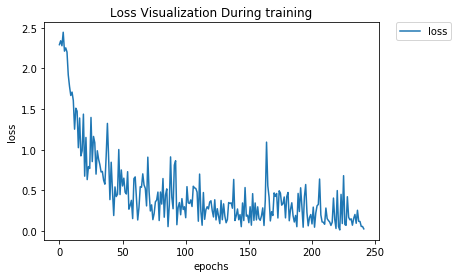

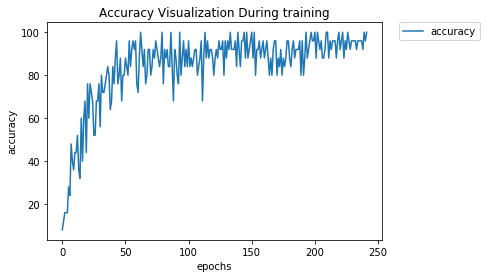

In [129]:

# plotting the points  
plt.plot(Yloss, label="loss") 

  
# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) 

# naming the x axis 
plt.xlabel('epochs') 
# naming the y axis 
plt.ylabel('loss') 
  
# giving a title to my graph 
plt.title('Loss Visualization During training') 
  
# function to show the plot 
plt.show() 

plt.plot(Yacc, label="accuracy") 

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) 

# naming the x axis 
plt.xlabel('epochs') 
# naming the y axis 
plt.ylabel('accuracy') 
plt.title('Accuracy Visualization During training') 

plt.show()


Expected Label: 7 Correct Label: 7


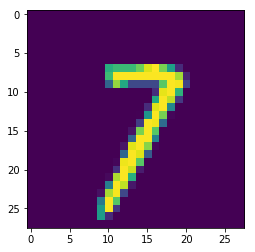

Expected Label: 0 Correct Label: 0


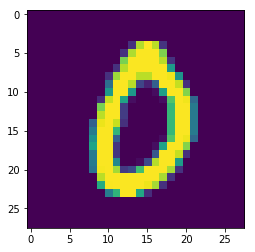

Expected Label: 6 Correct Label: 6


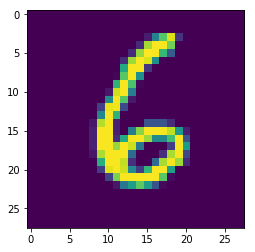

Expected Label: 6 Correct Label: 6


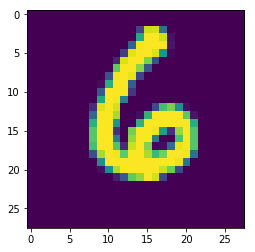

Expected Label: 1 Correct Label: 1


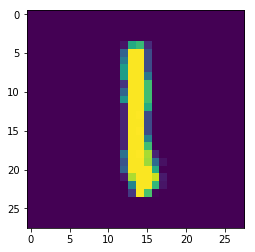

Expected Label: 4 Correct Label: 4


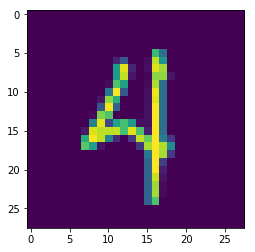

Expected Label: 3 Correct Label: 2


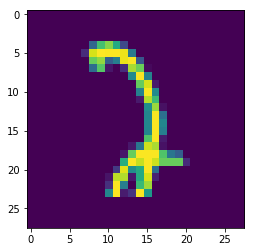

Expected Label: 1 Correct Label: 1


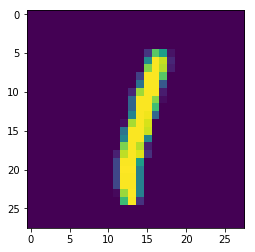

Expected Label: 1 Correct Label: 1


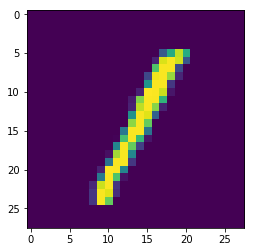

Expected Label: 1 Correct Label: 1


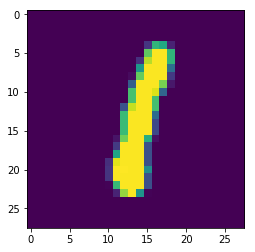

In [130]:
model.eval()
images, labels = next(iter(test_loader))
outputs = model(images)
_, predicted = torch.max(outputs.data, 1)


for i in range(10):
    print(f'Expected Label: {predicted[i]} Correct Label: {labels[i]}')
    showImage(images[i])

# Next Part of Homework

In [131]:
Xtrm, Ytrm = readData(mix=True)
Xtsm, Ytsm = readData(train=False, mix=True)
#Xtrm, Ytrm = readData(mix=True, cleanData=True)
#Xtsm, Ytsm = readData(train=False, mix=True, cleanData=True)


Image No. 1 of class 0 is read
Image No. 2 of class 0 is read
Image No. 3 of class 0 is read
Image No. 4 of class 0 is read
Image No. 5 of class 0 is read
Image No. 6 of class 0 is read
Image No. 7 of class 0 is read
Image No. 8 of class 0 is read
Image No. 9 of class 0 is read
Image No. 10 of class 0 is read
Image No. 11 of class 0 is read
Image No. 12 of class 0 is read
Image No. 13 of class 0 is read
Image No. 14 of class 0 is read
Image No. 15 of class 0 is read
Image No. 16 of class 0 is read
Image No. 17 of class 0 is read
Image No. 18 of class 0 is read
Image No. 19 of class 0 is read
Image No. 20 of class 0 is read
Image No. 21 of class 0 is read
Image No. 22 of class 0 is read
Image No. 23 of class 0 is read
Image No. 24 of class 0 is read
Image No. 25 of class 0 is read
Image No. 26 of class 0 is read
Image No. 27 of class 0 is read
Image No. 28 of class 0 is read
Image No. 29 of class 0 is read
Image No. 30 of class 0 is read
Image No. 31 of class 0 is read
Image No. 32 of c

Image No. 202 of class 1 is read
Image No. 203 of class 1 is read
Image No. 204 of class 1 is read
Image No. 205 of class 1 is read
Image No. 206 of class 1 is read
Image No. 207 of class 1 is read
Image No. 208 of class 1 is read
Image No. 209 of class 1 is read
Image No. 210 of class 1 is read
Image No. 211 of class 1 is read
Image No. 212 of class 1 is read
Image No. 213 of class 1 is read
Image No. 214 of class 1 is read
Image No. 215 of class 1 is read
Image No. 216 of class 1 is read
Image No. 217 of class 1 is read
Image No. 218 of class 1 is read
Image No. 219 of class 1 is read
Image No. 220 of class 1 is read
Image No. 221 of class 1 is read
Image No. 222 of class 1 is read
Image No. 223 of class 1 is read
Image No. 224 of class 1 is read
Image No. 225 of class 1 is read
Image No. 226 of class 1 is read
Image No. 227 of class 1 is read
Image No. 228 of class 1 is read
Image No. 229 of class 1 is read
Image No. 230 of class 1 is read
Image No. 231 of class 1 is read
Image No. 

Image No. 102 of class 3 is read
Image No. 103 of class 3 is read
Image No. 104 of class 3 is read
Image No. 105 of class 3 is read
Image No. 106 of class 3 is read
Image No. 107 of class 3 is read
Image No. 108 of class 3 is read
Image No. 109 of class 3 is read
Image No. 110 of class 3 is read
Image No. 111 of class 3 is read
Image No. 112 of class 3 is read
Image No. 113 of class 3 is read
Image No. 114 of class 3 is read
Image No. 115 of class 3 is read
Image No. 116 of class 3 is read
Image No. 117 of class 3 is read
Image No. 118 of class 3 is read
Image No. 119 of class 3 is read
Image No. 120 of class 3 is read
Image No. 121 of class 3 is read
Image No. 122 of class 3 is read
Image No. 123 of class 3 is read
Image No. 124 of class 3 is read
Image No. 125 of class 3 is read
Image No. 126 of class 3 is read
Image No. 127 of class 3 is read
Image No. 128 of class 3 is read
Image No. 129 of class 3 is read
Image No. 130 of class 3 is read
Image No. 131 of class 3 is read
Image No. 

Image No. 300 of class 4 is read
Image No. 301 of class 4 is read
Image No. 1 of class 5 is read
Image No. 2 of class 5 is read
Image No. 3 of class 5 is read
Image No. 4 of class 5 is read
Image No. 5 of class 5 is read
Image No. 6 of class 5 is read
Image No. 7 of class 5 is read
Image No. 8 of class 5 is read
Image No. 9 of class 5 is read
Image No. 10 of class 5 is read
Image No. 11 of class 5 is read
Image No. 12 of class 5 is read
Image No. 13 of class 5 is read
Image No. 14 of class 5 is read
Image No. 15 of class 5 is read
Image No. 16 of class 5 is read
Image No. 17 of class 5 is read
Image No. 18 of class 5 is read
Image No. 19 of class 5 is read
Image No. 20 of class 5 is read
Image No. 21 of class 5 is read
Image No. 22 of class 5 is read
Image No. 23 of class 5 is read
Image No. 24 of class 5 is read
Image No. 25 of class 5 is read
Image No. 26 of class 5 is read
Image No. 27 of class 5 is read
Image No. 28 of class 5 is read
Image No. 29 of class 5 is read
Image No. 30 of

Image No. 200 of class 6 is read
Image No. 201 of class 6 is read
Image No. 202 of class 6 is read
Image No. 203 of class 6 is read
Image No. 204 of class 6 is read
Image No. 205 of class 6 is read
Image No. 206 of class 6 is read
Image No. 207 of class 6 is read
Image No. 208 of class 6 is read
Image No. 209 of class 6 is read
Image No. 210 of class 6 is read
Image No. 211 of class 6 is read
Image No. 212 of class 6 is read
Image No. 213 of class 6 is read
Image No. 214 of class 6 is read
Image No. 215 of class 6 is read
Image No. 216 of class 6 is read
Image No. 217 of class 6 is read
Image No. 218 of class 6 is read
Image No. 219 of class 6 is read
Image No. 220 of class 6 is read
Image No. 221 of class 6 is read
Image No. 222 of class 6 is read
Image No. 223 of class 6 is read
Image No. 224 of class 6 is read
Image No. 225 of class 6 is read
Image No. 226 of class 6 is read
Image No. 227 of class 6 is read
Image No. 228 of class 6 is read
Image No. 229 of class 6 is read
Image No. 

Image No. 100 of class 8 is read
Image No. 101 of class 8 is read
Image No. 102 of class 8 is read
Image No. 103 of class 8 is read
Image No. 104 of class 8 is read
Image No. 105 of class 8 is read
Image No. 106 of class 8 is read
Image No. 107 of class 8 is read
Image No. 108 of class 8 is read
Image No. 109 of class 8 is read
Image No. 110 of class 8 is read
Image No. 111 of class 8 is read
Image No. 112 of class 8 is read
Image No. 113 of class 8 is read
Image No. 114 of class 8 is read
Image No. 115 of class 8 is read
Image No. 116 of class 8 is read
Image No. 117 of class 8 is read
Image No. 118 of class 8 is read
Image No. 119 of class 8 is read
Image No. 120 of class 8 is read
Image No. 121 of class 8 is read
Image No. 122 of class 8 is read
Image No. 123 of class 8 is read
Image No. 124 of class 8 is read
Image No. 125 of class 8 is read
Image No. 126 of class 8 is read
Image No. 127 of class 8 is read
Image No. 128 of class 8 is read
Image No. 129 of class 8 is read
Image No. 

Image No. 49 of class 9 is read
Image No. 50 of class 9 is read
Image No. 51 of class 9 is read
Image No. 52 of class 9 is read
Image No. 53 of class 9 is read
Image No. 54 of class 9 is read
Image No. 55 of class 9 is read
Image No. 56 of class 9 is read
Image No. 57 of class 9 is read
Image No. 58 of class 9 is read
Image No. 59 of class 9 is read
Image No. 60 of class 9 is read
Image No. 61 of class 9 is read
Image No. 62 of class 9 is read
Image No. 63 of class 9 is read
Image No. 64 of class 9 is read
Image No. 65 of class 9 is read
Image No. 66 of class 9 is read
Image No. 67 of class 9 is read
Image No. 68 of class 9 is read
Image No. 69 of class 9 is read
Image No. 70 of class 9 is read
Image No. 71 of class 9 is read
Image No. 72 of class 9 is read
Image No. 73 of class 9 is read
Image No. 74 of class 9 is read
Image No. 75 of class 9 is read
Image No. 76 of class 9 is read
Image No. 77 of class 9 is read
Image No. 78 of class 9 is read
Image No. 79 of class 9 is read
Image No

Image No. 248 of class 0 is read
Image No. 249 of class 0 is read
Image No. 250 of class 0 is read
Image No. 251 of class 0 is read
Image No. 252 of class 0 is read
Image No. 253 of class 0 is read
Image No. 254 of class 0 is read
Image No. 255 of class 0 is read
Image No. 256 of class 0 is read
Image No. 257 of class 0 is read
Image No. 258 of class 0 is read
Image No. 259 of class 0 is read
Image No. 260 of class 0 is read
Image No. 261 of class 0 is read
Image No. 262 of class 0 is read
Image No. 263 of class 0 is read
Image No. 264 of class 0 is read
Image No. 265 of class 0 is read
Image No. 266 of class 0 is read
Image No. 267 of class 0 is read
Image No. 268 of class 0 is read
Image No. 269 of class 0 is read
Image No. 270 of class 0 is read
Image No. 271 of class 0 is read
Image No. 272 of class 0 is read
Image No. 273 of class 0 is read
Image No. 274 of class 0 is read
Image No. 275 of class 0 is read
Image No. 276 of class 0 is read
Image No. 277 of class 0 is read
Image No. 

Image No. 148 of class 2 is read
Image No. 149 of class 2 is read
Image No. 150 of class 2 is read
Image No. 151 of class 2 is read
Image No. 152 of class 2 is read
Image No. 153 of class 2 is read
Image No. 154 of class 2 is read
Image No. 155 of class 2 is read
Image No. 156 of class 2 is read
Image No. 157 of class 2 is read
Image No. 158 of class 2 is read
Image No. 159 of class 2 is read
Image No. 160 of class 2 is read
Image No. 161 of class 2 is read
Image No. 162 of class 2 is read
Image No. 163 of class 2 is read
Image No. 164 of class 2 is read
Image No. 165 of class 2 is read
Image No. 166 of class 2 is read
Image No. 167 of class 2 is read
Image No. 168 of class 2 is read
Image No. 169 of class 2 is read
Image No. 170 of class 2 is read
Image No. 171 of class 2 is read
Image No. 172 of class 2 is read
Image No. 173 of class 2 is read
Image No. 174 of class 2 is read
Image No. 175 of class 2 is read
Image No. 176 of class 2 is read
Image No. 177 of class 2 is read
Image No. 

Image No. 47 of class 4 is read
Image No. 48 of class 4 is read
Image No. 49 of class 4 is read
Image No. 50 of class 4 is read
Image No. 51 of class 4 is read
Image No. 52 of class 4 is read
Image No. 53 of class 4 is read
Image No. 54 of class 4 is read
Image No. 55 of class 4 is read
Image No. 56 of class 4 is read
Image No. 57 of class 4 is read
Image No. 58 of class 4 is read
Image No. 59 of class 4 is read
Image No. 60 of class 4 is read
Image No. 61 of class 4 is read
Image No. 62 of class 4 is read
Image No. 63 of class 4 is read
Image No. 64 of class 4 is read
Image No. 65 of class 4 is read
Image No. 66 of class 4 is read
Image No. 67 of class 4 is read
Image No. 68 of class 4 is read
Image No. 69 of class 4 is read
Image No. 70 of class 4 is read
Image No. 71 of class 4 is read
Image No. 72 of class 4 is read
Image No. 73 of class 4 is read
Image No. 74 of class 4 is read
Image No. 75 of class 4 is read
Image No. 76 of class 4 is read
Image No. 77 of class 4 is read
Image No

Image No. 246 of class 5 is read
Image No. 247 of class 5 is read
Image No. 248 of class 5 is read
Image No. 249 of class 5 is read
Image No. 250 of class 5 is read
Image No. 251 of class 5 is read
Image No. 252 of class 5 is read
Image No. 253 of class 5 is read
Image No. 254 of class 5 is read
Image No. 255 of class 5 is read
Image No. 256 of class 5 is read
Image No. 257 of class 5 is read
Image No. 258 of class 5 is read
Image No. 259 of class 5 is read
Image No. 260 of class 5 is read
Image No. 261 of class 5 is read
Image No. 262 of class 5 is read
Image No. 263 of class 5 is read
Image No. 264 of class 5 is read
Image No. 265 of class 5 is read
Image No. 266 of class 5 is read
Image No. 267 of class 5 is read
Image No. 268 of class 5 is read
Image No. 269 of class 5 is read
Image No. 270 of class 5 is read
Image No. 271 of class 5 is read
Image No. 272 of class 5 is read
Image No. 273 of class 5 is read
Image No. 274 of class 5 is read
Image No. 275 of class 5 is read
Image No. 

Image No. 146 of class 7 is read
Image No. 147 of class 7 is read
Image No. 148 of class 7 is read
Image No. 149 of class 7 is read
Image No. 150 of class 7 is read
Image No. 151 of class 7 is read
Image No. 152 of class 7 is read
Image No. 153 of class 7 is read
Image No. 154 of class 7 is read
Image No. 155 of class 7 is read
Image No. 156 of class 7 is read
Image No. 157 of class 7 is read
Image No. 158 of class 7 is read
Image No. 159 of class 7 is read
Image No. 160 of class 7 is read
Image No. 161 of class 7 is read
Image No. 162 of class 7 is read
Image No. 163 of class 7 is read
Image No. 164 of class 7 is read
Image No. 165 of class 7 is read
Image No. 166 of class 7 is read
Image No. 167 of class 7 is read
Image No. 168 of class 7 is read
Image No. 169 of class 7 is read
Image No. 170 of class 7 is read
Image No. 171 of class 7 is read
Image No. 172 of class 7 is read
Image No. 173 of class 7 is read
Image No. 174 of class 7 is read
Image No. 175 of class 7 is read
Image No. 

Image No. 45 of class 9 is read
Image No. 46 of class 9 is read
Image No. 47 of class 9 is read
Image No. 48 of class 9 is read
Image No. 49 of class 9 is read
Image No. 50 of class 9 is read
Image No. 51 of class 9 is read
Image No. 52 of class 9 is read
Image No. 53 of class 9 is read
Image No. 54 of class 9 is read
Image No. 55 of class 9 is read
Image No. 56 of class 9 is read
Image No. 57 of class 9 is read
Image No. 58 of class 9 is read
Image No. 59 of class 9 is read
Image No. 60 of class 9 is read
Image No. 61 of class 9 is read
Image No. 62 of class 9 is read
Image No. 63 of class 9 is read
Image No. 64 of class 9 is read
Image No. 65 of class 9 is read
Image No. 66 of class 9 is read
Image No. 67 of class 9 is read
Image No. 68 of class 9 is read
Image No. 69 of class 9 is read
Image No. 70 of class 9 is read
Image No. 71 of class 9 is read
Image No. 72 of class 9 is read
Image No. 73 of class 9 is read
Image No. 74 of class 9 is read
Image No. 75 of class 9 is read
Image No

In [132]:
print(len(Ytsm))
print(Xtsm.shape)
print(len(Ytrm))
print(Xtrm.shape)

3010
torch.Size([3010, 1, 28, 28])
3010
torch.Size([3010, 1, 28, 28])


In [133]:
trainM_dataset = []
testM_dataset = []

for i in range(Xtrm.shape[0]):
   trainM_dataset.append([Xtrm[i], Ytrm[i]])
for i in range(Xtsm.shape[0]):
   testM_dataset.append([Xtsm[i], Ytsm[i]])

trainM_loader = DataLoader(dataset=trainM_dataset, batch_size=batch_size, shuffle=True)
testM_loader = DataLoader(dataset=testM_dataset, batch_size=batch_size, shuffle=True)

In [134]:
# Copied from website then edited
# Wesite URL: https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/

model2 = ConvNet()

# Loss and optimizer
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [135]:
# Copied from website then edited
# Wesite URL: https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/

# Train the model
total_step2 = len(trainM_loader)
loss_list2 = []
acc_list2 = []
Yacc2 = []
Yloss2 = []
for epoch in range(num_epochs):
    for i, (imgs, lbls) in enumerate(trainM_loader):
        # Run the forward pass
        outputs = model2(imgs)
        #print(outputs.shape)
        loss = criterion2(outputs, lbls)
        loss_list2.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()

        # Track the accuracy
        total = lbls.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == lbls).sum().item()
        acc_list2.append(correct / total)

        if (i + 1) % int(printNow) == 0:
            Yacc2.append((correct / total) * 100)
            Yloss2.append(loss.item())
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/2], Step [1/121], Loss: 2.3230, Accuracy: 8.00%
Epoch [1/2], Step [2/121], Loss: 2.4857, Accuracy: 4.00%
Epoch [1/2], Step [3/121], Loss: 2.3835, Accuracy: 4.00%
Epoch [1/2], Step [4/121], Loss: 2.2987, Accuracy: 12.00%
Epoch [1/2], Step [5/121], Loss: 2.3680, Accuracy: 8.00%
Epoch [1/2], Step [6/121], Loss: 2.3182, Accuracy: 8.00%
Epoch [1/2], Step [7/121], Loss: 2.2684, Accuracy: 16.00%
Epoch [1/2], Step [8/121], Loss: 2.2542, Accuracy: 12.00%
Epoch [1/2], Step [9/121], Loss: 2.4090, Accuracy: 0.00%
Epoch [1/2], Step [10/121], Loss: 2.3194, Accuracy: 20.00%
Epoch [1/2], Step [11/121], Loss: 2.3994, Accuracy: 8.00%
Epoch [1/2], Step [12/121], Loss: 2.2577, Accuracy: 4.00%
Epoch [1/2], Step [13/121], Loss: 2.2082, Accuracy: 16.00%
Epoch [1/2], Step [14/121], Loss: 2.3558, Accuracy: 20.00%
Epoch [1/2], Step [15/121], Loss: 2.3749, Accuracy: 20.00%
Epoch [1/2], Step [16/121], Loss: 2.3731, Accuracy: 12.00%
Epoch [1/2], Step [17/121], Loss: 2.2626, Accuracy: 12.00%
Epoch [1/2], S

In [136]:
# Copied from website then edited
# Wesite URL: https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/

# Test the model
model2.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testM_loader:
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model: {} %'.format((correct / total) * 100))


Test Accuracy of the model: 65.3156146179402 %


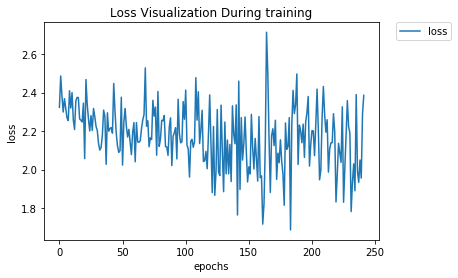

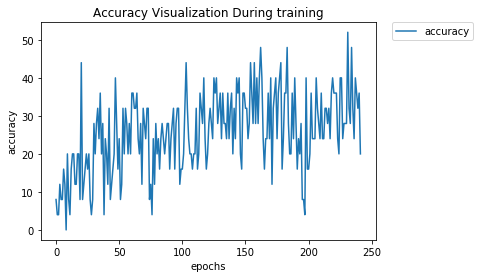

In [137]:

plt.plot(Yloss2, label="loss") 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) 
plt.xlabel('epochs')
plt.ylabel('loss') 
plt.title('Loss Visualization During training') 
plt.show() 


plt.plot(Yacc2, label="accuracy") 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) 
plt.xlabel('epochs') 
plt.ylabel('accuracy') 
plt.title('Accuracy Visualization During training') 

plt.show()

Expected Label: 2 Correct Label: 2


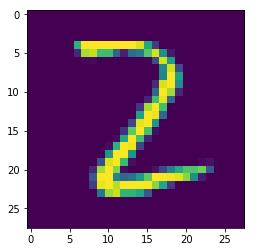

Expected Label: 5 Correct Label: 5


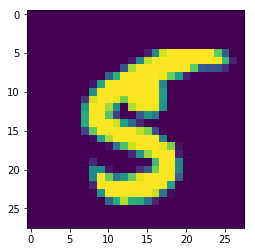

Expected Label: 9 Correct Label: 9


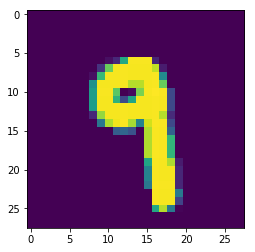

Expected Label: 1 Correct Label: 1


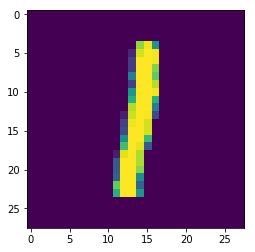

Expected Label: 0 Correct Label: 0


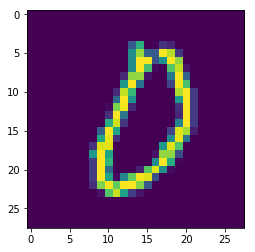

Expected Label: 5 Correct Label: 3


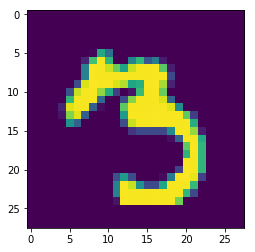

Expected Label: 6 Correct Label: 6


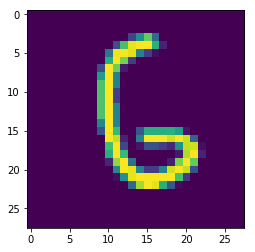

Expected Label: 0 Correct Label: 0


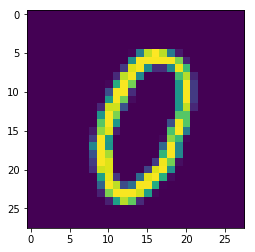

Expected Label: 6 Correct Label: 6


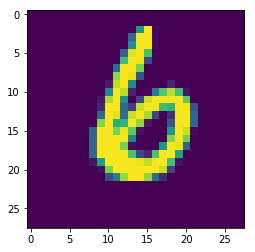

Expected Label: 4 Correct Label: 4


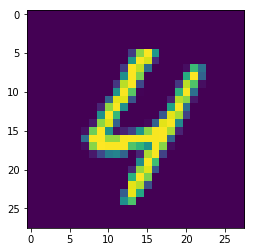

In [138]:
model2.eval()
images, labels = next(iter(testM_loader))
outputs = model2(images)
_, predicted = torch.max(outputs.data, 1)


for i in range(10):
    print(f'Expected Label: {predicted[i]} Correct Label: {labels[i]}')
    showImage(images[i])

In [139]:
Xtrm, Ytrm = readData(mix=True, cData=True)
Xtsm, Ytsm = readData(train=False, mix=True, cData=True)


Image No. 1 of class 0 is read
Image No. 2 of class 0 is read
Image No. 3 of class 0 is read
Image No. 4 of class 0 is read
Image No. 5 of class 0 is read
Image No. 6 of class 0 is read
Image No. 7 of class 0 is read
Image No. 8 of class 0 is read
Image No. 9 of class 0 is read
Image No. 10 of class 0 is read
Image No. 11 of class 0 is read
Image No. 12 of class 0 is read
Image No. 13 of class 0 is read
Image No. 14 of class 0 is read
Image No. 15 of class 0 is read
Image No. 16 of class 0 is read
Image No. 17 of class 0 is read
Image No. 18 of class 0 is read
Image No. 19 of class 0 is read
Image No. 20 of class 0 is read
Image No. 21 of class 0 is read
Image No. 22 of class 0 is read
Image No. 23 of class 0 is read
Image No. 24 of class 0 is read
Image No. 25 of class 0 is read
Image No. 26 of class 0 is read
Image No. 27 of class 0 is read
Image No. 28 of class 0 is read
Image No. 29 of class 0 is read
Image No. 30 of class 0 is read
Image No. 31 of class 0 is read
Image No. 32 of c

Image No. Difference 175 is processed
Image No. Difference 176 is processed
Image No. Difference 177 is processed
Image No. Difference 178 is processed
Image No. Difference 179 is processed
Image No. Difference 180 is processed
Image No. Difference 181 is processed
Image No. Difference 182 is processed
Image No. Difference 183 is processed
Image No. Difference 184 is processed
Image No. Difference 185 is processed
Image No. Difference 186 is processed
Image No. Difference 187 is processed
Image No. Difference 188 is processed
Image No. Difference 189 is processed
Image No. Difference 190 is processed
Image No. Difference 191 is processed
Image No. Difference 192 is processed
Image No. Difference 193 is processed
Image No. Difference 194 is processed
Image No. Difference 195 is processed
Image No. Difference 196 is processed
Image No. Difference 197 is processed
Image No. Difference 198 is processed
Image No. Difference 199 is processed
Image No. Difference 200 is processed
Image No. Di

Image No. Difference 47 is processed
Image No. Difference 48 is processed
Image No. Difference 49 is processed
Image No. Difference 50 is processed
Image No. Difference 51 is processed
Image No. Difference 52 is processed
Image No. Difference 53 is processed
Image No. Difference 54 is processed
Image No. Difference 55 is processed
Image No. Difference 56 is processed
Image No. Difference 57 is processed
Image No. Difference 58 is processed
Image No. Difference 59 is processed
Image No. Difference 60 is processed
Image No. Difference 61 is processed
Image No. Difference 62 is processed
Image No. Difference 63 is processed
Image No. Difference 64 is processed
Image No. Difference 65 is processed
Image No. Difference 66 is processed
Image No. Difference 67 is processed
Image No. Difference 68 is processed
Image No. Difference 69 is processed
Image No. Difference 70 is processed
Image No. Difference 71 is processed
Image No. Difference 72 is processed
Image No. Difference 73 is processed
I

Image No. Difference 264 is processed
Image No. Difference 265 is processed
Image No. Difference 266 is processed
Image No. Difference 267 is processed
Image No. Difference 268 is processed
Image No. Difference 269 is processed
Image No. Difference 270 is processed
Image No. Difference 271 is processed
Image No. Difference 272 is processed
Image No. Difference 273 is processed
Image No. Difference 274 is processed
Image No. Difference 275 is processed
Image No. Difference 276 is processed
Image No. Difference 277 is processed
Image No. Difference 278 is processed
Image No. Difference 279 is processed
Image No. Difference 280 is processed
Image No. Difference 281 is processed
Image No. Difference 282 is processed
Image No. Difference 283 is processed
Image No. Difference 284 is processed
Image No. Difference 285 is processed
Image No. Difference 286 is processed
Image No. Difference 287 is processed
Image No. Difference 288 is processed
Image No. Difference 289 is processed
Image No. Di

Image No. Difference 10 is processed
Image No. Difference 11 is processed
Image No. Difference 12 is processed
Image No. Difference 13 is processed
Image No. Difference 14 is processed
Image No. Difference 15 is processed
Image No. Difference 16 is processed
Image No. Difference 17 is processed
Image No. Difference 18 is processed
Image No. Difference 19 is processed
Image No. Difference 20 is processed
Image No. Difference 21 is processed
Image No. Difference 22 is processed
Image No. Difference 23 is processed
Image No. Difference 24 is processed
Image No. Difference 25 is processed
Image No. Difference 26 is processed
Image No. Difference 27 is processed
Image No. Difference 28 is processed
Image No. Difference 29 is processed
Image No. Difference 30 is processed
Image No. Difference 31 is processed
Image No. Difference 32 is processed
Image No. Difference 33 is processed
Image No. Difference 34 is processed
Image No. Difference 35 is processed
Image No. Difference 36 is processed
I

Image No. 167 of class 3 is read
Image No. 168 of class 3 is read
Image No. 169 of class 3 is read
Image No. 170 of class 3 is read
Image No. 171 of class 3 is read
Image No. 172 of class 3 is read
Image No. 173 of class 3 is read
Image No. 174 of class 3 is read
Image No. 175 of class 3 is read
Image No. 176 of class 3 is read
Image No. 177 of class 3 is read
Image No. 178 of class 3 is read
Image No. 179 of class 3 is read
Image No. 180 of class 3 is read
Image No. 181 of class 3 is read
Image No. 182 of class 3 is read
Image No. 183 of class 3 is read
Image No. 184 of class 3 is read
Image No. 185 of class 3 is read
Image No. 186 of class 3 is read
Image No. 187 of class 3 is read
Image No. 188 of class 3 is read
Image No. 189 of class 3 is read
Image No. 190 of class 3 is read
Image No. 191 of class 3 is read
Image No. 192 of class 3 is read
Image No. 193 of class 3 is read
Image No. 194 of class 3 is read
Image No. 195 of class 3 is read
Image No. 196 of class 3 is read
Image No. 

Image No. 19 of class 4 is read
Image No. 20 of class 4 is read
Image No. 21 of class 4 is read
Image No. 22 of class 4 is read
Image No. 23 of class 4 is read
Image No. 24 of class 4 is read
Image No. 25 of class 4 is read
Image No. 26 of class 4 is read
Image No. 27 of class 4 is read
Image No. 28 of class 4 is read
Image No. 29 of class 4 is read
Image No. 30 of class 4 is read
Image No. 31 of class 4 is read
Image No. 32 of class 4 is read
Image No. 33 of class 4 is read
Image No. 34 of class 4 is read
Image No. 35 of class 4 is read
Image No. 36 of class 4 is read
Image No. 37 of class 4 is read
Image No. 38 of class 4 is read
Image No. 39 of class 4 is read
Image No. 40 of class 4 is read
Image No. 41 of class 4 is read
Image No. 42 of class 4 is read
Image No. 43 of class 4 is read
Image No. 44 of class 4 is read
Image No. 45 of class 4 is read
Image No. 46 of class 4 is read
Image No. 47 of class 4 is read
Image No. 48 of class 4 is read
Image No. 49 of class 4 is read
Image No

Image No. Difference 189 is processed
Image No. Difference 190 is processed
Image No. Difference 191 is processed
Image No. Difference 192 is processed
Image No. Difference 193 is processed
Image No. Difference 194 is processed
Image No. Difference 195 is processed
Image No. Difference 196 is processed
Image No. Difference 197 is processed
Image No. Difference 198 is processed
Image No. Difference 199 is processed
Image No. Difference 200 is processed
Image No. Difference 201 is processed
Image No. Difference 202 is processed
Image No. Difference 203 is processed
Image No. Difference 204 is processed
Image No. Difference 205 is processed
Image No. Difference 206 is processed
Image No. Difference 207 is processed
Image No. Difference 208 is processed
Image No. Difference 209 is processed
Image No. Difference 210 is processed
Image No. Difference 211 is processed
Image No. Difference 212 is processed
Image No. Difference 213 is processed
Image No. Difference 214 is processed
Image No. Di

Image No. Difference 57 is processed
Image No. Difference 58 is processed
Image No. Difference 59 is processed
Image No. Difference 60 is processed
Image No. Difference 61 is processed
Image No. Difference 62 is processed
Image No. Difference 63 is processed
Image No. Difference 64 is processed
Image No. Difference 65 is processed
Image No. Difference 66 is processed
Image No. Difference 67 is processed
Image No. Difference 68 is processed
Image No. Difference 69 is processed
Image No. Difference 70 is processed
Image No. Difference 71 is processed
Image No. Difference 72 is processed
Image No. Difference 73 is processed
Image No. Difference 74 is processed
Image No. Difference 75 is processed
Image No. Difference 76 is processed
Image No. Difference 77 is processed
Image No. Difference 78 is processed
Image No. Difference 79 is processed
Image No. Difference 80 is processed
Image No. Difference 81 is processed
Image No. Difference 82 is processed
Image No. Difference 83 is processed
I

Image No. 220 of class 6 is read
Image No. 221 of class 6 is read
Image No. 222 of class 6 is read
Image No. 223 of class 6 is read
Image No. 224 of class 6 is read
Image No. 225 of class 6 is read
Image No. 226 of class 6 is read
Image No. 227 of class 6 is read
Image No. 228 of class 6 is read
Image No. 229 of class 6 is read
Image No. 230 of class 6 is read
Image No. 231 of class 6 is read
Image No. 232 of class 6 is read
Image No. 233 of class 6 is read
Image No. 234 of class 6 is read
Image No. 235 of class 6 is read
Image No. 236 of class 6 is read
Image No. 237 of class 6 is read
Image No. 238 of class 6 is read
Image No. 239 of class 6 is read
Image No. 240 of class 6 is read
Image No. 241 of class 6 is read
Image No. 242 of class 6 is read
Image No. 243 of class 6 is read
Image No. 244 of class 6 is read
Image No. 245 of class 6 is read
Image No. 246 of class 6 is read
Image No. 247 of class 6 is read
Image No. 248 of class 6 is read
Image No. 249 of class 6 is read
Image No. 

Image No. 74 of class 7 is read
Image No. 75 of class 7 is read
Image No. 76 of class 7 is read
Image No. 77 of class 7 is read
Image No. 78 of class 7 is read
Image No. 79 of class 7 is read
Image No. 80 of class 7 is read
Image No. 81 of class 7 is read
Image No. 82 of class 7 is read
Image No. 83 of class 7 is read
Image No. 84 of class 7 is read
Image No. 85 of class 7 is read
Image No. 86 of class 7 is read
Image No. 87 of class 7 is read
Image No. 88 of class 7 is read
Image No. 89 of class 7 is read
Image No. 90 of class 7 is read
Image No. 91 of class 7 is read
Image No. 92 of class 7 is read
Image No. 93 of class 7 is read
Image No. 94 of class 7 is read
Image No. 95 of class 7 is read
Image No. 96 of class 7 is read
Image No. 97 of class 7 is read
Image No. 98 of class 7 is read
Image No. 99 of class 7 is read
Image No. 100 of class 7 is read
Image No. 101 of class 7 is read
Image No. 102 of class 7 is read
Image No. 103 of class 7 is read
Image No. 104 of class 7 is read
Ima

Image No. Difference 236 is processed
Image No. Difference 237 is processed
Image No. Difference 238 is processed
Image No. Difference 239 is processed
Image No. Difference 240 is processed
Image No. Difference 241 is processed
Image No. Difference 242 is processed
Image No. Difference 243 is processed
Image No. Difference 244 is processed
Image No. Difference 245 is processed
Image No. Difference 246 is processed
Image No. Difference 247 is processed
Image No. Difference 248 is processed
Image No. Difference 249 is processed
Image No. Difference 250 is processed
Image No. Difference 251 is processed
Image No. Difference 252 is processed
Image No. Difference 253 is processed
Image No. Difference 254 is processed
Image No. Difference 255 is processed
Image No. Difference 256 is processed
Image No. Difference 257 is processed
Image No. Difference 258 is processed
Image No. Difference 259 is processed
Image No. Difference 260 is processed
Image No. Difference 261 is processed
Image No. Di

Image No. Difference 64 is processed
Image No. Difference 65 is processed
Image No. Difference 66 is processed
Image No. Difference 67 is processed
Image No. Difference 68 is processed
Image No. Difference 69 is processed
Image No. Difference 70 is processed
Image No. Difference 71 is processed
Image No. Difference 72 is processed
Image No. Difference 73 is processed
Image No. Difference 74 is processed
Image No. Difference 75 is processed
Image No. Difference 76 is processed
Image No. Difference 77 is processed
Image No. Difference 78 is processed
Image No. Difference 79 is processed
Image No. Difference 80 is processed
Image No. Difference 81 is processed
Image No. Difference 82 is processed
Image No. Difference 83 is processed
Image No. Difference 84 is processed
Image No. Difference 85 is processed
Image No. Difference 86 is processed
Image No. Difference 87 is processed
Image No. Difference 88 is processed
Image No. Difference 89 is processed
Image No. Difference 90 is processed
I

Image No. 228 of class 9 is read
Image No. 229 of class 9 is read
Image No. 230 of class 9 is read
Image No. 231 of class 9 is read
Image No. 232 of class 9 is read
Image No. 233 of class 9 is read
Image No. 234 of class 9 is read
Image No. 235 of class 9 is read
Image No. 236 of class 9 is read
Image No. 237 of class 9 is read
Image No. 238 of class 9 is read
Image No. 239 of class 9 is read
Image No. 240 of class 9 is read
Image No. 241 of class 9 is read
Image No. 242 of class 9 is read
Image No. 243 of class 9 is read
Image No. 244 of class 9 is read
Image No. 245 of class 9 is read
Image No. 246 of class 9 is read
Image No. 247 of class 9 is read
Image No. 248 of class 9 is read
Image No. 249 of class 9 is read
Image No. 250 of class 9 is read
Image No. 251 of class 9 is read
Image No. 252 of class 9 is read
Image No. 253 of class 9 is read
Image No. 254 of class 9 is read
Image No. 255 of class 9 is read
Image No. 256 of class 9 is read
Image No. 257 of class 9 is read
Image No. 

Image No. 82 of class 0 is read
Image No. 83 of class 0 is read
Image No. 84 of class 0 is read
Image No. 85 of class 0 is read
Image No. 86 of class 0 is read
Image No. 87 of class 0 is read
Image No. 88 of class 0 is read
Image No. 89 of class 0 is read
Image No. 90 of class 0 is read
Image No. 91 of class 0 is read
Image No. 92 of class 0 is read
Image No. 93 of class 0 is read
Image No. 94 of class 0 is read
Image No. 95 of class 0 is read
Image No. 96 of class 0 is read
Image No. 97 of class 0 is read
Image No. 98 of class 0 is read
Image No. 99 of class 0 is read
Image No. 100 of class 0 is read
Image No. 101 of class 0 is read
Image No. 102 of class 0 is read
Image No. 103 of class 0 is read
Image No. 104 of class 0 is read
Image No. 105 of class 0 is read
Image No. 106 of class 0 is read
Image No. 107 of class 0 is read
Image No. 108 of class 0 is read
Image No. 109 of class 0 is read
Image No. 110 of class 0 is read
Image No. 111 of class 0 is read
Image No. 112 of class 0 is 

Image No. 31 of class 1 is read
Image No. 32 of class 1 is read
Image No. 33 of class 1 is read
Image No. 34 of class 1 is read
Image No. 35 of class 1 is read
Image No. 36 of class 1 is read
Image No. 37 of class 1 is read
Image No. 38 of class 1 is read
Image No. 39 of class 1 is read
Image No. 40 of class 1 is read
Image No. 41 of class 1 is read
Image No. 42 of class 1 is read
Image No. 43 of class 1 is read
Image No. 44 of class 1 is read
Image No. 45 of class 1 is read
Image No. 46 of class 1 is read
Image No. 47 of class 1 is read
Image No. 48 of class 1 is read
Image No. 49 of class 1 is read
Image No. 50 of class 1 is read
Image No. 51 of class 1 is read
Image No. 52 of class 1 is read
Image No. 53 of class 1 is read
Image No. 54 of class 1 is read
Image No. 55 of class 1 is read
Image No. 56 of class 1 is read
Image No. 57 of class 1 is read
Image No. 58 of class 1 is read
Image No. 59 of class 1 is read
Image No. 60 of class 1 is read
Image No. 61 of class 1 is read
Image No

Image No. 231 of class 2 is read
Image No. 232 of class 2 is read
Image No. 233 of class 2 is read
Image No. 234 of class 2 is read
Image No. 235 of class 2 is read
Image No. 236 of class 2 is read
Image No. 237 of class 2 is read
Image No. 238 of class 2 is read
Image No. 239 of class 2 is read
Image No. 240 of class 2 is read
Image No. 241 of class 2 is read
Image No. 242 of class 2 is read
Image No. 243 of class 2 is read
Image No. 244 of class 2 is read
Image No. 245 of class 2 is read
Image No. 246 of class 2 is read
Image No. 247 of class 2 is read
Image No. 248 of class 2 is read
Image No. 249 of class 2 is read
Image No. 250 of class 2 is read
Image No. 251 of class 2 is read
Image No. 252 of class 2 is read
Image No. 253 of class 2 is read
Image No. 254 of class 2 is read
Image No. 255 of class 2 is read
Image No. 256 of class 2 is read
Image No. 257 of class 2 is read
Image No. 258 of class 2 is read
Image No. 259 of class 2 is read
Image No. 260 of class 2 is read
Image No. 

Image No. 131 of class 4 is read
Image No. 132 of class 4 is read
Image No. 133 of class 4 is read
Image No. 134 of class 4 is read
Image No. 135 of class 4 is read
Image No. 136 of class 4 is read
Image No. 137 of class 4 is read
Image No. 138 of class 4 is read
Image No. 139 of class 4 is read
Image No. 140 of class 4 is read
Image No. 141 of class 4 is read
Image No. 142 of class 4 is read
Image No. 143 of class 4 is read
Image No. 144 of class 4 is read
Image No. 145 of class 4 is read
Image No. 146 of class 4 is read
Image No. 147 of class 4 is read
Image No. 148 of class 4 is read
Image No. 149 of class 4 is read
Image No. 150 of class 4 is read
Image No. 151 of class 4 is read
Image No. 152 of class 4 is read
Image No. 153 of class 4 is read
Image No. 154 of class 4 is read
Image No. 155 of class 4 is read
Image No. 156 of class 4 is read
Image No. 157 of class 4 is read
Image No. 158 of class 4 is read
Image No. 159 of class 4 is read
Image No. 160 of class 4 is read
Image No. 

Image No. 29 of class 6 is read
Image No. 30 of class 6 is read
Image No. 31 of class 6 is read
Image No. 32 of class 6 is read
Image No. 33 of class 6 is read
Image No. 34 of class 6 is read
Image No. 35 of class 6 is read
Image No. 36 of class 6 is read
Image No. 37 of class 6 is read
Image No. 38 of class 6 is read
Image No. 39 of class 6 is read
Image No. 40 of class 6 is read
Image No. 41 of class 6 is read
Image No. 42 of class 6 is read
Image No. 43 of class 6 is read
Image No. 44 of class 6 is read
Image No. 45 of class 6 is read
Image No. 46 of class 6 is read
Image No. 47 of class 6 is read
Image No. 48 of class 6 is read
Image No. 49 of class 6 is read
Image No. 50 of class 6 is read
Image No. 51 of class 6 is read
Image No. 52 of class 6 is read
Image No. 53 of class 6 is read
Image No. 54 of class 6 is read
Image No. 55 of class 6 is read
Image No. 56 of class 6 is read
Image No. 57 of class 6 is read
Image No. 58 of class 6 is read
Image No. 59 of class 6 is read
Image No

Image No. 229 of class 7 is read
Image No. 230 of class 7 is read
Image No. 231 of class 7 is read
Image No. 232 of class 7 is read
Image No. 233 of class 7 is read
Image No. 234 of class 7 is read
Image No. 235 of class 7 is read
Image No. 236 of class 7 is read
Image No. 237 of class 7 is read
Image No. 238 of class 7 is read
Image No. 239 of class 7 is read
Image No. 240 of class 7 is read
Image No. 241 of class 7 is read
Image No. 242 of class 7 is read
Image No. 243 of class 7 is read
Image No. 244 of class 7 is read
Image No. 245 of class 7 is read
Image No. 246 of class 7 is read
Image No. 247 of class 7 is read
Image No. 248 of class 7 is read
Image No. 249 of class 7 is read
Image No. 250 of class 7 is read
Image No. 251 of class 7 is read
Image No. 252 of class 7 is read
Image No. 253 of class 7 is read
Image No. 254 of class 7 is read
Image No. 255 of class 7 is read
Image No. 256 of class 7 is read
Image No. 257 of class 7 is read
Image No. 258 of class 7 is read
Image No. 

Image No. 129 of class 9 is read
Image No. 130 of class 9 is read
Image No. 131 of class 9 is read
Image No. 132 of class 9 is read
Image No. 133 of class 9 is read
Image No. 134 of class 9 is read
Image No. 135 of class 9 is read
Image No. 136 of class 9 is read
Image No. 137 of class 9 is read
Image No. 138 of class 9 is read
Image No. 139 of class 9 is read
Image No. 140 of class 9 is read
Image No. 141 of class 9 is read
Image No. 142 of class 9 is read
Image No. 143 of class 9 is read
Image No. 144 of class 9 is read
Image No. 145 of class 9 is read
Image No. 146 of class 9 is read
Image No. 147 of class 9 is read
Image No. 148 of class 9 is read
Image No. 149 of class 9 is read
Image No. 150 of class 9 is read
Image No. 151 of class 9 is read
Image No. 152 of class 9 is read
Image No. 153 of class 9 is read
Image No. 154 of class 9 is read
Image No. 155 of class 9 is read
Image No. 156 of class 9 is read
Image No. 157 of class 9 is read
Image No. 158 of class 9 is read
Image No. 

In [140]:
print(len(Ytsm))
print(Xtsm.shape)
print(len(Ytrm))
print(Xtrm.shape)

3010
torch.Size([3010, 1, 28, 28])
496
torch.Size([496, 1, 28, 28])


1


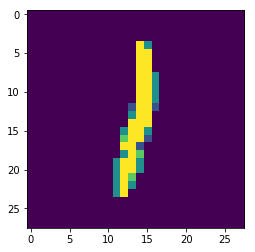

1


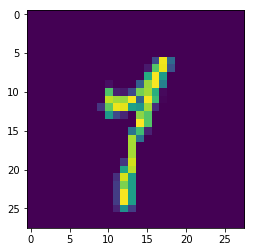

1


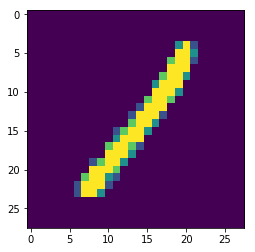

1


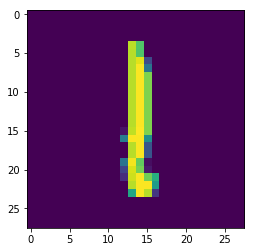

1


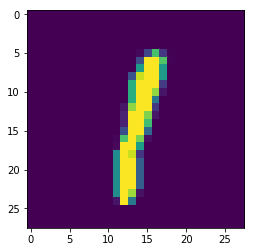

1


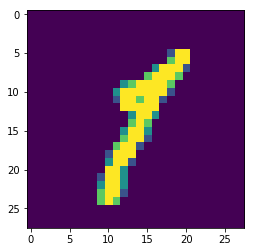

1


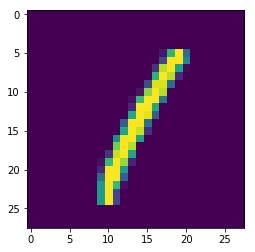

1


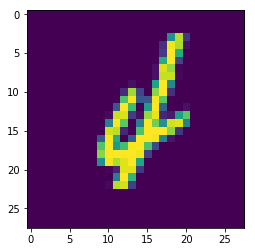

1


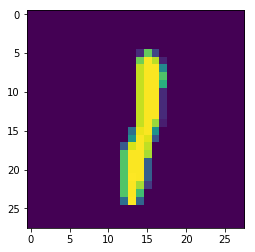

1


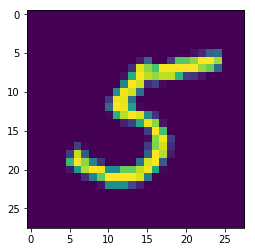

1


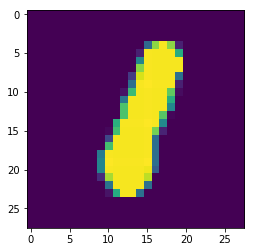

1


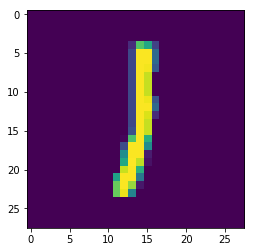

1


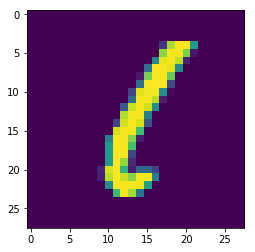

1


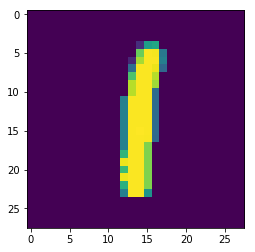

1


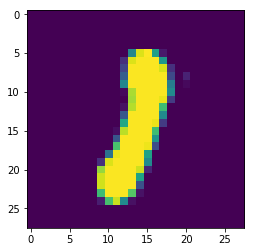

1


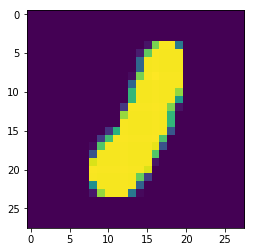

1


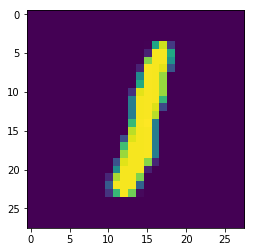

1


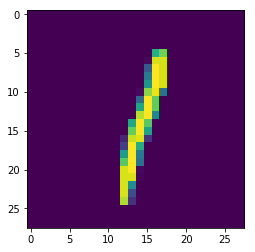

1


KeyboardInterrupt: 

In [141]:
for i in range(708):
    print(Ytrm[i])
    showImage(Xtrm[i])

In [142]:
trainM_dataset2 = []
testM_dataset2 = []

for i in range(Xtrm.shape[0]):
   trainM_dataset2.append([Xtrm[i], Ytrm[i]])
for i in range(Xtsm.shape[0]):
   testM_dataset2.append([Xtsm[i], Ytsm[i]])

trainM_loader2 = DataLoader(dataset=trainM_dataset2, batch_size=batch_size, shuffle=True)
testM_loader2 = DataLoader(dataset=testM_dataset2, batch_size=batch_size, shuffle=True)

In [143]:
# Copied from website then edited
# Wesite URL: https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/

model3 = ConvNet()

# Loss and optimizer
criterion3 = nn.CrossEntropyLoss()
optimizer3 = torch.optim.Adam(model3.parameters(), lr=learning_rate)

In [144]:
# Copied from website then edited
# Wesite URL: https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/

# Train the model
total_step3 = len(trainM_loader2)
loss_list3 = []
acc_list3 = []
Yacc3 = []
Yloss3 = []
for epoch in range(num_epochs):
    for i, (imgs, lbls) in enumerate(trainM_loader2):
        # Run the forward pass
        outputs = model3(imgs)
        #print(outputs.shape)
        loss = criterion3(outputs, lbls)
        loss_list3.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer3.zero_grad()
        loss.backward()
        optimizer3.step()

        # Track the accuracy
        total = lbls.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == lbls).sum().item()
        acc_list3.append(correct / total)

        if (i + 1) % int(printNow) == 0:
            Yacc3.append((correct / total) * 100)
            Yloss3.append(loss.item())
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/2], Step [1/121], Loss: 2.3968, Accuracy: 36.00%
Epoch [1/2], Step [2/121], Loss: 1.4055, Accuracy: 88.00%
Epoch [1/2], Step [3/121], Loss: 0.6867, Accuracy: 84.00%
Epoch [1/2], Step [4/121], Loss: 1.1374, Accuracy: 68.00%
Epoch [1/2], Step [5/121], Loss: 1.1054, Accuracy: 16.00%
Epoch [1/2], Step [6/121], Loss: 0.5331, Accuracy: 96.00%
Epoch [1/2], Step [7/121], Loss: 1.0311, Accuracy: 64.00%
Epoch [1/2], Step [8/121], Loss: 0.4461, Accuracy: 80.00%
Epoch [1/2], Step [9/121], Loss: 0.6729, Accuracy: 76.00%
Epoch [1/2], Step [10/121], Loss: 0.8372, Accuracy: 72.00%
Epoch [1/2], Step [11/121], Loss: 0.7131, Accuracy: 76.00%
Epoch [1/2], Step [12/121], Loss: 0.8125, Accuracy: 56.00%
Epoch [1/2], Step [13/121], Loss: 0.3754, Accuracy: 92.00%
Epoch [1/2], Step [14/121], Loss: 0.5530, Accuracy: 68.00%
Epoch [1/2], Step [15/121], Loss: 0.5623, Accuracy: 64.00%
Epoch [1/2], Step [16/121], Loss: 0.3285, Accuracy: 80.00%
Epoch [1/2], Step [17/121], Loss: 0.5484, Accuracy: 80.00%
Epoch 

In [145]:
# Copied from website then edited
# Wesite URL: https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/

# Test the model
model3.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testM_loader2:
        outputs = model3(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model: {} %'.format((correct / total) * 100))


Test Accuracy of the model: 18.23920265780731 %


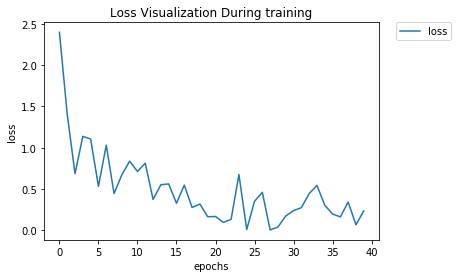

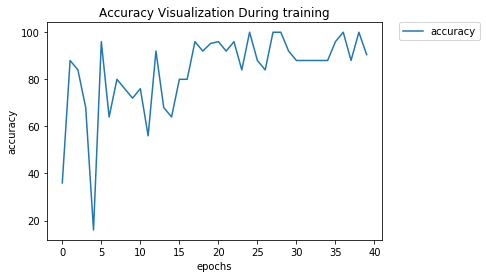

In [146]:

plt.plot(Yloss3, label="loss") 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) 
plt.xlabel('epochs')
plt.ylabel('loss') 
plt.title('Loss Visualization During training') 
plt.show() 


plt.plot(Yacc3, label="accuracy") 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) 
plt.xlabel('epochs') 
plt.ylabel('accuracy') 
plt.title('Accuracy Visualization During training') 

plt.show()

Expected Label: 7 Correct Label: 6


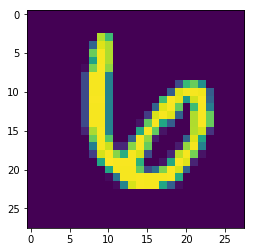

Expected Label: 7 Correct Label: 7


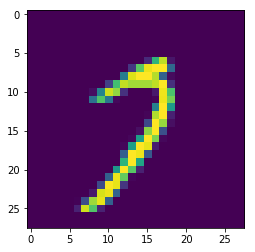

Expected Label: 1 Correct Label: 4


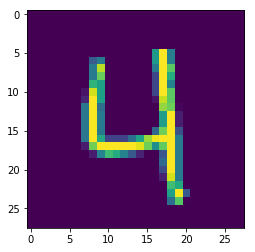

Expected Label: 7 Correct Label: 9


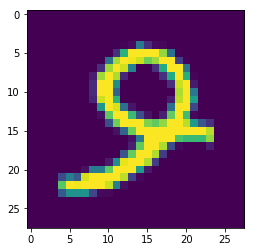

Expected Label: 1 Correct Label: 2


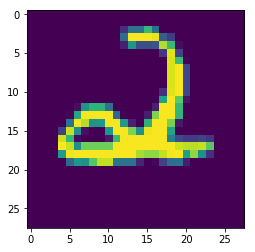

Expected Label: 7 Correct Label: 7


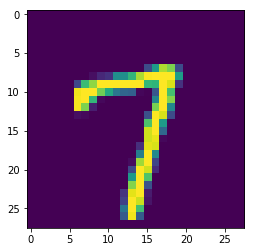

Expected Label: 1 Correct Label: 1


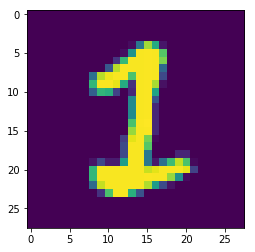

Expected Label: 1 Correct Label: 1


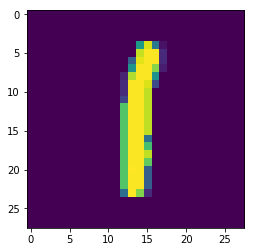

Expected Label: 1 Correct Label: 9


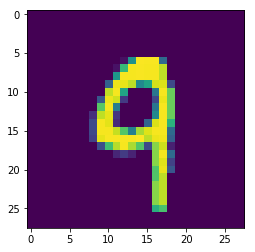

Expected Label: 1 Correct Label: 6


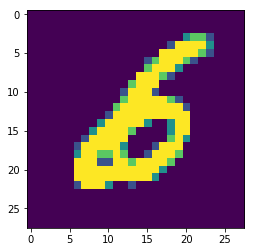

In [147]:
model3.eval()
images, labels = next(iter(testM_loader))
outputs = model3(images)
_, predicted = torch.max(outputs.data, 1)


for i in range(10):
    print(f'Expected Label: {predicted[i]} Correct Label: {labels[i]}')
    showImage(images[i])